In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
# import tensorflow as tf
# from path import Path
# from fastai.vision.all import *
from PIL import Image
import random

In [4]:
DS_PATH = './dataset'

In [3]:
train_dir = os.path.join(DS_PATH, 'Train')
test_dir = os.path.join(DS_PATH, 'TestR')
train_aug = os.path.join(DS_PATH, 'train')

In [4]:
trains = {name: len([f_name for f_name in os.listdir(train_dir + '/' + name) if os.path.isfile(train_dir + '/' + name + '/' + f_name)]) for name in os.listdir(train_dir)}

In [5]:
trains = {k: v for k, v in sorted(trains.items(), key=lambda item: int(item[0]))}

<BarContainer object of 43 artists>

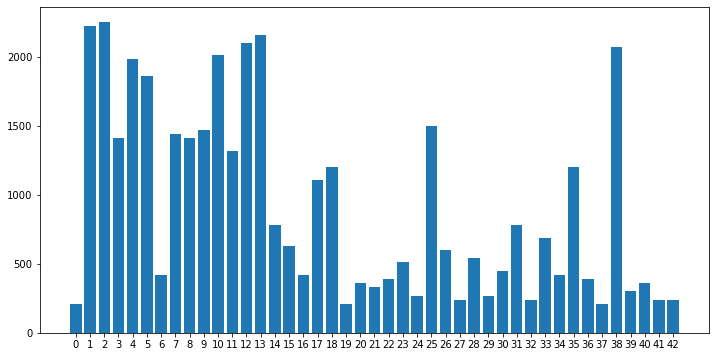

In [6]:
plt.figure(figsize=(12, 6))
plt.bar([k for k in trains.keys()], [v for v in trains.values()])

In [37]:
tests = {name: len([f_name for f_name in os.listdir(test_dir + '/' + name) if os.path.isfile(test_dir + '/' + name + '/' + f_name)]) for name in os.listdir(test_dir)}

In [38]:
tests = {k: v for k, v in sorted(tests.items(), key=lambda item: int(item[0]))}

<BarContainer object of 43 artists>

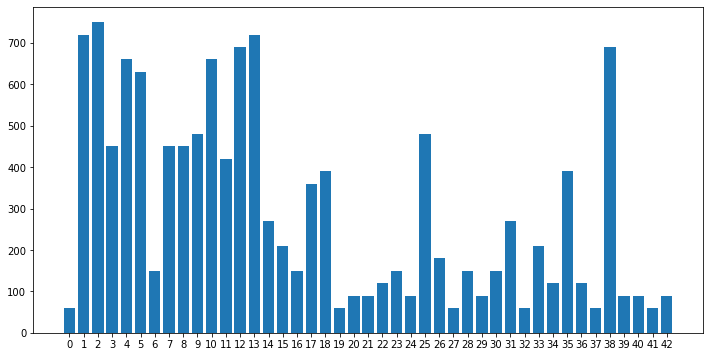

In [39]:
plt.figure(figsize=(12, 6))
plt.bar([k for k in tests.keys()], [v for v in tests.values()])

<Figure size 864x864 with 0 Axes>

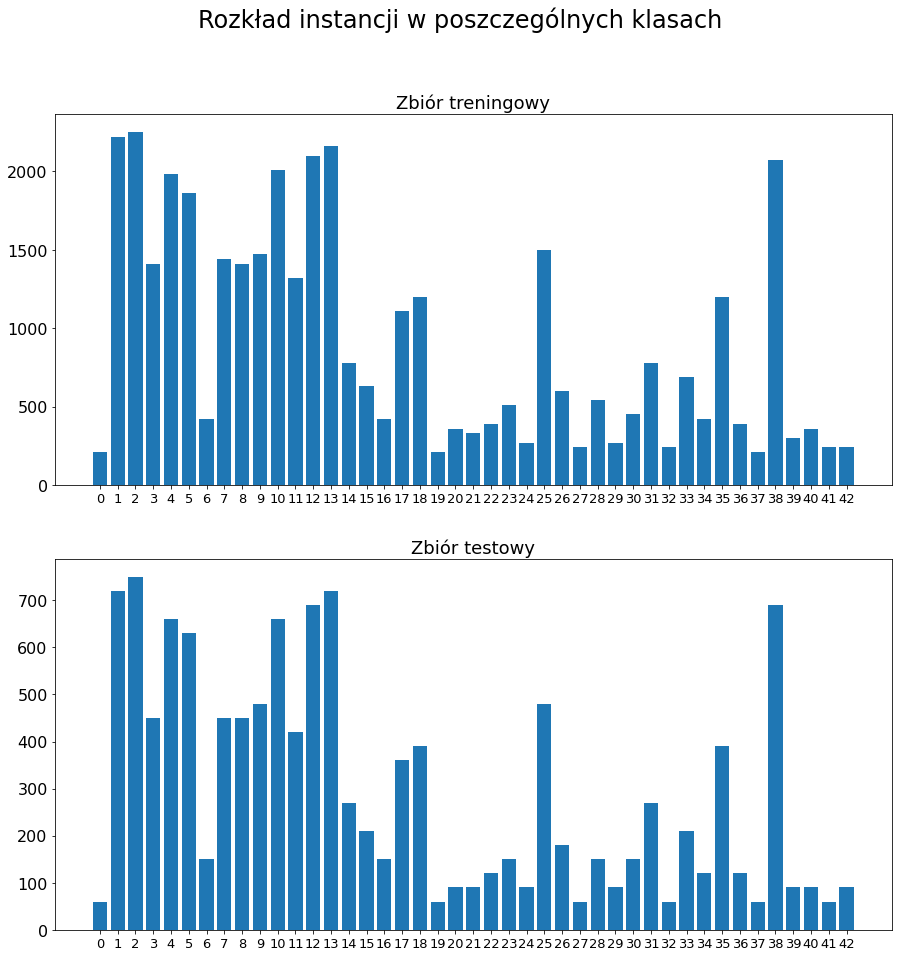

In [66]:
plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=12)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels
# plt.rc('legend', fontsize=5)    # legend fontsize
# plt.rc('figure', titlesize=BIGGER_SIZE)


plt.figure(figsize=(12, 12))
fig, axs = plt.subplots(2)
fig.suptitle('Rozkład instancji w poszczególnych klasach')
axs[1].bar([k for k in tests.keys()], [v for v in tests.values()])
axs[0].bar([k for k in trains.keys()], [v for v in trains.values()])
axs[0].set_title("Zbiór treningowy")
axs[1].set_title("Zbiór testowy")
fig.set_figheight(15)
fig.set_figwidth(15)

fig.savefig('rozklad_klas')

# Augmentacja dla zbalansowania zbioru treningowego

In [69]:
train_max = max(trains.values())

In [193]:
times = {}
for cls, items in trains.items():
    times[cls] = train_max / items - 1

In [194]:
times

{'0': 9.714285714285714,
 '1': 0.013513513513513598,
 '2': 0.0,
 '3': 0.5957446808510638,
 '4': 0.13636363636363646,
 '5': 0.20967741935483875,
 '6': 4.357142857142857,
 '7': 0.5625,
 '8': 0.5957446808510638,
 '9': 0.5306122448979591,
 '10': 0.11940298507462677,
 '11': 0.7045454545454546,
 '12': 0.0714285714285714,
 '13': 0.04166666666666674,
 '14': 1.8846153846153846,
 '15': 2.5714285714285716,
 '16': 4.357142857142857,
 '17': 1.0270270270270272,
 '18': 0.875,
 '19': 9.714285714285714,
 '20': 5.25,
 '21': 5.818181818181818,
 '22': 4.769230769230769,
 '23': 3.4117647058823533,
 '24': 7.333333333333334,
 '25': 0.5,
 '26': 2.75,
 '27': 8.375,
 '28': 3.166666666666667,
 '29': 7.333333333333334,
 '30': 4.0,
 '31': 1.8846153846153846,
 '32': 8.375,
 '33': 2.265602322206096,
 '34': 4.357142857142857,
 '35': 0.875,
 '36': 4.769230769230769,
 '37': 9.714285714285714,
 '38': 0.08695652173913038,
 '39': 6.5,
 '40': 5.25,
 '41': 8.375,
 '42': 8.375}

In [167]:
# image = Image.open('./dataset/train/0/00000_00000_00000.png').convert("RGBA")
# image = imageio.imread('./dataset/train/0/00000_00000_00000.png')

# Import segmentation maps from imgaug
from imgaug.augmentables.segmaps import SegmentationMapsOnImage

def augment(pil_mask, times):
    np_mask = np.array(pil_mask)
    np_mask = np.clip(np_mask, 0, 1)

    # Create segmentation map
    segmap = np.zeros(image.shape, dtype=bool)
    segmap[:] = np_mask
    segmap = SegmentationMapsOnImage(segmap, shape=image.shape)

    # Initialize augmentations pipeline
    seq = iaa.Sequential([
        iaa.Fliplr(0.5), # horizontal flips
        iaa.Crop(percent=(0, 0.1)), # random crops
        # Small gaussian blur with random sigma between 0 and 0.5.
        # But we only blur about 50% of all images.
        iaa.Sometimes(
            0.5,
            iaa.GaussianBlur(sigma=(0, 0.5))
        ),
        # Strengthen or weaken the contrast in each image.
        iaa.LinearContrast((0.75, 1.5)),
        # Add gaussian noise.
        # For 50% of all images, we sample the noise once per pixel.
        # For the other 50% of all images, we sample the noise per pixel AND
        # channel. This can change the color (not only brightness) of the
        # pixels.
        iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
        # Make some images brighter and some darker.
        # In 20% of all cases, we sample the multiplier once per channel,
        # which can end up changing the color of the images.
    #     iaa.Multiply((0.8, 1.2), per_channel=0.2),
        # Apply affine transformations to each image.
        # Scale/zoom them, translate/move them, rotate them and shear them.
        iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
            rotate=(-25, 25),
            shear=(-8, 8)
        )
    ], random_order=True)
    
    aug_images = []
    for _ in range(times):
        image_aug, segmap_aug = seq(image=image, segmentation_maps=segmap)
        aug_images.append(image_aug)
        
    return aug_images
        

    

# Open image with mask




In [168]:
image = imageio.imread('./dataset/train/0/00000_00000_00000.png')
mm = augment(image, 8)

In [204]:
base_path = './dataset/train/'
random.seed = 42

for cls, time in times.items():
    if time:
        prob = time if time < 1.0 else 1.0
        for img_file in os.listdir(base_path + cls):
            rand = random.random()
            if rand < prob:
                image = imageio.imread(base_path + cls+ '/' + img_file)
#                 augmented = augment(image, int(time) if time > 1.0 else 1)
                  augmented = image
                for idx, to_save in enumerate(augmented):
                    name = img_file.split('.')[0] + '_au' + str(idx) + '.png'
                    print(name)
                    imageio.imsave(base_path + cls+ '/' + name, to_save)

00000_00004_00022_au0.png
00000_00004_00022_au1.png
00000_00004_00022_au2.png
00000_00004_00022_au3.png
00000_00004_00022_au4.png
00000_00004_00022_au5.png
00000_00004_00022_au6.png
00000_00004_00022_au7.png
00000_00004_00022_au8.png
00000_00000_00012_au0.png
00000_00000_00012_au1.png
00000_00000_00012_au2.png
00000_00000_00012_au3.png
00000_00000_00012_au4.png
00000_00000_00012_au5.png
00000_00000_00012_au6.png
00000_00000_00012_au7.png
00000_00000_00012_au8.png
00000_00000_00020_au0.png
00000_00000_00020_au1.png
00000_00000_00020_au2.png
00000_00000_00020_au3.png
00000_00000_00020_au4.png
00000_00000_00020_au5.png
00000_00000_00020_au6.png
00000_00000_00020_au7.png
00000_00000_00020_au8.png
00000_00004_00023_au0.png
00000_00004_00023_au1.png
00000_00004_00023_au2.png
00000_00004_00023_au3.png
00000_00004_00023_au4.png
00000_00004_00023_au5.png
00000_00004_00023_au6.png
00000_00004_00023_au7.png
00000_00004_00023_au8.png
00000_00000_00024_au0.png
00000_00000_00024_au1.png
00000_00000_

00000_00001_00009_au0.png
00000_00001_00009_au1.png
00000_00001_00009_au2.png
00000_00001_00009_au3.png
00000_00001_00009_au4.png
00000_00001_00009_au5.png
00000_00001_00009_au6.png
00000_00001_00009_au7.png
00000_00001_00009_au8.png
00000_00002_00001_au0.png
00000_00002_00001_au1.png
00000_00002_00001_au2.png
00000_00002_00001_au3.png
00000_00002_00001_au4.png
00000_00002_00001_au5.png
00000_00002_00001_au6.png
00000_00002_00001_au7.png
00000_00002_00001_au8.png
00000_00006_00020_au0.png
00000_00006_00020_au1.png
00000_00006_00020_au2.png
00000_00006_00020_au3.png
00000_00006_00020_au4.png
00000_00006_00020_au5.png
00000_00006_00020_au6.png
00000_00006_00020_au7.png
00000_00006_00020_au8.png
00000_00002_00004_au0.png
00000_00002_00004_au1.png
00000_00002_00004_au2.png
00000_00002_00004_au3.png
00000_00002_00004_au4.png
00000_00002_00004_au5.png
00000_00002_00004_au6.png
00000_00002_00004_au7.png
00000_00002_00004_au8.png
00000_00002_00003_au0.png
00000_00002_00003_au1.png
00000_00002_

00000_00001_00013_au0.png
00000_00001_00013_au1.png
00000_00001_00013_au2.png
00000_00001_00013_au3.png
00000_00001_00013_au4.png
00000_00001_00013_au5.png
00000_00001_00013_au6.png
00000_00001_00013_au7.png
00000_00001_00013_au8.png
00000_00004_00004_au0.png
00000_00004_00004_au1.png
00000_00004_00004_au2.png
00000_00004_00004_au3.png
00000_00004_00004_au4.png
00000_00004_00004_au5.png
00000_00004_00004_au6.png
00000_00004_00004_au7.png
00000_00004_00004_au8.png
00000_00006_00005_au0.png
00000_00006_00005_au1.png
00000_00006_00005_au2.png
00000_00006_00005_au3.png
00000_00006_00005_au4.png
00000_00006_00005_au5.png
00000_00006_00005_au6.png
00000_00006_00005_au7.png
00000_00006_00005_au8.png
00000_00002_00010_au0.png
00000_00002_00010_au1.png
00000_00002_00010_au2.png
00000_00002_00010_au3.png
00000_00002_00010_au4.png
00000_00002_00010_au5.png
00000_00002_00010_au6.png
00000_00002_00010_au7.png
00000_00002_00010_au8.png
00000_00002_00008_au0.png
00000_00002_00008_au1.png
00000_00002_

00000_00004_00024_au5.png
00000_00004_00024_au6.png
00000_00004_00024_au7.png
00000_00004_00024_au8.png
00000_00003_00022_au0.png
00000_00003_00022_au1.png
00000_00003_00022_au2.png
00000_00003_00022_au3.png
00000_00003_00022_au4.png
00000_00003_00022_au5.png
00000_00003_00022_au6.png
00000_00003_00022_au7.png
00000_00003_00022_au8.png
00000_00002_00021_au0.png
00000_00002_00021_au1.png
00000_00002_00021_au2.png
00000_00002_00021_au3.png
00000_00002_00021_au4.png
00000_00002_00021_au5.png
00000_00002_00021_au6.png
00000_00002_00021_au7.png
00000_00002_00021_au8.png
00000_00004_00014_au0.png
00000_00004_00014_au1.png
00000_00004_00014_au2.png
00000_00004_00014_au3.png
00000_00004_00014_au4.png
00000_00004_00014_au5.png
00000_00004_00014_au6.png
00000_00004_00014_au7.png
00000_00004_00014_au8.png
00000_00004_00012_au0.png
00000_00004_00012_au1.png
00000_00004_00012_au2.png
00000_00004_00012_au3.png
00000_00004_00012_au4.png
00000_00004_00012_au5.png
00000_00004_00012_au6.png
00000_00004_

00000_00000_00003_au0.png
00000_00000_00003_au1.png
00000_00000_00003_au2.png
00000_00000_00003_au3.png
00000_00000_00003_au4.png
00000_00000_00003_au5.png
00000_00000_00003_au6.png
00000_00000_00003_au7.png
00000_00000_00003_au8.png
00000_00003_00027_au0.png
00000_00003_00027_au1.png
00000_00003_00027_au2.png
00000_00003_00027_au3.png
00000_00003_00027_au4.png
00000_00003_00027_au5.png
00000_00003_00027_au6.png
00000_00003_00027_au7.png
00000_00003_00027_au8.png
00000_00005_00016_au0.png
00000_00005_00016_au1.png
00000_00005_00016_au2.png
00000_00005_00016_au3.png
00000_00005_00016_au4.png
00000_00005_00016_au5.png
00000_00005_00016_au6.png
00000_00005_00016_au7.png
00000_00005_00016_au8.png
00000_00001_00015_au0.png
00000_00001_00015_au1.png
00000_00001_00015_au2.png
00000_00001_00015_au3.png
00000_00001_00015_au4.png
00000_00001_00015_au5.png
00000_00001_00015_au6.png
00000_00001_00015_au7.png
00000_00001_00015_au8.png
00000_00003_00021_au0.png
00000_00003_00021_au1.png
00000_00003_

00000_00006_00023_au0.png
00000_00006_00023_au1.png
00000_00006_00023_au2.png
00000_00006_00023_au3.png
00000_00006_00023_au4.png
00000_00006_00023_au5.png
00000_00006_00023_au6.png
00000_00006_00023_au7.png
00000_00006_00023_au8.png
00000_00002_00023_au0.png
00000_00002_00023_au1.png
00000_00002_00023_au2.png
00000_00002_00023_au3.png
00000_00002_00023_au4.png
00000_00002_00023_au5.png
00000_00002_00023_au6.png
00000_00002_00023_au7.png
00000_00002_00023_au8.png
00000_00005_00004_au0.png
00000_00005_00004_au1.png
00000_00005_00004_au2.png
00000_00005_00004_au3.png
00000_00005_00004_au4.png
00000_00005_00004_au5.png
00000_00005_00004_au6.png
00000_00005_00004_au7.png
00000_00005_00004_au8.png
00000_00002_00018_au0.png
00000_00002_00018_au1.png
00000_00002_00018_au2.png
00000_00002_00018_au3.png
00000_00002_00018_au4.png
00000_00002_00018_au5.png
00000_00002_00018_au6.png
00000_00002_00018_au7.png
00000_00002_00018_au8.png
00000_00004_00000_au0.png
00000_00004_00000_au1.png
00000_00004_

00003_00041_00003_au0.png
00003_00037_00015_au0.png
00003_00042_00029_au0.png
00003_00014_00018_au0.png
00003_00034_00008_au0.png
00003_00015_00018_au0.png
00003_00005_00010_au0.png
00003_00004_00000_au0.png
00003_00007_00029_au0.png
00003_00005_00024_au0.png
00003_00038_00016_au0.png
00003_00032_00016_au0.png
00003_00009_00019_au0.png
00003_00011_00002_au0.png
00003_00028_00028_au0.png
00003_00005_00025_au0.png
00003_00002_00008_au0.png
00003_00027_00006_au0.png
00003_00046_00012_au0.png
00003_00022_00012_au0.png
00003_00040_00019_au0.png
00003_00023_00005_au0.png
00003_00008_00007_au0.png
00003_00039_00008_au0.png
00003_00001_00029_au0.png
00003_00025_00027_au0.png
00003_00016_00011_au0.png
00003_00000_00001_au0.png
00003_00041_00000_au0.png
00003_00016_00015_au0.png
00003_00018_00028_au0.png
00003_00013_00018_au0.png
00003_00044_00003_au0.png
00003_00006_00013_au0.png
00003_00035_00020_au0.png
00003_00040_00008_au0.png
00003_00000_00000_au0.png
00003_00044_00028_au0.png
00003_00039_

00003_00027_00029_au0.png
00003_00009_00012_au0.png
00003_00009_00006_au0.png
00003_00002_00002_au0.png
00003_00044_00025_au0.png
00003_00003_00008_au0.png
00003_00037_00021_au0.png
00003_00005_00020_au0.png
00003_00001_00028_au0.png
00003_00034_00009_au0.png
00003_00020_00010_au0.png
00003_00003_00018_au0.png
00003_00044_00005_au0.png
00003_00025_00020_au0.png
00003_00022_00004_au0.png
00003_00025_00001_au0.png
00003_00005_00014_au0.png
00003_00011_00018_au0.png
00003_00015_00003_au0.png
00003_00045_00014_au0.png
00003_00005_00008_au0.png
00003_00011_00023_au0.png
00003_00027_00002_au0.png
00003_00046_00022_au0.png
00003_00024_00023_au0.png
00003_00032_00028_au0.png
00003_00011_00001_au0.png
00003_00044_00018_au0.png
00003_00008_00013_au0.png
00003_00021_00020_au0.png
00003_00044_00019_au0.png
00003_00046_00025_au0.png
00003_00039_00001_au0.png
00003_00040_00027_au0.png
00003_00024_00015_au0.png
00003_00009_00010_au0.png
00003_00009_00023_au0.png
00003_00011_00006_au0.png
00003_00035_

00003_00032_00003_au0.png
00003_00008_00019_au0.png
00003_00044_00009_au0.png
00003_00031_00012_au0.png
00003_00014_00020_au0.png
00003_00034_00028_au0.png
00003_00012_00011_au0.png
00003_00035_00029_au0.png
00003_00004_00017_au0.png
00003_00006_00020_au0.png
00003_00017_00023_au0.png
00003_00014_00017_au0.png
00003_00016_00021_au0.png
00003_00026_00022_au0.png
00003_00030_00008_au0.png
00003_00006_00019_au0.png
00003_00023_00004_au0.png
00003_00000_00011_au0.png
00003_00026_00005_au0.png
00003_00041_00021_au0.png
00003_00046_00018_au0.png
00003_00022_00011_au0.png
00003_00022_00019_au0.png
00003_00036_00020_au0.png
00003_00002_00001_au0.png
00003_00028_00012_au0.png
00003_00014_00028_au0.png
00003_00017_00008_au0.png
00003_00035_00028_au0.png
00003_00041_00016_au0.png
00003_00004_00019_au0.png
00003_00017_00010_au0.png
00003_00027_00024_au0.png
00003_00041_00018_au0.png
00003_00002_00010_au0.png
00003_00042_00000_au0.png
00003_00023_00013_au0.png
00003_00033_00000_au0.png
00003_00022_

00004_00051_00007_au0.png
00004_00063_00015_au0.png
00004_00025_00026_au0.png
00004_00060_00024_au0.png
00004_00011_00003_au0.png
00004_00037_00010_au0.png
00004_00014_00016_au0.png
00004_00011_00026_au0.png
00004_00032_00009_au0.png
00004_00048_00008_au0.png
00004_00017_00028_au0.png
00004_00016_00028_au0.png
00004_00050_00021_au0.png
00004_00006_00021_au0.png
00004_00007_00029_au0.png
00004_00032_00025_au0.png
00004_00000_00021_au0.png
00004_00035_00025_au0.png
00004_00040_00028_au0.png
00004_00041_00000_au0.png
00004_00040_00022_au0.png
00004_00031_00008_au0.png
00004_00054_00006_au0.png
00005_00036_00021_au0.png
00005_00033_00009_au0.png
00005_00044_00018_au0.png
00005_00005_00028_au0.png
00005_00018_00002_au0.png
00005_00046_00004_au0.png
00005_00060_00005_au0.png
00005_00039_00014_au0.png
00005_00028_00001_au0.png
00005_00013_00010_au0.png
00005_00046_00028_au0.png
00005_00020_00008_au0.png
00005_00016_00008_au0.png
00005_00003_00017_au0.png
00005_00024_00029_au0.png
00005_00017_

00005_00022_00019_au0.png
00005_00008_00006_au0.png
00005_00001_00004_au0.png
00005_00029_00009_au0.png
00005_00057_00016_au0.png
00005_00025_00013_au0.png
00005_00057_00021_au0.png
00005_00027_00001_au0.png
00005_00034_00018_au0.png
00005_00035_00006_au0.png
00005_00030_00012_au0.png
00005_00052_00019_au0.png
00005_00059_00020_au0.png
00005_00014_00009_au0.png
00005_00006_00024_au0.png
00005_00035_00028_au0.png
00005_00038_00029_au0.png
00005_00004_00018_au0.png
00005_00012_00000_au0.png
00005_00011_00002_au0.png
00005_00061_00024_au0.png
00005_00061_00017_au0.png
00005_00006_00008_au0.png
00005_00040_00002_au0.png
00005_00031_00010_au0.png
00005_00033_00022_au0.png
00005_00043_00008_au0.png
00005_00021_00013_au0.png
00005_00061_00022_au0.png
00005_00043_00029_au0.png
00005_00037_00026_au0.png
00005_00053_00006_au0.png
00005_00012_00002_au0.png
00005_00059_00002_au0.png
00005_00033_00023_au0.png
00005_00016_00000_au0.png
00005_00001_00023_au0.png
00005_00024_00005_au0.png
00005_00007_

00006_00013_00015_au0.png
00006_00013_00015_au1.png
00006_00013_00015_au2.png
00006_00013_00015_au3.png
00006_00008_00000_au0.png
00006_00008_00000_au1.png
00006_00008_00000_au2.png
00006_00008_00000_au3.png
00006_00005_00026_au0.png
00006_00005_00026_au1.png
00006_00005_00026_au2.png
00006_00005_00026_au3.png
00006_00007_00022_au0.png
00006_00007_00022_au1.png
00006_00007_00022_au2.png
00006_00007_00022_au3.png
00006_00003_00023_au0.png
00006_00003_00023_au1.png
00006_00003_00023_au2.png
00006_00003_00023_au3.png
00006_00005_00012_au0.png
00006_00005_00012_au1.png
00006_00005_00012_au2.png
00006_00005_00012_au3.png
00006_00010_00021_au0.png
00006_00010_00021_au1.png
00006_00010_00021_au2.png
00006_00010_00021_au3.png
00006_00004_00019_au0.png
00006_00004_00019_au1.png
00006_00004_00019_au2.png
00006_00004_00019_au3.png
00006_00009_00006_au0.png
00006_00009_00006_au1.png
00006_00009_00006_au2.png
00006_00009_00006_au3.png
00006_00001_00005_au0.png
00006_00001_00005_au1.png
00006_00001_

00006_00008_00026_au0.png
00006_00008_00026_au1.png
00006_00008_00026_au2.png
00006_00008_00026_au3.png
00006_00010_00003_au0.png
00006_00010_00003_au1.png
00006_00010_00003_au2.png
00006_00010_00003_au3.png
00006_00003_00028_au0.png
00006_00003_00028_au1.png
00006_00003_00028_au2.png
00006_00003_00028_au3.png
00006_00003_00014_au0.png
00006_00003_00014_au1.png
00006_00003_00014_au2.png
00006_00003_00014_au3.png
00006_00006_00006_au0.png
00006_00006_00006_au1.png
00006_00006_00006_au2.png
00006_00006_00006_au3.png
00006_00003_00013_au0.png
00006_00003_00013_au1.png
00006_00003_00013_au2.png
00006_00003_00013_au3.png
00006_00006_00018_au0.png
00006_00006_00018_au1.png
00006_00006_00018_au2.png
00006_00006_00018_au3.png
00006_00012_00016_au0.png
00006_00012_00016_au1.png
00006_00012_00016_au2.png
00006_00012_00016_au3.png
00006_00007_00008_au0.png
00006_00007_00008_au1.png
00006_00007_00008_au2.png
00006_00007_00008_au3.png
00006_00013_00012_au0.png
00006_00013_00012_au1.png
00006_00013_

00006_00002_00001_au1.png
00006_00002_00001_au2.png
00006_00002_00001_au3.png
00006_00002_00009_au0.png
00006_00002_00009_au1.png
00006_00002_00009_au2.png
00006_00002_00009_au3.png
00006_00013_00000_au0.png
00006_00013_00000_au1.png
00006_00013_00000_au2.png
00006_00013_00000_au3.png
00006_00012_00009_au0.png
00006_00012_00009_au1.png
00006_00012_00009_au2.png
00006_00012_00009_au3.png
00006_00007_00016_au0.png
00006_00007_00016_au1.png
00006_00007_00016_au2.png
00006_00007_00016_au3.png
00006_00006_00019_au0.png
00006_00006_00019_au1.png
00006_00006_00019_au2.png
00006_00006_00019_au3.png
00006_00009_00019_au0.png
00006_00009_00019_au1.png
00006_00009_00019_au2.png
00006_00009_00019_au3.png
00006_00013_00002_au0.png
00006_00013_00002_au1.png
00006_00013_00002_au2.png
00006_00013_00002_au3.png
00006_00000_00026_au0.png
00006_00000_00026_au1.png
00006_00000_00026_au2.png
00006_00000_00026_au3.png
00006_00009_00010_au0.png
00006_00009_00010_au1.png
00006_00009_00010_au2.png
00006_00009_

00006_00000_00008_au0.png
00006_00000_00008_au1.png
00006_00000_00008_au2.png
00006_00000_00008_au3.png
00006_00013_00027_au0.png
00006_00013_00027_au1.png
00006_00013_00027_au2.png
00006_00013_00027_au3.png
00006_00001_00002_au0.png
00006_00001_00002_au1.png
00006_00001_00002_au2.png
00006_00001_00002_au3.png
00006_00005_00024_au0.png
00006_00005_00024_au1.png
00006_00005_00024_au2.png
00006_00005_00024_au3.png
00006_00013_00022_au0.png
00006_00013_00022_au1.png
00006_00013_00022_au2.png
00006_00013_00022_au3.png
00006_00000_00025_au0.png
00006_00000_00025_au1.png
00006_00000_00025_au2.png
00006_00000_00025_au3.png
00006_00004_00026_au0.png
00006_00004_00026_au1.png
00006_00004_00026_au2.png
00006_00004_00026_au3.png
00006_00004_00023_au0.png
00006_00004_00023_au1.png
00006_00004_00023_au2.png
00006_00004_00023_au3.png
00006_00006_00013_au0.png
00006_00006_00013_au1.png
00006_00006_00013_au2.png
00006_00006_00013_au3.png
00006_00001_00022_au0.png
00006_00001_00022_au1.png
00006_00001_

00006_00013_00003_au2.png
00006_00013_00003_au3.png
00006_00009_00011_au0.png
00006_00009_00011_au1.png
00006_00009_00011_au2.png
00006_00009_00011_au3.png
00006_00008_00007_au0.png
00006_00008_00007_au1.png
00006_00008_00007_au2.png
00006_00008_00007_au3.png
00006_00011_00024_au0.png
00006_00011_00024_au1.png
00006_00011_00024_au2.png
00006_00011_00024_au3.png
00006_00004_00001_au0.png
00006_00004_00001_au1.png
00006_00004_00001_au2.png
00006_00004_00001_au3.png
00006_00010_00001_au0.png
00006_00010_00001_au1.png
00006_00010_00001_au2.png
00006_00010_00001_au3.png
00006_00007_00026_au0.png
00006_00007_00026_au1.png
00006_00007_00026_au2.png
00006_00007_00026_au3.png
00006_00009_00013_au0.png
00006_00009_00013_au1.png
00006_00009_00013_au2.png
00006_00009_00013_au3.png
00006_00013_00013_au0.png
00006_00013_00013_au1.png
00006_00013_00013_au2.png
00006_00013_00013_au3.png
00006_00005_00029_au0.png
00006_00005_00029_au1.png
00006_00005_00029_au2.png
00006_00005_00029_au3.png
00006_00001_

00007_00029_00000_au0.png
00007_00004_00004_au0.png
00007_00014_00004_au0.png
00007_00010_00016_au0.png
00007_00032_00009_au0.png
00007_00022_00018_au0.png
00007_00007_00029_au0.png
00007_00003_00024_au0.png
00007_00038_00014_au0.png
00007_00033_00015_au0.png
00007_00021_00009_au0.png
00007_00020_00016_au0.png
00007_00043_00005_au0.png
00007_00045_00019_au0.png
00007_00017_00017_au0.png
00007_00027_00014_au0.png
00007_00027_00022_au0.png
00007_00004_00014_au0.png
00007_00038_00027_au0.png
00007_00004_00026_au0.png
00007_00025_00005_au0.png
00007_00024_00009_au0.png
00007_00014_00001_au0.png
00007_00036_00001_au0.png
00007_00042_00008_au0.png
00007_00035_00006_au0.png
00007_00001_00000_au0.png
00007_00028_00026_au0.png
00007_00019_00023_au0.png
00007_00022_00016_au0.png
00007_00019_00025_au0.png
00007_00008_00014_au0.png
00007_00041_00006_au0.png
00007_00022_00028_au0.png
00007_00045_00025_au0.png
00007_00047_00013_au0.png
00007_00023_00015_au0.png
00007_00017_00013_au0.png
00007_00026_

00007_00045_00005_au0.png
00007_00035_00010_au0.png
00007_00001_00005_au0.png
00007_00046_00018_au0.png
00007_00021_00016_au0.png
00007_00008_00017_au0.png
00007_00035_00005_au0.png
00007_00029_00018_au0.png
00007_00014_00029_au0.png
00007_00032_00026_au0.png
00007_00028_00016_au0.png
00007_00047_00018_au0.png
00007_00045_00006_au0.png
00007_00007_00025_au0.png
00007_00045_00007_au0.png
00007_00038_00009_au0.png
00007_00002_00021_au0.png
00007_00037_00018_au0.png
00007_00046_00007_au0.png
00007_00032_00029_au0.png
00007_00039_00010_au0.png
00007_00038_00008_au0.png
00007_00005_00000_au0.png
00007_00005_00021_au0.png
00007_00044_00007_au0.png
00007_00041_00005_au0.png
00007_00011_00017_au0.png
00007_00046_00028_au0.png
00007_00003_00025_au0.png
00007_00019_00007_au0.png
00007_00010_00022_au0.png
00007_00008_00015_au0.png
00007_00017_00007_au0.png
00007_00000_00006_au0.png
00007_00019_00009_au0.png
00007_00044_00024_au0.png
00007_00035_00024_au0.png
00007_00044_00025_au0.png
00007_00005_

00008_00038_00009_au0.png
00008_00012_00024_au0.png
00008_00039_00022_au0.png
00008_00014_00021_au0.png
00008_00011_00018_au0.png
00008_00033_00021_au0.png
00008_00027_00010_au0.png
00008_00006_00016_au0.png
00008_00030_00023_au0.png
00008_00041_00022_au0.png
00008_00034_00001_au0.png
00008_00027_00007_au0.png
00008_00005_00013_au0.png
00008_00039_00028_au0.png
00008_00028_00022_au0.png
00008_00036_00012_au0.png
00008_00011_00021_au0.png
00008_00039_00027_au0.png
00008_00025_00023_au0.png
00008_00030_00016_au0.png
00008_00018_00009_au0.png
00008_00004_00025_au0.png
00008_00007_00013_au0.png
00008_00005_00020_au0.png
00008_00039_00016_au0.png
00008_00036_00025_au0.png
00008_00045_00018_au0.png
00008_00015_00006_au0.png
00008_00033_00029_au0.png
00008_00037_00014_au0.png
00008_00011_00008_au0.png
00008_00022_00004_au0.png
00008_00001_00007_au0.png
00008_00041_00025_au0.png
00008_00028_00016_au0.png
00008_00017_00006_au0.png
00008_00022_00013_au0.png
00008_00018_00008_au0.png
00008_00041_

00008_00008_00018_au0.png
00008_00040_00008_au0.png
00008_00012_00009_au0.png
00008_00026_00028_au0.png
00008_00013_00014_au0.png
00008_00016_00018_au0.png
00008_00035_00010_au0.png
00008_00045_00012_au0.png
00008_00000_00012_au0.png
00008_00019_00024_au0.png
00008_00020_00012_au0.png
00008_00044_00013_au0.png
00008_00032_00029_au0.png
00008_00007_00020_au0.png
00008_00029_00007_au0.png
00008_00012_00001_au0.png
00008_00014_00018_au0.png
00008_00039_00005_au0.png
00008_00025_00026_au0.png
00008_00019_00005_au0.png
00008_00007_00002_au0.png
00008_00039_00003_au0.png
00008_00019_00007_au0.png
00008_00044_00018_au0.png
00008_00039_00025_au0.png
00008_00028_00026_au0.png
00008_00025_00010_au0.png
00008_00023_00012_au0.png
00008_00045_00011_au0.png
00008_00018_00027_au0.png
00008_00045_00024_au0.png
00008_00031_00011_au0.png
00008_00033_00007_au0.png
00008_00006_00001_au0.png
00008_00006_00010_au0.png
00008_00011_00003_au0.png
00008_00023_00005_au0.png
00008_00003_00021_au0.png
00008_00023_

00008_00004_00023_au0.png
00008_00034_00005_au0.png
00008_00027_00021_au0.png
00008_00026_00004_au0.png
00008_00032_00026_au0.png
00008_00034_00004_au0.png
00008_00046_00001_au0.png
00008_00039_00023_au0.png
00008_00020_00025_au0.png
00008_00012_00006_au0.png
00008_00037_00009_au0.png
00008_00019_00027_au0.png
00008_00019_00010_au0.png
00008_00019_00008_au0.png
00008_00036_00001_au0.png
00008_00010_00010_au0.png
00008_00035_00025_au0.png
00008_00032_00010_au0.png
00008_00023_00008_au0.png
00008_00046_00003_au0.png
00008_00030_00028_au0.png
00008_00029_00015_au0.png
00008_00037_00018_au0.png
00008_00013_00020_au0.png
00008_00015_00004_au0.png
00008_00025_00025_au0.png
00008_00039_00015_au0.png
00008_00002_00018_au0.png
00008_00019_00018_au0.png
00008_00037_00002_au0.png
00008_00037_00023_au0.png
00008_00010_00003_au0.png
00008_00023_00006_au0.png
00008_00035_00003_au0.png
00008_00044_00023_au0.png
00008_00035_00002_au0.png
00008_00033_00006_au0.png
00008_00034_00008_au0.png
00008_00031_

00009_00006_00028_au0.png
00009_00009_00020_au0.png
00009_00000_00026_au0.png
00009_00044_00029_au0.png
00009_00047_00001_au0.png
00009_00021_00015_au0.png
00009_00004_00013_au0.png
00009_00004_00020_au0.png
00009_00029_00024_au0.png
00009_00013_00028_au0.png
00009_00042_00000_au0.png
00009_00030_00020_au0.png
00009_00013_00026_au0.png
00009_00017_00022_au0.png
00009_00048_00017_au0.png
00009_00000_00016_au0.png
00009_00028_00021_au0.png
00009_00003_00014_au0.png
00009_00040_00004_au0.png
00009_00004_00025_au0.png
00009_00046_00011_au0.png
00009_00032_00027_au0.png
00009_00046_00009_au0.png
00009_00043_00025_au0.png
00009_00009_00007_au0.png
00009_00021_00026_au0.png
00009_00012_00006_au0.png
00009_00029_00026_au0.png
00009_00002_00015_au0.png
00009_00029_00002_au0.png
00009_00002_00014_au0.png
00009_00027_00009_au0.png
00009_00027_00028_au0.png
00009_00013_00019_au0.png
00009_00040_00017_au0.png
00009_00023_00023_au0.png
00009_00001_00025_au0.png
00009_00029_00025_au0.png
00009_00030_

00009_00019_00015_au0.png
00009_00035_00005_au0.png
00009_00045_00016_au0.png
00009_00037_00016_au0.png
00009_00020_00012_au0.png
00009_00014_00021_au0.png
00009_00002_00012_au0.png
00009_00023_00025_au0.png
00009_00013_00004_au0.png
00009_00030_00024_au0.png
00009_00039_00015_au0.png
00009_00038_00019_au0.png
00009_00020_00028_au0.png
00009_00027_00020_au0.png
00009_00020_00018_au0.png
00009_00047_00005_au0.png
00009_00038_00004_au0.png
00009_00044_00009_au0.png
00009_00042_00024_au0.png
00009_00033_00008_au0.png
00009_00019_00013_au0.png
00009_00019_00028_au0.png
00009_00012_00028_au0.png
00009_00046_00018_au0.png
00009_00028_00006_au0.png
00009_00024_00024_au0.png
00009_00035_00010_au0.png
00009_00035_00027_au0.png
00009_00029_00023_au0.png
00009_00001_00028_au0.png
00009_00042_00013_au0.png
00009_00007_00006_au0.png
00009_00032_00000_au0.png
00009_00005_00022_au0.png
00009_00007_00028_au0.png
00009_00017_00021_au0.png
00009_00026_00026_au0.png
00009_00030_00007_au0.png
00009_00045_

00010_00035_00000_au0.png
00010_00023_00018_au0.png
00010_00058_00023_au0.png
00010_00050_00013_au0.png
00010_00015_00023_au0.png
00010_00064_00028_au0.png
00010_00058_00012_au0.png
00010_00050_00011_au0.png
00010_00045_00002_au0.png
00010_00031_00023_au0.png
00010_00050_00000_au0.png
00010_00038_00023_au0.png
00010_00024_00009_au0.png
00010_00066_00010_au0.png
00010_00051_00022_au0.png
00010_00036_00016_au0.png
00010_00049_00003_au0.png
00010_00045_00015_au0.png
00010_00045_00003_au0.png
00010_00015_00024_au0.png
00010_00017_00016_au0.png
00010_00056_00016_au0.png
00010_00056_00012_au0.png
00010_00020_00018_au0.png
00010_00029_00000_au0.png
00010_00002_00015_au0.png
00010_00054_00001_au0.png
00010_00029_00012_au0.png
00010_00065_00011_au0.png
00010_00030_00013_au0.png
00010_00017_00004_au0.png
00010_00003_00013_au0.png
00010_00012_00017_au0.png
00010_00042_00006_au0.png
00010_00000_00027_au0.png
00010_00036_00011_au0.png
00010_00059_00002_au0.png
00010_00048_00016_au0.png
00010_00048_

00011_00033_00027_au0.png
00011_00016_00017_au0.png
00011_00038_00009_au0.png
00011_00004_00029_au0.png
00011_00028_00019_au0.png
00011_00023_00016_au0.png
00011_00009_00017_au0.png
00011_00042_00000_au0.png
00011_00003_00027_au0.png
00011_00006_00015_au0.png
00011_00016_00011_au0.png
00011_00021_00026_au0.png
00011_00037_00013_au0.png
00011_00011_00015_au0.png
00011_00023_00006_au0.png
00011_00025_00018_au0.png
00011_00039_00025_au0.png
00011_00009_00015_au0.png
00011_00022_00011_au0.png
00011_00032_00000_au0.png
00011_00023_00011_au0.png
00011_00037_00025_au0.png
00011_00013_00000_au0.png
00011_00008_00002_au0.png
00011_00018_00012_au0.png
00011_00026_00021_au0.png
00011_00028_00021_au0.png
00011_00032_00014_au0.png
00011_00026_00012_au0.png
00011_00001_00004_au0.png
00011_00041_00024_au0.png
00011_00027_00000_au0.png
00011_00039_00029_au0.png
00011_00024_00021_au0.png
00011_00006_00026_au0.png
00011_00033_00005_au0.png
00011_00010_00000_au0.png
00011_00021_00013_au0.png
00011_00007_

00011_00033_00011_au0.png
00011_00032_00004_au0.png
00011_00007_00010_au0.png
00011_00016_00013_au0.png
00011_00022_00014_au0.png
00011_00021_00009_au0.png
00011_00016_00019_au0.png
00011_00019_00029_au0.png
00011_00040_00010_au0.png
00011_00027_00019_au0.png
00011_00005_00015_au0.png
00011_00000_00008_au0.png
00011_00031_00026_au0.png
00011_00029_00015_au0.png
00011_00041_00027_au0.png
00011_00035_00012_au0.png
00011_00036_00011_au0.png
00011_00018_00025_au0.png
00011_00043_00020_au0.png
00011_00010_00017_au0.png
00011_00009_00006_au0.png
00011_00039_00003_au0.png
00011_00001_00022_au0.png
00011_00040_00011_au0.png
00011_00019_00014_au0.png
00011_00006_00000_au0.png
00011_00042_00013_au0.png
00011_00028_00007_au0.png
00011_00029_00025_au0.png
00011_00031_00008_au0.png
00011_00002_00000_au0.png
00011_00002_00027_au0.png
00011_00038_00017_au0.png
00011_00031_00001_au0.png
00011_00003_00009_au0.png
00011_00005_00003_au0.png
00011_00031_00002_au0.png
00011_00015_00017_au0.png
00011_00004_

00011_00027_00026_au0.png
00011_00016_00010_au0.png
00011_00014_00019_au0.png
00011_00011_00023_au0.png
00011_00007_00008_au0.png
00011_00041_00026_au0.png
00011_00028_00016_au0.png
00011_00034_00003_au0.png
00011_00011_00026_au0.png
00011_00018_00026_au0.png
00011_00027_00027_au0.png
00011_00004_00016_au0.png
00011_00005_00018_au0.png
00011_00017_00018_au0.png
00011_00017_00016_au0.png
00011_00030_00022_au0.png
00011_00023_00019_au0.png
00011_00038_00024_au0.png
00011_00026_00020_au0.png
00011_00020_00002_au0.png
00011_00040_00028_au0.png
00011_00016_00004_au0.png
00011_00042_00023_au0.png
00011_00042_00015_au0.png
00011_00034_00011_au0.png
00011_00033_00018_au0.png
00011_00020_00018_au0.png
00011_00038_00007_au0.png
00011_00019_00001_au0.png
00011_00024_00011_au0.png
00011_00032_00022_au0.png
00011_00002_00008_au0.png
00011_00030_00021_au0.png
00011_00031_00021_au0.png
00011_00011_00028_au0.png
00011_00038_00028_au0.png
00011_00029_00024_au0.png
00011_00036_00007_au0.png
00011_00026_

00014_00025_00002_au0.png
00014_00023_00020_au0.png
00014_00004_00008_au0.png
00014_00011_00013_au0.png
00014_00012_00015_au0.png
00014_00012_00009_au0.png
00014_00022_00008_au0.png
00014_00015_00022_au0.png
00014_00009_00018_au0.png
00014_00007_00027_au0.png
00014_00002_00012_au0.png
00014_00009_00009_au0.png
00014_00005_00005_au0.png
00014_00010_00017_au0.png
00014_00012_00000_au0.png
00014_00024_00023_au0.png
00014_00008_00000_au0.png
00014_00023_00012_au0.png
00014_00001_00017_au0.png
00014_00009_00019_au0.png
00014_00015_00004_au0.png
00014_00002_00003_au0.png
00014_00004_00025_au0.png
00014_00025_00006_au0.png
00014_00019_00005_au0.png
00014_00024_00020_au0.png
00014_00025_00005_au0.png
00014_00011_00010_au0.png
00014_00021_00025_au0.png
00014_00000_00003_au0.png
00014_00003_00012_au0.png
00014_00000_00004_au0.png
00014_00014_00022_au0.png
00014_00012_00010_au0.png
00014_00020_00000_au0.png
00014_00020_00014_au0.png
00014_00010_00013_au0.png
00014_00007_00003_au0.png
00014_00000_

00014_00000_00023_au0.png
00014_00005_00016_au0.png
00014_00017_00026_au0.png
00014_00024_00016_au0.png
00014_00021_00008_au0.png
00014_00014_00020_au0.png
00014_00017_00003_au0.png
00014_00002_00023_au0.png
00014_00012_00008_au0.png
00014_00012_00006_au0.png
00014_00014_00015_au0.png
00014_00021_00028_au0.png
00014_00007_00029_au0.png
00014_00014_00008_au0.png
00014_00020_00020_au0.png
00014_00013_00001_au0.png
00014_00011_00027_au0.png
00014_00014_00003_au0.png
00014_00008_00004_au0.png
00014_00021_00015_au0.png
00014_00018_00001_au0.png
00014_00019_00012_au0.png
00014_00019_00002_au0.png
00014_00017_00002_au0.png
00014_00015_00003_au0.png
00014_00019_00006_au0.png
00014_00017_00024_au0.png
00014_00014_00026_au0.png
00014_00011_00029_au0.png
00014_00020_00016_au0.png
00014_00022_00010_au0.png
00014_00023_00017_au0.png
00014_00008_00016_au0.png
00014_00019_00008_au0.png
00014_00023_00016_au0.png
00014_00019_00016_au0.png
00014_00006_00013_au0.png
00014_00008_00011_au0.png
00014_00025_

00014_00014_00007_au0.png
00014_00010_00021_au0.png
00014_00010_00011_au0.png
00014_00019_00029_au0.png
00014_00014_00014_au0.png
00014_00011_00004_au0.png
00014_00019_00010_au0.png
00014_00005_00020_au0.png
00014_00010_00025_au0.png
00014_00021_00002_au0.png
00014_00012_00023_au0.png
00014_00015_00024_au0.png
00014_00013_00017_au0.png
00014_00004_00027_au0.png
00014_00017_00013_au0.png
00014_00009_00022_au0.png
00014_00008_00018_au0.png
00014_00015_00007_au0.png
00014_00006_00022_au0.png
00014_00021_00021_au0.png
00014_00021_00007_au0.png
00014_00004_00017_au0.png
00014_00007_00018_au0.png
00014_00002_00024_au0.png
00014_00022_00005_au0.png
00014_00019_00009_au0.png
00014_00009_00004_au0.png
00014_00010_00008_au0.png
00014_00017_00025_au0.png
00014_00003_00017_au0.png
00014_00014_00005_au0.png
00014_00000_00028_au0.png
00014_00023_00011_au0.png
00014_00010_00019_au0.png
00014_00023_00026_au0.png
00014_00000_00025_au0.png
00014_00013_00006_au0.png
00014_00024_00019_au0.png
00014_00025_

00015_00010_00002_au0.png
00015_00010_00002_au1.png
00015_00002_00006_au0.png
00015_00002_00006_au1.png
00015_00020_00014_au0.png
00015_00020_00014_au1.png
00015_00015_00020_au0.png
00015_00015_00020_au1.png
00015_00012_00021_au0.png
00015_00012_00021_au1.png
00015_00016_00014_au0.png
00015_00016_00014_au1.png
00015_00015_00018_au0.png
00015_00015_00018_au1.png
00015_00008_00028_au0.png
00015_00008_00028_au1.png
00015_00016_00023_au0.png
00015_00016_00023_au1.png
00015_00014_00029_au0.png
00015_00014_00029_au1.png
00015_00011_00024_au0.png
00015_00011_00024_au1.png
00015_00013_00009_au0.png
00015_00013_00009_au1.png
00015_00005_00017_au0.png
00015_00005_00017_au1.png
00015_00020_00019_au0.png
00015_00020_00019_au1.png
00015_00015_00005_au0.png
00015_00015_00005_au1.png
00015_00010_00001_au0.png
00015_00010_00001_au1.png
00015_00019_00016_au0.png
00015_00019_00016_au1.png
00015_00007_00011_au0.png
00015_00007_00011_au1.png
00015_00001_00019_au0.png
00015_00001_00019_au1.png
00015_00011_

00015_00000_00028_au0.png
00015_00000_00028_au1.png
00015_00016_00016_au0.png
00015_00016_00016_au1.png
00015_00011_00001_au0.png
00015_00011_00001_au1.png
00015_00017_00028_au0.png
00015_00017_00028_au1.png
00015_00006_00016_au0.png
00015_00006_00016_au1.png
00015_00004_00004_au0.png
00015_00004_00004_au1.png
00015_00001_00008_au0.png
00015_00001_00008_au1.png
00015_00000_00017_au0.png
00015_00000_00017_au1.png
00015_00007_00008_au0.png
00015_00007_00008_au1.png
00015_00002_00024_au0.png
00015_00002_00024_au1.png
00015_00014_00006_au0.png
00015_00014_00006_au1.png
00015_00002_00015_au0.png
00015_00002_00015_au1.png
00015_00002_00008_au0.png
00015_00002_00008_au1.png
00015_00000_00005_au0.png
00015_00000_00005_au1.png
00015_00017_00015_au0.png
00015_00017_00015_au1.png
00015_00002_00013_au0.png
00015_00002_00013_au1.png
00015_00001_00002_au0.png
00015_00001_00002_au1.png
00015_00006_00029_au0.png
00015_00006_00029_au1.png
00015_00007_00028_au0.png
00015_00007_00028_au1.png
00015_00019_

00015_00015_00001_au0.png
00015_00015_00001_au1.png
00015_00001_00011_au0.png
00015_00001_00011_au1.png
00015_00005_00019_au0.png
00015_00005_00019_au1.png
00015_00006_00012_au0.png
00015_00006_00012_au1.png
00015_00016_00013_au0.png
00015_00016_00013_au1.png
00015_00018_00027_au0.png
00015_00018_00027_au1.png
00015_00011_00005_au0.png
00015_00011_00005_au1.png
00015_00006_00013_au0.png
00015_00006_00013_au1.png
00015_00016_00028_au0.png
00015_00016_00028_au1.png
00015_00020_00000_au0.png
00015_00020_00000_au1.png
00015_00020_00026_au0.png
00015_00020_00026_au1.png
00015_00019_00013_au0.png
00015_00019_00013_au1.png
00015_00019_00020_au0.png
00015_00019_00020_au1.png
00015_00002_00000_au0.png
00015_00002_00000_au1.png
00015_00005_00023_au0.png
00015_00005_00023_au1.png
00015_00016_00020_au0.png
00015_00016_00020_au1.png
00015_00017_00007_au0.png
00015_00017_00007_au1.png
00015_00010_00024_au0.png
00015_00010_00024_au1.png
00015_00004_00019_au0.png
00015_00004_00019_au1.png
00015_00006_

00016_00009_00029_au0.png
00016_00009_00029_au1.png
00016_00009_00029_au2.png
00016_00009_00029_au3.png
00016_00004_00014_au0.png
00016_00004_00014_au1.png
00016_00004_00014_au2.png
00016_00004_00014_au3.png
00016_00011_00028_au0.png
00016_00011_00028_au1.png
00016_00011_00028_au2.png
00016_00011_00028_au3.png
00016_00003_00015_au0.png
00016_00003_00015_au1.png
00016_00003_00015_au2.png
00016_00003_00015_au3.png
00016_00002_00011_au0.png
00016_00002_00011_au1.png
00016_00002_00011_au2.png
00016_00002_00011_au3.png
00016_00003_00019_au0.png
00016_00003_00019_au1.png
00016_00003_00019_au2.png
00016_00003_00019_au3.png
00016_00009_00006_au0.png
00016_00009_00006_au1.png
00016_00009_00006_au2.png
00016_00009_00006_au3.png
00016_00006_00021_au0.png
00016_00006_00021_au1.png
00016_00006_00021_au2.png
00016_00006_00021_au3.png
00016_00008_00014_au0.png
00016_00008_00014_au1.png
00016_00008_00014_au2.png
00016_00008_00014_au3.png
00016_00012_00000_au0.png
00016_00012_00000_au1.png
00016_00012_

00016_00013_00025_au3.png
00016_00003_00017_au0.png
00016_00003_00017_au1.png
00016_00003_00017_au2.png
00016_00003_00017_au3.png
00016_00001_00027_au0.png
00016_00001_00027_au1.png
00016_00001_00027_au2.png
00016_00001_00027_au3.png
00016_00009_00026_au0.png
00016_00009_00026_au1.png
00016_00009_00026_au2.png
00016_00009_00026_au3.png
00016_00003_00022_au0.png
00016_00003_00022_au1.png
00016_00003_00022_au2.png
00016_00003_00022_au3.png
00016_00011_00022_au0.png
00016_00011_00022_au1.png
00016_00011_00022_au2.png
00016_00011_00022_au3.png
00016_00010_00012_au0.png
00016_00010_00012_au1.png
00016_00010_00012_au2.png
00016_00010_00012_au3.png
00016_00011_00005_au0.png
00016_00011_00005_au1.png
00016_00011_00005_au2.png
00016_00011_00005_au3.png
00016_00011_00007_au0.png
00016_00011_00007_au1.png
00016_00011_00007_au2.png
00016_00011_00007_au3.png
00016_00007_00027_au0.png
00016_00007_00027_au1.png
00016_00007_00027_au2.png
00016_00007_00027_au3.png
00016_00003_00020_au0.png
00016_00003_

00016_00005_00010_au0.png
00016_00005_00010_au1.png
00016_00005_00010_au2.png
00016_00005_00010_au3.png
00016_00001_00013_au0.png
00016_00001_00013_au1.png
00016_00001_00013_au2.png
00016_00001_00013_au3.png
00016_00011_00013_au0.png
00016_00011_00013_au1.png
00016_00011_00013_au2.png
00016_00011_00013_au3.png
00016_00006_00010_au0.png
00016_00006_00010_au1.png
00016_00006_00010_au2.png
00016_00006_00010_au3.png
00016_00012_00007_au0.png
00016_00012_00007_au1.png
00016_00012_00007_au2.png
00016_00012_00007_au3.png
00016_00007_00019_au0.png
00016_00007_00019_au1.png
00016_00007_00019_au2.png
00016_00007_00019_au3.png
00016_00007_00006_au0.png
00016_00007_00006_au1.png
00016_00007_00006_au2.png
00016_00007_00006_au3.png
00016_00000_00013_au0.png
00016_00000_00013_au1.png
00016_00000_00013_au2.png
00016_00000_00013_au3.png
00016_00012_00005_au0.png
00016_00012_00005_au1.png
00016_00012_00005_au2.png
00016_00012_00005_au3.png
00016_00007_00013_au0.png
00016_00007_00013_au1.png
00016_00007_

00016_00013_00011_au0.png
00016_00013_00011_au1.png
00016_00013_00011_au2.png
00016_00013_00011_au3.png
00016_00009_00010_au0.png
00016_00009_00010_au1.png
00016_00009_00010_au2.png
00016_00009_00010_au3.png
00016_00002_00002_au0.png
00016_00002_00002_au1.png
00016_00002_00002_au2.png
00016_00002_00002_au3.png
00016_00004_00011_au0.png
00016_00004_00011_au1.png
00016_00004_00011_au2.png
00016_00004_00011_au3.png
00016_00005_00000_au0.png
00016_00005_00000_au1.png
00016_00005_00000_au2.png
00016_00005_00000_au3.png
00016_00001_00007_au0.png
00016_00001_00007_au1.png
00016_00001_00007_au2.png
00016_00001_00007_au3.png
00016_00010_00026_au0.png
00016_00010_00026_au1.png
00016_00010_00026_au2.png
00016_00010_00026_au3.png
00016_00011_00018_au0.png
00016_00011_00018_au1.png
00016_00011_00018_au2.png
00016_00011_00018_au3.png
00016_00005_00029_au0.png
00016_00005_00029_au1.png
00016_00005_00029_au2.png
00016_00005_00029_au3.png
00016_00003_00011_au0.png
00016_00003_00011_au1.png
00016_00003_

00016_00004_00024_au0.png
00016_00004_00024_au1.png
00016_00004_00024_au2.png
00016_00004_00024_au3.png
00016_00002_00028_au0.png
00016_00002_00028_au1.png
00016_00002_00028_au2.png
00016_00002_00028_au3.png
00016_00012_00004_au0.png
00016_00012_00004_au1.png
00016_00012_00004_au2.png
00016_00012_00004_au3.png
00016_00013_00010_au0.png
00016_00013_00010_au1.png
00016_00013_00010_au2.png
00016_00013_00010_au3.png
00016_00001_00020_au0.png
00016_00001_00020_au1.png
00016_00001_00020_au2.png
00016_00001_00020_au3.png
00016_00006_00017_au0.png
00016_00006_00017_au1.png
00016_00006_00017_au2.png
00016_00006_00017_au3.png
00016_00008_00021_au0.png
00016_00008_00021_au1.png
00016_00008_00021_au2.png
00016_00008_00021_au3.png
00016_00010_00019_au0.png
00016_00010_00019_au1.png
00016_00010_00019_au2.png
00016_00010_00019_au3.png
00016_00011_00021_au0.png
00016_00011_00021_au1.png
00016_00011_00021_au2.png
00016_00011_00021_au3.png
00016_00002_00020_au0.png
00016_00002_00020_au1.png
00016_00002_

00017_00003_00025_au0.png
00017_00033_00003_au0.png
00017_00011_00014_au0.png
00017_00020_00028_au0.png
00017_00025_00004_au0.png
00017_00030_00020_au0.png
00017_00005_00009_au0.png
00017_00030_00022_au0.png
00017_00034_00002_au0.png
00017_00013_00010_au0.png
00017_00010_00017_au0.png
00017_00016_00002_au0.png
00017_00030_00003_au0.png
00017_00025_00009_au0.png
00017_00027_00003_au0.png
00017_00001_00028_au0.png
00017_00032_00000_au0.png
00017_00010_00004_au0.png
00017_00030_00021_au0.png
00017_00011_00020_au0.png
00017_00013_00018_au0.png
00017_00025_00003_au0.png
00017_00028_00009_au0.png
00017_00029_00006_au0.png
00017_00030_00025_au0.png
00017_00031_00015_au0.png
00017_00010_00005_au0.png
00017_00032_00027_au0.png
00017_00022_00000_au0.png
00017_00032_00007_au0.png
00017_00012_00001_au0.png
00017_00000_00012_au0.png
00017_00023_00010_au0.png
00017_00008_00011_au0.png
00017_00013_00019_au0.png
00017_00019_00015_au0.png
00017_00025_00012_au0.png
00017_00010_00007_au0.png
00017_00014_

00017_00016_00027_au0.png
00017_00002_00017_au0.png
00017_00006_00028_au0.png
00017_00034_00008_au0.png
00017_00009_00000_au0.png
00017_00027_00021_au0.png
00017_00009_00025_au0.png
00017_00004_00017_au0.png
00017_00007_00001_au0.png
00017_00031_00016_au0.png
00017_00028_00005_au0.png
00017_00014_00023_au0.png
00017_00035_00001_au0.png
00017_00026_00021_au0.png
00017_00002_00007_au0.png
00017_00011_00026_au0.png
00017_00024_00024_au0.png
00017_00009_00016_au0.png
00017_00003_00016_au0.png
00017_00018_00022_au0.png
00017_00028_00014_au0.png
00017_00020_00015_au0.png
00017_00001_00029_au0.png
00017_00027_00019_au0.png
00017_00024_00015_au0.png
00017_00029_00023_au0.png
00017_00005_00006_au0.png
00017_00020_00016_au0.png
00017_00006_00007_au0.png
00017_00013_00000_au0.png
00017_00031_00009_au0.png
00017_00033_00018_au0.png
00017_00015_00025_au0.png
00017_00004_00015_au0.png
00017_00010_00011_au0.png
00017_00028_00020_au0.png
00017_00013_00022_au0.png
00017_00011_00001_au0.png
00017_00030_

00017_00017_00027_au0.png
00017_00035_00027_au0.png
00017_00018_00012_au0.png
00017_00029_00008_au0.png
00017_00027_00007_au0.png
00017_00023_00004_au0.png
00017_00010_00002_au0.png
00017_00001_00013_au0.png
00017_00030_00013_au0.png
00017_00026_00028_au0.png
00017_00003_00004_au0.png
00017_00007_00010_au0.png
00017_00013_00017_au0.png
00017_00003_00009_au0.png
00017_00036_00001_au0.png
00017_00019_00003_au0.png
00017_00016_00006_au0.png
00017_00034_00023_au0.png
00017_00003_00002_au0.png
00017_00008_00007_au0.png
00017_00020_00011_au0.png
00017_00027_00013_au0.png
00017_00004_00022_au0.png
00017_00036_00020_au0.png
00017_00016_00028_au0.png
00017_00028_00017_au0.png
00017_00005_00021_au0.png
00017_00035_00007_au0.png
00017_00025_00015_au0.png
00017_00027_00000_au0.png
00017_00015_00001_au0.png
00017_00016_00013_au0.png
00017_00009_00018_au0.png
00017_00030_00019_au0.png
00017_00011_00025_au0.png
00017_00033_00011_au0.png
00017_00008_00025_au0.png
00017_00009_00004_au0.png
00017_00002_

00018_00003_00009_au0.png
00018_00035_00019_au0.png
00018_00028_00005_au0.png
00018_00029_00029_au0.png
00018_00029_00022_au0.png
00018_00012_00005_au0.png
00018_00011_00004_au0.png
00018_00007_00028_au0.png
00018_00031_00017_au0.png
00018_00037_00015_au0.png
00018_00025_00005_au0.png
00018_00032_00007_au0.png
00018_00023_00018_au0.png
00018_00032_00018_au0.png
00018_00003_00024_au0.png
00018_00021_00003_au0.png
00018_00004_00011_au0.png
00018_00029_00007_au0.png
00018_00007_00020_au0.png
00018_00004_00023_au0.png
00018_00007_00023_au0.png
00018_00025_00018_au0.png
00018_00002_00001_au0.png
00018_00018_00009_au0.png
00018_00039_00012_au0.png
00018_00037_00016_au0.png
00018_00008_00026_au0.png
00018_00003_00000_au0.png
00018_00004_00004_au0.png
00018_00003_00003_au0.png
00018_00032_00025_au0.png
00018_00020_00018_au0.png
00018_00006_00028_au0.png
00018_00035_00016_au0.png
00018_00016_00012_au0.png
00018_00013_00024_au0.png
00018_00037_00006_au0.png
00018_00003_00018_au0.png
00018_00035_

00018_00022_00008_au0.png
00018_00011_00026_au0.png
00018_00023_00006_au0.png
00018_00020_00000_au0.png
00018_00008_00008_au0.png
00018_00001_00017_au0.png
00018_00022_00011_au0.png
00018_00024_00005_au0.png
00018_00007_00029_au0.png
00018_00014_00009_au0.png
00018_00006_00024_au0.png
00018_00024_00023_au0.png
00018_00018_00013_au0.png
00018_00023_00009_au0.png
00018_00011_00016_au0.png
00018_00032_00016_au0.png
00018_00022_00007_au0.png
00018_00000_00028_au0.png
00018_00028_00027_au0.png
00018_00027_00012_au0.png
00018_00013_00019_au0.png
00018_00013_00007_au0.png
00018_00008_00007_au0.png
00018_00027_00019_au0.png
00018_00006_00022_au0.png
00018_00022_00021_au0.png
00018_00025_00023_au0.png
00018_00001_00000_au0.png
00018_00004_00016_au0.png
00018_00032_00029_au0.png
00018_00039_00000_au0.png
00018_00019_00025_au0.png
00018_00018_00029_au0.png
00018_00001_00003_au0.png
00018_00037_00028_au0.png
00018_00014_00015_au0.png
00018_00016_00008_au0.png
00018_00016_00007_au0.png
00018_00005_

00018_00035_00020_au0.png
00018_00037_00029_au0.png
00018_00020_00023_au0.png
00018_00011_00012_au0.png
00018_00011_00014_au0.png
00018_00016_00010_au0.png
00018_00038_00004_au0.png
00018_00035_00012_au0.png
00018_00013_00026_au0.png
00018_00011_00002_au0.png
00018_00038_00026_au0.png
00018_00006_00000_au0.png
00018_00009_00000_au0.png
00018_00030_00000_au0.png
00018_00028_00024_au0.png
00018_00000_00023_au0.png
00018_00002_00000_au0.png
00018_00034_00012_au0.png
00018_00026_00013_au0.png
00018_00037_00004_au0.png
00018_00004_00022_au0.png
00018_00018_00012_au0.png
00018_00027_00007_au0.png
00018_00021_00004_au0.png
00018_00002_00004_au0.png
00018_00002_00012_au0.png
00018_00033_00003_au0.png
00018_00016_00020_au0.png
00018_00012_00015_au0.png
00018_00027_00017_au0.png
00018_00016_00001_au0.png
00018_00020_00020_au0.png
00018_00026_00004_au0.png
00018_00026_00001_au0.png
00018_00033_00012_au0.png
00018_00025_00002_au0.png
00018_00007_00001_au0.png
00018_00022_00023_au0.png
00018_00007_

00019_00006_00017_au0.png
00019_00006_00017_au1.png
00019_00006_00017_au2.png
00019_00006_00017_au3.png
00019_00006_00017_au4.png
00019_00006_00017_au5.png
00019_00006_00017_au6.png
00019_00006_00017_au7.png
00019_00006_00017_au8.png
00019_00002_00022_au0.png
00019_00002_00022_au1.png
00019_00002_00022_au2.png
00019_00002_00022_au3.png
00019_00002_00022_au4.png
00019_00002_00022_au5.png
00019_00002_00022_au6.png
00019_00002_00022_au7.png
00019_00002_00022_au8.png
00019_00001_00026_au0.png
00019_00001_00026_au1.png
00019_00001_00026_au2.png
00019_00001_00026_au3.png
00019_00001_00026_au4.png
00019_00001_00026_au5.png
00019_00001_00026_au6.png
00019_00001_00026_au7.png
00019_00001_00026_au8.png
00019_00002_00007_au0.png
00019_00002_00007_au1.png
00019_00002_00007_au2.png
00019_00002_00007_au3.png
00019_00002_00007_au4.png
00019_00002_00007_au5.png
00019_00002_00007_au6.png
00019_00002_00007_au7.png
00019_00002_00007_au8.png
00019_00006_00028_au0.png
00019_00006_00028_au1.png
00019_00006_

00019_00000_00017_au8.png
00019_00003_00026_au0.png
00019_00003_00026_au1.png
00019_00003_00026_au2.png
00019_00003_00026_au3.png
00019_00003_00026_au4.png
00019_00003_00026_au5.png
00019_00003_00026_au6.png
00019_00003_00026_au7.png
00019_00003_00026_au8.png
00019_00002_00000_au0.png
00019_00002_00000_au1.png
00019_00002_00000_au2.png
00019_00002_00000_au3.png
00019_00002_00000_au4.png
00019_00002_00000_au5.png
00019_00002_00000_au6.png
00019_00002_00000_au7.png
00019_00002_00000_au8.png
00019_00000_00021_au0.png
00019_00000_00021_au1.png
00019_00000_00021_au2.png
00019_00000_00021_au3.png
00019_00000_00021_au4.png
00019_00000_00021_au5.png
00019_00000_00021_au6.png
00019_00000_00021_au7.png
00019_00000_00021_au8.png
00019_00003_00021_au0.png
00019_00003_00021_au1.png
00019_00003_00021_au2.png
00019_00003_00021_au3.png
00019_00003_00021_au4.png
00019_00003_00021_au5.png
00019_00003_00021_au6.png
00019_00003_00021_au7.png
00019_00003_00021_au8.png
00019_00006_00013_au0.png
00019_00006_

00019_00003_00006_au5.png
00019_00003_00006_au6.png
00019_00003_00006_au7.png
00019_00003_00006_au8.png
00019_00005_00003_au0.png
00019_00005_00003_au1.png
00019_00005_00003_au2.png
00019_00005_00003_au3.png
00019_00005_00003_au4.png
00019_00005_00003_au5.png
00019_00005_00003_au6.png
00019_00005_00003_au7.png
00019_00005_00003_au8.png
00019_00002_00012_au0.png
00019_00002_00012_au1.png
00019_00002_00012_au2.png
00019_00002_00012_au3.png
00019_00002_00012_au4.png
00019_00002_00012_au5.png
00019_00002_00012_au6.png
00019_00002_00012_au7.png
00019_00002_00012_au8.png
00019_00005_00014_au0.png
00019_00005_00014_au1.png
00019_00005_00014_au2.png
00019_00005_00014_au3.png
00019_00005_00014_au4.png
00019_00005_00014_au5.png
00019_00005_00014_au6.png
00019_00005_00014_au7.png
00019_00005_00014_au8.png
00019_00005_00029_au0.png
00019_00005_00029_au1.png
00019_00005_00029_au2.png
00019_00005_00029_au3.png
00019_00005_00029_au4.png
00019_00005_00029_au5.png
00019_00005_00029_au6.png
00019_00005_

00019_00000_00020_au0.png
00019_00000_00020_au1.png
00019_00000_00020_au2.png
00019_00000_00020_au3.png
00019_00000_00020_au4.png
00019_00000_00020_au5.png
00019_00000_00020_au6.png
00019_00000_00020_au7.png
00019_00000_00020_au8.png
00019_00006_00026_au0.png
00019_00006_00026_au1.png
00019_00006_00026_au2.png
00019_00006_00026_au3.png
00019_00006_00026_au4.png
00019_00006_00026_au5.png
00019_00006_00026_au6.png
00019_00006_00026_au7.png
00019_00006_00026_au8.png
00019_00000_00007_au0.png
00019_00000_00007_au1.png
00019_00000_00007_au2.png
00019_00000_00007_au3.png
00019_00000_00007_au4.png
00019_00000_00007_au5.png
00019_00000_00007_au6.png
00019_00000_00007_au7.png
00019_00000_00007_au8.png
00019_00000_00023_au0.png
00019_00000_00023_au1.png
00019_00000_00023_au2.png
00019_00000_00023_au3.png
00019_00000_00023_au4.png
00019_00000_00023_au5.png
00019_00000_00023_au6.png
00019_00000_00023_au7.png
00019_00000_00023_au8.png
00019_00005_00027_au0.png
00019_00005_00027_au1.png
00019_00005_

00019_00001_00027_au1.png
00019_00001_00027_au2.png
00019_00001_00027_au3.png
00019_00001_00027_au4.png
00019_00001_00027_au5.png
00019_00001_00027_au6.png
00019_00001_00027_au7.png
00019_00001_00027_au8.png
00019_00001_00029_au0.png
00019_00001_00029_au1.png
00019_00001_00029_au2.png
00019_00001_00029_au3.png
00019_00001_00029_au4.png
00019_00001_00029_au5.png
00019_00001_00029_au6.png
00019_00001_00029_au7.png
00019_00001_00029_au8.png
00019_00002_00025_au0.png
00019_00002_00025_au1.png
00019_00002_00025_au2.png
00019_00002_00025_au3.png
00019_00002_00025_au4.png
00019_00002_00025_au5.png
00019_00002_00025_au6.png
00019_00002_00025_au7.png
00019_00002_00025_au8.png
00019_00002_00015_au0.png
00019_00002_00015_au1.png
00019_00002_00015_au2.png
00019_00002_00015_au3.png
00019_00002_00015_au4.png
00019_00002_00015_au5.png
00019_00002_00015_au6.png
00019_00002_00015_au7.png
00019_00002_00015_au8.png
00019_00000_00022_au0.png
00019_00000_00022_au1.png
00019_00000_00022_au2.png
00019_00000_

00019_00006_00020_au0.png
00019_00006_00020_au1.png
00019_00006_00020_au2.png
00019_00006_00020_au3.png
00019_00006_00020_au4.png
00019_00006_00020_au5.png
00019_00006_00020_au6.png
00019_00006_00020_au7.png
00019_00006_00020_au8.png
00019_00003_00011_au0.png
00019_00003_00011_au1.png
00019_00003_00011_au2.png
00019_00003_00011_au3.png
00019_00003_00011_au4.png
00019_00003_00011_au5.png
00019_00003_00011_au6.png
00019_00003_00011_au7.png
00019_00003_00011_au8.png
00019_00004_00002_au0.png
00019_00004_00002_au1.png
00019_00004_00002_au2.png
00019_00004_00002_au3.png
00019_00004_00002_au4.png
00019_00004_00002_au5.png
00019_00004_00002_au6.png
00019_00004_00002_au7.png
00019_00004_00002_au8.png
00019_00002_00026_au0.png
00019_00002_00026_au1.png
00019_00002_00026_au2.png
00019_00002_00026_au3.png
00019_00002_00026_au4.png
00019_00002_00026_au5.png
00019_00002_00026_au6.png
00019_00002_00026_au7.png
00019_00002_00026_au8.png
00019_00005_00021_au0.png
00019_00005_00021_au1.png
00019_00005_

00020_00003_00022_au0.png
00020_00003_00022_au1.png
00020_00003_00022_au2.png
00020_00003_00022_au3.png
00020_00003_00022_au4.png
00020_00010_00017_au0.png
00020_00010_00017_au1.png
00020_00010_00017_au2.png
00020_00010_00017_au3.png
00020_00010_00017_au4.png
00020_00004_00025_au0.png
00020_00004_00025_au1.png
00020_00004_00025_au2.png
00020_00004_00025_au3.png
00020_00004_00025_au4.png
00020_00004_00011_au0.png
00020_00004_00011_au1.png
00020_00004_00011_au2.png
00020_00004_00011_au3.png
00020_00004_00011_au4.png
00020_00002_00010_au0.png
00020_00002_00010_au1.png
00020_00002_00010_au2.png
00020_00002_00010_au3.png
00020_00002_00010_au4.png
00020_00008_00021_au0.png
00020_00008_00021_au1.png
00020_00008_00021_au2.png
00020_00008_00021_au3.png
00020_00008_00021_au4.png
00020_00009_00025_au0.png
00020_00009_00025_au1.png
00020_00009_00025_au2.png
00020_00009_00025_au3.png
00020_00009_00025_au4.png
00020_00010_00022_au0.png
00020_00010_00022_au1.png
00020_00010_00022_au2.png
00020_00010_

00020_00006_00008_au2.png
00020_00006_00008_au3.png
00020_00006_00008_au4.png
00020_00003_00028_au0.png
00020_00003_00028_au1.png
00020_00003_00028_au2.png
00020_00003_00028_au3.png
00020_00003_00028_au4.png
00020_00006_00004_au0.png
00020_00006_00004_au1.png
00020_00006_00004_au2.png
00020_00006_00004_au3.png
00020_00006_00004_au4.png
00020_00000_00019_au0.png
00020_00000_00019_au1.png
00020_00000_00019_au2.png
00020_00000_00019_au3.png
00020_00000_00019_au4.png
00020_00005_00029_au0.png
00020_00005_00029_au1.png
00020_00005_00029_au2.png
00020_00005_00029_au3.png
00020_00005_00029_au4.png
00020_00007_00002_au0.png
00020_00007_00002_au1.png
00020_00007_00002_au2.png
00020_00007_00002_au3.png
00020_00007_00002_au4.png
00020_00004_00023_au0.png
00020_00004_00023_au1.png
00020_00004_00023_au2.png
00020_00004_00023_au3.png
00020_00004_00023_au4.png
00020_00010_00014_au0.png
00020_00010_00014_au1.png
00020_00010_00014_au2.png
00020_00010_00014_au3.png
00020_00010_00014_au4.png
00020_00001_

00020_00004_00006_au0.png
00020_00004_00006_au1.png
00020_00004_00006_au2.png
00020_00004_00006_au3.png
00020_00004_00006_au4.png
00020_00007_00017_au0.png
00020_00007_00017_au1.png
00020_00007_00017_au2.png
00020_00007_00017_au3.png
00020_00007_00017_au4.png
00020_00000_00001_au0.png
00020_00000_00001_au1.png
00020_00000_00001_au2.png
00020_00000_00001_au3.png
00020_00000_00001_au4.png
00020_00001_00028_au0.png
00020_00001_00028_au1.png
00020_00001_00028_au2.png
00020_00001_00028_au3.png
00020_00001_00028_au4.png
00020_00002_00027_au0.png
00020_00002_00027_au1.png
00020_00002_00027_au2.png
00020_00002_00027_au3.png
00020_00002_00027_au4.png
00020_00011_00015_au0.png
00020_00011_00015_au1.png
00020_00011_00015_au2.png
00020_00011_00015_au3.png
00020_00011_00015_au4.png
00020_00001_00003_au0.png
00020_00001_00003_au1.png
00020_00001_00003_au2.png
00020_00001_00003_au3.png
00020_00001_00003_au4.png
00020_00008_00019_au0.png
00020_00008_00019_au1.png
00020_00008_00019_au2.png
00020_00008_

00020_00003_00015_au1.png
00020_00003_00015_au2.png
00020_00003_00015_au3.png
00020_00003_00015_au4.png
00020_00000_00003_au0.png
00020_00000_00003_au1.png
00020_00000_00003_au2.png
00020_00000_00003_au3.png
00020_00000_00003_au4.png
00020_00000_00023_au0.png
00020_00000_00023_au1.png
00020_00000_00023_au2.png
00020_00000_00023_au3.png
00020_00000_00023_au4.png
00020_00006_00017_au0.png
00020_00006_00017_au1.png
00020_00006_00017_au2.png
00020_00006_00017_au3.png
00020_00006_00017_au4.png
00020_00010_00002_au0.png
00020_00010_00002_au1.png
00020_00010_00002_au2.png
00020_00010_00002_au3.png
00020_00010_00002_au4.png
00020_00009_00017_au0.png
00020_00009_00017_au1.png
00020_00009_00017_au2.png
00020_00009_00017_au3.png
00020_00009_00017_au4.png
00020_00005_00015_au0.png
00020_00005_00015_au1.png
00020_00005_00015_au2.png
00020_00005_00015_au3.png
00020_00005_00015_au4.png
00020_00009_00013_au0.png
00020_00009_00013_au1.png
00020_00009_00013_au2.png
00020_00009_00013_au3.png
00020_00009_

00020_00005_00009_au0.png
00020_00005_00009_au1.png
00020_00005_00009_au2.png
00020_00005_00009_au3.png
00020_00005_00009_au4.png
00020_00007_00025_au0.png
00020_00007_00025_au1.png
00020_00007_00025_au2.png
00020_00007_00025_au3.png
00020_00007_00025_au4.png
00020_00007_00008_au0.png
00020_00007_00008_au1.png
00020_00007_00008_au2.png
00020_00007_00008_au3.png
00020_00007_00008_au4.png
00020_00011_00016_au0.png
00020_00011_00016_au1.png
00020_00011_00016_au2.png
00020_00011_00016_au3.png
00020_00011_00016_au4.png
00020_00010_00001_au0.png
00020_00010_00001_au1.png
00020_00010_00001_au2.png
00020_00010_00001_au3.png
00020_00010_00001_au4.png
00020_00004_00008_au0.png
00020_00004_00008_au1.png
00020_00004_00008_au2.png
00020_00004_00008_au3.png
00020_00004_00008_au4.png
00020_00008_00012_au0.png
00020_00008_00012_au1.png
00020_00008_00012_au2.png
00020_00008_00012_au3.png
00020_00008_00012_au4.png
00020_00001_00023_au0.png
00020_00001_00023_au1.png
00020_00001_00023_au2.png
00020_00001_

00021_00003_00020_au3.png
00021_00003_00020_au4.png
00021_00005_00017_au0.png
00021_00005_00017_au1.png
00021_00005_00017_au2.png
00021_00005_00017_au3.png
00021_00005_00017_au4.png
00021_00003_00022_au0.png
00021_00003_00022_au1.png
00021_00003_00022_au2.png
00021_00003_00022_au3.png
00021_00003_00022_au4.png
00021_00006_00020_au0.png
00021_00006_00020_au1.png
00021_00006_00020_au2.png
00021_00006_00020_au3.png
00021_00006_00020_au4.png
00021_00003_00012_au0.png
00021_00003_00012_au1.png
00021_00003_00012_au2.png
00021_00003_00012_au3.png
00021_00003_00012_au4.png
00021_00009_00014_au0.png
00021_00009_00014_au1.png
00021_00009_00014_au2.png
00021_00009_00014_au3.png
00021_00009_00014_au4.png
00021_00000_00014_au0.png
00021_00000_00014_au1.png
00021_00000_00014_au2.png
00021_00000_00014_au3.png
00021_00000_00014_au4.png
00021_00006_00003_au0.png
00021_00006_00003_au1.png
00021_00006_00003_au2.png
00021_00006_00003_au3.png
00021_00006_00003_au4.png
00021_00008_00005_au0.png
00021_00008_

00021_00007_00025_au0.png
00021_00007_00025_au1.png
00021_00007_00025_au2.png
00021_00007_00025_au3.png
00021_00007_00025_au4.png
00021_00001_00026_au0.png
00021_00001_00026_au1.png
00021_00001_00026_au2.png
00021_00001_00026_au3.png
00021_00001_00026_au4.png
00021_00002_00011_au0.png
00021_00002_00011_au1.png
00021_00002_00011_au2.png
00021_00002_00011_au3.png
00021_00002_00011_au4.png
00021_00003_00027_au0.png
00021_00003_00027_au1.png
00021_00003_00027_au2.png
00021_00003_00027_au3.png
00021_00003_00027_au4.png
00021_00001_00029_au0.png
00021_00001_00029_au1.png
00021_00001_00029_au2.png
00021_00001_00029_au3.png
00021_00001_00029_au4.png
00021_00008_00001_au0.png
00021_00008_00001_au1.png
00021_00008_00001_au2.png
00021_00008_00001_au3.png
00021_00008_00001_au4.png
00021_00007_00003_au0.png
00021_00007_00003_au1.png
00021_00007_00003_au2.png
00021_00007_00003_au3.png
00021_00007_00003_au4.png
00021_00008_00004_au0.png
00021_00008_00004_au1.png
00021_00008_00004_au2.png
00021_00008_

00021_00007_00027_au0.png
00021_00007_00027_au1.png
00021_00007_00027_au2.png
00021_00007_00027_au3.png
00021_00007_00027_au4.png
00021_00000_00028_au0.png
00021_00000_00028_au1.png
00021_00000_00028_au2.png
00021_00000_00028_au3.png
00021_00000_00028_au4.png
00021_00002_00001_au0.png
00021_00002_00001_au1.png
00021_00002_00001_au2.png
00021_00002_00001_au3.png
00021_00002_00001_au4.png
00021_00010_00017_au0.png
00021_00010_00017_au1.png
00021_00010_00017_au2.png
00021_00010_00017_au3.png
00021_00010_00017_au4.png
00021_00006_00019_au0.png
00021_00006_00019_au1.png
00021_00006_00019_au2.png
00021_00006_00019_au3.png
00021_00006_00019_au4.png
00021_00003_00016_au0.png
00021_00003_00016_au1.png
00021_00003_00016_au2.png
00021_00003_00016_au3.png
00021_00003_00016_au4.png
00021_00002_00022_au0.png
00021_00002_00022_au1.png
00021_00002_00022_au2.png
00021_00002_00022_au3.png
00021_00002_00022_au4.png
00021_00004_00004_au0.png
00021_00004_00004_au1.png
00021_00004_00004_au2.png
00021_00004_

00021_00007_00000_au0.png
00021_00007_00000_au1.png
00021_00007_00000_au2.png
00021_00007_00000_au3.png
00021_00007_00000_au4.png
00021_00008_00016_au0.png
00021_00008_00016_au1.png
00021_00008_00016_au2.png
00021_00008_00016_au3.png
00021_00008_00016_au4.png
00021_00000_00020_au0.png
00021_00000_00020_au1.png
00021_00000_00020_au2.png
00021_00000_00020_au3.png
00021_00000_00020_au4.png
00021_00003_00009_au0.png
00021_00003_00009_au1.png
00021_00003_00009_au2.png
00021_00003_00009_au3.png
00021_00003_00009_au4.png
00021_00010_00002_au0.png
00021_00010_00002_au1.png
00021_00010_00002_au2.png
00021_00010_00002_au3.png
00021_00010_00002_au4.png
00021_00000_00015_au0.png
00021_00000_00015_au1.png
00021_00000_00015_au2.png
00021_00000_00015_au3.png
00021_00000_00015_au4.png
00021_00004_00013_au0.png
00021_00004_00013_au1.png
00021_00004_00013_au2.png
00021_00004_00013_au3.png
00021_00004_00013_au4.png
00021_00000_00002_au0.png
00021_00000_00002_au1.png
00021_00000_00002_au2.png
00021_00000_

00021_00006_00011_au0.png
00021_00006_00011_au1.png
00021_00006_00011_au2.png
00021_00006_00011_au3.png
00021_00006_00011_au4.png
00021_00000_00019_au0.png
00021_00000_00019_au1.png
00021_00000_00019_au2.png
00021_00000_00019_au3.png
00021_00000_00019_au4.png
00021_00002_00020_au0.png
00021_00002_00020_au1.png
00021_00002_00020_au2.png
00021_00002_00020_au3.png
00021_00002_00020_au4.png
00021_00007_00013_au0.png
00021_00007_00013_au1.png
00021_00007_00013_au2.png
00021_00007_00013_au3.png
00021_00007_00013_au4.png
00021_00003_00000_au0.png
00021_00003_00000_au1.png
00021_00003_00000_au2.png
00021_00003_00000_au3.png
00021_00003_00000_au4.png
00021_00006_00006_au0.png
00021_00006_00006_au1.png
00021_00006_00006_au2.png
00021_00006_00006_au3.png
00021_00006_00006_au4.png
00021_00006_00017_au0.png
00021_00006_00017_au1.png
00021_00006_00017_au2.png
00021_00006_00017_au3.png
00021_00006_00017_au4.png
00021_00002_00016_au0.png
00021_00002_00016_au1.png
00021_00002_00016_au2.png
00021_00002_

00022_00000_00010_au0.png
00022_00000_00010_au1.png
00022_00000_00010_au2.png
00022_00000_00010_au3.png
00022_00011_00027_au0.png
00022_00011_00027_au1.png
00022_00011_00027_au2.png
00022_00011_00027_au3.png
00022_00002_00008_au0.png
00022_00002_00008_au1.png
00022_00002_00008_au2.png
00022_00002_00008_au3.png
00022_00001_00025_au0.png
00022_00001_00025_au1.png
00022_00001_00025_au2.png
00022_00001_00025_au3.png
00022_00008_00003_au0.png
00022_00008_00003_au1.png
00022_00008_00003_au2.png
00022_00008_00003_au3.png
00022_00005_00024_au0.png
00022_00005_00024_au1.png
00022_00005_00024_au2.png
00022_00005_00024_au3.png
00022_00008_00019_au0.png
00022_00008_00019_au1.png
00022_00008_00019_au2.png
00022_00008_00019_au3.png
00022_00010_00006_au0.png
00022_00010_00006_au1.png
00022_00010_00006_au2.png
00022_00010_00006_au3.png
00022_00001_00021_au0.png
00022_00001_00021_au1.png
00022_00001_00021_au2.png
00022_00001_00021_au3.png
00022_00009_00025_au0.png
00022_00009_00025_au1.png
00022_00009_

00022_00001_00016_au0.png
00022_00001_00016_au1.png
00022_00001_00016_au2.png
00022_00001_00016_au3.png
00022_00001_00014_au0.png
00022_00001_00014_au1.png
00022_00001_00014_au2.png
00022_00001_00014_au3.png
00022_00000_00009_au0.png
00022_00000_00009_au1.png
00022_00000_00009_au2.png
00022_00000_00009_au3.png
00022_00008_00014_au0.png
00022_00008_00014_au1.png
00022_00008_00014_au2.png
00022_00008_00014_au3.png
00022_00012_00011_au0.png
00022_00012_00011_au1.png
00022_00012_00011_au2.png
00022_00012_00011_au3.png
00022_00000_00022_au0.png
00022_00000_00022_au1.png
00022_00000_00022_au2.png
00022_00000_00022_au3.png
00022_00005_00016_au0.png
00022_00005_00016_au1.png
00022_00005_00016_au2.png
00022_00005_00016_au3.png
00022_00006_00013_au0.png
00022_00006_00013_au1.png
00022_00006_00013_au2.png
00022_00006_00013_au3.png
00022_00012_00023_au0.png
00022_00012_00023_au1.png
00022_00012_00023_au2.png
00022_00012_00023_au3.png
00022_00002_00005_au0.png
00022_00002_00005_au1.png
00022_00002_

00022_00010_00002_au0.png
00022_00010_00002_au1.png
00022_00010_00002_au2.png
00022_00010_00002_au3.png
00022_00005_00007_au0.png
00022_00005_00007_au1.png
00022_00005_00007_au2.png
00022_00005_00007_au3.png
00022_00000_00028_au0.png
00022_00000_00028_au1.png
00022_00000_00028_au2.png
00022_00000_00028_au3.png
00022_00010_00025_au0.png
00022_00010_00025_au1.png
00022_00010_00025_au2.png
00022_00010_00025_au3.png
00022_00012_00016_au0.png
00022_00012_00016_au1.png
00022_00012_00016_au2.png
00022_00012_00016_au3.png
00022_00003_00028_au0.png
00022_00003_00028_au1.png
00022_00003_00028_au2.png
00022_00003_00028_au3.png
00022_00012_00029_au0.png
00022_00012_00029_au1.png
00022_00012_00029_au2.png
00022_00012_00029_au3.png
00022_00000_00024_au0.png
00022_00000_00024_au1.png
00022_00000_00024_au2.png
00022_00000_00024_au3.png
00022_00006_00001_au0.png
00022_00006_00001_au1.png
00022_00006_00001_au2.png
00022_00006_00001_au3.png
00022_00012_00006_au0.png
00022_00012_00006_au1.png
00022_00012_

00022_00001_00001_au0.png
00022_00001_00001_au1.png
00022_00001_00001_au2.png
00022_00001_00001_au3.png
00022_00003_00022_au0.png
00022_00003_00022_au1.png
00022_00003_00022_au2.png
00022_00003_00022_au3.png
00022_00012_00028_au0.png
00022_00012_00028_au1.png
00022_00012_00028_au2.png
00022_00012_00028_au3.png
00022_00004_00001_au0.png
00022_00004_00001_au1.png
00022_00004_00001_au2.png
00022_00004_00001_au3.png
00022_00006_00009_au0.png
00022_00006_00009_au1.png
00022_00006_00009_au2.png
00022_00006_00009_au3.png
00022_00007_00024_au0.png
00022_00007_00024_au1.png
00022_00007_00024_au2.png
00022_00007_00024_au3.png
00022_00003_00010_au0.png
00022_00003_00010_au1.png
00022_00003_00010_au2.png
00022_00003_00010_au3.png
00022_00001_00005_au0.png
00022_00001_00005_au1.png
00022_00001_00005_au2.png
00022_00001_00005_au3.png
00022_00010_00015_au0.png
00022_00010_00015_au1.png
00022_00010_00015_au2.png
00022_00010_00015_au3.png
00022_00007_00017_au0.png
00022_00007_00017_au1.png
00022_00007_

00023_00011_00012_au0.png
00023_00011_00012_au1.png
00023_00011_00012_au2.png
00023_00000_00019_au0.png
00023_00000_00019_au1.png
00023_00000_00019_au2.png
00023_00001_00001_au0.png
00023_00001_00001_au1.png
00023_00001_00001_au2.png
00023_00012_00024_au0.png
00023_00012_00024_au1.png
00023_00012_00024_au2.png
00023_00004_00025_au0.png
00023_00004_00025_au1.png
00023_00004_00025_au2.png
00023_00013_00005_au0.png
00023_00013_00005_au1.png
00023_00013_00005_au2.png
00023_00006_00014_au0.png
00023_00006_00014_au1.png
00023_00006_00014_au2.png
00023_00013_00001_au0.png
00023_00013_00001_au1.png
00023_00013_00001_au2.png
00023_00000_00014_au0.png
00023_00000_00014_au1.png
00023_00000_00014_au2.png
00023_00001_00017_au0.png
00023_00001_00017_au1.png
00023_00001_00017_au2.png
00023_00010_00019_au0.png
00023_00010_00019_au1.png
00023_00010_00019_au2.png
00023_00008_00025_au0.png
00023_00008_00025_au1.png
00023_00008_00025_au2.png
00023_00006_00003_au0.png
00023_00006_00003_au1.png
00023_00006_

00023_00011_00015_au0.png
00023_00011_00015_au1.png
00023_00011_00015_au2.png
00023_00007_00027_au0.png
00023_00007_00027_au1.png
00023_00007_00027_au2.png
00023_00009_00012_au0.png
00023_00009_00012_au1.png
00023_00009_00012_au2.png
00023_00001_00029_au0.png
00023_00001_00029_au1.png
00023_00001_00029_au2.png
00023_00013_00009_au0.png
00023_00013_00009_au1.png
00023_00013_00009_au2.png
00023_00007_00004_au0.png
00023_00007_00004_au1.png
00023_00007_00004_au2.png
00023_00005_00029_au0.png
00023_00005_00029_au1.png
00023_00005_00029_au2.png
00023_00003_00006_au0.png
00023_00003_00006_au1.png
00023_00003_00006_au2.png
00023_00003_00008_au0.png
00023_00003_00008_au1.png
00023_00003_00008_au2.png
00023_00008_00028_au0.png
00023_00008_00028_au1.png
00023_00008_00028_au2.png
00023_00002_00007_au0.png
00023_00002_00007_au1.png
00023_00002_00007_au2.png
00023_00007_00011_au0.png
00023_00007_00011_au1.png
00023_00007_00011_au2.png
00023_00007_00028_au0.png
00023_00007_00028_au1.png
00023_00007_

00023_00001_00014_au0.png
00023_00001_00014_au1.png
00023_00001_00014_au2.png
00023_00000_00007_au0.png
00023_00000_00007_au1.png
00023_00000_00007_au2.png
00023_00013_00018_au0.png
00023_00013_00018_au1.png
00023_00013_00018_au2.png
00023_00014_00028_au0.png
00023_00014_00028_au1.png
00023_00014_00028_au2.png
00023_00006_00024_au0.png
00023_00006_00024_au1.png
00023_00006_00024_au2.png
00023_00016_00009_au0.png
00023_00016_00009_au1.png
00023_00016_00009_au2.png
00023_00001_00009_au0.png
00023_00001_00009_au1.png
00023_00001_00009_au2.png
00023_00012_00002_au0.png
00023_00012_00002_au1.png
00023_00012_00002_au2.png
00023_00015_00025_au0.png
00023_00015_00025_au1.png
00023_00015_00025_au2.png
00023_00002_00005_au0.png
00023_00002_00005_au1.png
00023_00002_00005_au2.png
00023_00009_00011_au0.png
00023_00009_00011_au1.png
00023_00009_00011_au2.png
00023_00010_00025_au0.png
00023_00010_00025_au1.png
00023_00010_00025_au2.png
00023_00016_00015_au0.png
00023_00016_00015_au1.png
00023_00016_

00023_00011_00019_au1.png
00023_00011_00019_au2.png
00023_00010_00013_au0.png
00023_00010_00013_au1.png
00023_00010_00013_au2.png
00023_00001_00016_au0.png
00023_00001_00016_au1.png
00023_00001_00016_au2.png
00023_00009_00010_au0.png
00023_00009_00010_au1.png
00023_00009_00010_au2.png
00023_00008_00024_au0.png
00023_00008_00024_au1.png
00023_00008_00024_au2.png
00023_00004_00007_au0.png
00023_00004_00007_au1.png
00023_00004_00007_au2.png
00023_00004_00016_au0.png
00023_00004_00016_au1.png
00023_00004_00016_au2.png
00023_00008_00011_au0.png
00023_00008_00011_au1.png
00023_00008_00011_au2.png
00023_00000_00010_au0.png
00023_00000_00010_au1.png
00023_00000_00010_au2.png
00023_00013_00022_au0.png
00023_00013_00022_au1.png
00023_00013_00022_au2.png
00023_00009_00018_au0.png
00023_00009_00018_au1.png
00023_00009_00018_au2.png
00023_00004_00017_au0.png
00023_00004_00017_au1.png
00023_00004_00017_au2.png
00023_00002_00001_au0.png
00023_00002_00001_au1.png
00023_00002_00001_au2.png
00023_00002_

00024_00008_00028_au3.png
00024_00008_00028_au4.png
00024_00008_00028_au5.png
00024_00008_00028_au6.png
00024_00005_00024_au0.png
00024_00005_00024_au1.png
00024_00005_00024_au2.png
00024_00005_00024_au3.png
00024_00005_00024_au4.png
00024_00005_00024_au5.png
00024_00005_00024_au6.png
00024_00007_00029_au0.png
00024_00007_00029_au1.png
00024_00007_00029_au2.png
00024_00007_00029_au3.png
00024_00007_00029_au4.png
00024_00007_00029_au5.png
00024_00007_00029_au6.png
00024_00001_00021_au0.png
00024_00001_00021_au1.png
00024_00001_00021_au2.png
00024_00001_00021_au3.png
00024_00001_00021_au4.png
00024_00001_00021_au5.png
00024_00001_00021_au6.png
00024_00006_00006_au0.png
00024_00006_00006_au1.png
00024_00006_00006_au2.png
00024_00006_00006_au3.png
00024_00006_00006_au4.png
00024_00006_00006_au5.png
00024_00006_00006_au6.png
00024_00001_00026_au0.png
00024_00001_00026_au1.png
00024_00001_00026_au2.png
00024_00001_00026_au3.png
00024_00001_00026_au4.png
00024_00001_00026_au5.png
00024_00001_

00024_00001_00019_au0.png
00024_00001_00019_au1.png
00024_00001_00019_au2.png
00024_00001_00019_au3.png
00024_00001_00019_au4.png
00024_00001_00019_au5.png
00024_00001_00019_au6.png
00024_00002_00012_au0.png
00024_00002_00012_au1.png
00024_00002_00012_au2.png
00024_00002_00012_au3.png
00024_00002_00012_au4.png
00024_00002_00012_au5.png
00024_00002_00012_au6.png
00024_00001_00015_au0.png
00024_00001_00015_au1.png
00024_00001_00015_au2.png
00024_00001_00015_au3.png
00024_00001_00015_au4.png
00024_00001_00015_au5.png
00024_00001_00015_au6.png
00024_00004_00009_au0.png
00024_00004_00009_au1.png
00024_00004_00009_au2.png
00024_00004_00009_au3.png
00024_00004_00009_au4.png
00024_00004_00009_au5.png
00024_00004_00009_au6.png
00024_00002_00025_au0.png
00024_00002_00025_au1.png
00024_00002_00025_au2.png
00024_00002_00025_au3.png
00024_00002_00025_au4.png
00024_00002_00025_au5.png
00024_00002_00025_au6.png
00024_00008_00025_au0.png
00024_00008_00025_au1.png
00024_00008_00025_au2.png
00024_00008_

00024_00006_00020_au0.png
00024_00006_00020_au1.png
00024_00006_00020_au2.png
00024_00006_00020_au3.png
00024_00006_00020_au4.png
00024_00006_00020_au5.png
00024_00006_00020_au6.png
00024_00007_00024_au0.png
00024_00007_00024_au1.png
00024_00007_00024_au2.png
00024_00007_00024_au3.png
00024_00007_00024_au4.png
00024_00007_00024_au5.png
00024_00007_00024_au6.png
00024_00000_00000_au0.png
00024_00000_00000_au1.png
00024_00000_00000_au2.png
00024_00000_00000_au3.png
00024_00000_00000_au4.png
00024_00000_00000_au5.png
00024_00000_00000_au6.png
00024_00002_00027_au0.png
00024_00002_00027_au1.png
00024_00002_00027_au2.png
00024_00002_00027_au3.png
00024_00002_00027_au4.png
00024_00002_00027_au5.png
00024_00002_00027_au6.png
00024_00003_00021_au0.png
00024_00003_00021_au1.png
00024_00003_00021_au2.png
00024_00003_00021_au3.png
00024_00003_00021_au4.png
00024_00003_00021_au5.png
00024_00003_00021_au6.png
00024_00006_00011_au0.png
00024_00006_00011_au1.png
00024_00006_00011_au2.png
00024_00006_

00024_00004_00014_au0.png
00024_00004_00014_au1.png
00024_00004_00014_au2.png
00024_00004_00014_au3.png
00024_00004_00014_au4.png
00024_00004_00014_au5.png
00024_00004_00014_au6.png
00024_00007_00021_au0.png
00024_00007_00021_au1.png
00024_00007_00021_au2.png
00024_00007_00021_au3.png
00024_00007_00021_au4.png
00024_00007_00021_au5.png
00024_00007_00021_au6.png
00024_00000_00019_au0.png
00024_00000_00019_au1.png
00024_00000_00019_au2.png
00024_00000_00019_au3.png
00024_00000_00019_au4.png
00024_00000_00019_au5.png
00024_00000_00019_au6.png
00024_00002_00015_au0.png
00024_00002_00015_au1.png
00024_00002_00015_au2.png
00024_00002_00015_au3.png
00024_00002_00015_au4.png
00024_00002_00015_au5.png
00024_00002_00015_au6.png
00024_00008_00019_au0.png
00024_00008_00019_au1.png
00024_00008_00019_au2.png
00024_00008_00019_au3.png
00024_00008_00019_au4.png
00024_00008_00019_au5.png
00024_00008_00019_au6.png
00024_00000_00025_au0.png
00024_00000_00025_au1.png
00024_00000_00025_au2.png
00024_00000_

00024_00002_00028_au6.png
00024_00006_00025_au0.png
00024_00006_00025_au1.png
00024_00006_00025_au2.png
00024_00006_00025_au3.png
00024_00006_00025_au4.png
00024_00006_00025_au5.png
00024_00006_00025_au6.png
00024_00006_00008_au0.png
00024_00006_00008_au1.png
00024_00006_00008_au2.png
00024_00006_00008_au3.png
00024_00006_00008_au4.png
00024_00006_00008_au5.png
00024_00006_00008_au6.png
00024_00008_00004_au0.png
00024_00008_00004_au1.png
00024_00008_00004_au2.png
00024_00008_00004_au3.png
00024_00008_00004_au4.png
00024_00008_00004_au5.png
00024_00008_00004_au6.png
00024_00000_00027_au0.png
00024_00000_00027_au1.png
00024_00000_00027_au2.png
00024_00000_00027_au3.png
00024_00000_00027_au4.png
00024_00000_00027_au5.png
00024_00000_00027_au6.png
00024_00008_00018_au0.png
00024_00008_00018_au1.png
00024_00008_00018_au2.png
00024_00008_00018_au3.png
00024_00008_00018_au4.png
00024_00008_00018_au5.png
00024_00008_00018_au6.png
00024_00000_00024_au0.png
00024_00000_00024_au1.png
00024_00000_

00024_00006_00014_au0.png
00024_00006_00014_au1.png
00024_00006_00014_au2.png
00024_00006_00014_au3.png
00024_00006_00014_au4.png
00024_00006_00014_au5.png
00024_00006_00014_au6.png
00024_00001_00018_au0.png
00024_00001_00018_au1.png
00024_00001_00018_au2.png
00024_00001_00018_au3.png
00024_00001_00018_au4.png
00024_00001_00018_au5.png
00024_00001_00018_au6.png
00024_00007_00026_au0.png
00024_00007_00026_au1.png
00024_00007_00026_au2.png
00024_00007_00026_au3.png
00024_00007_00026_au4.png
00024_00007_00026_au5.png
00024_00007_00026_au6.png
00024_00004_00015_au0.png
00024_00004_00015_au1.png
00024_00004_00015_au2.png
00024_00004_00015_au3.png
00024_00004_00015_au4.png
00024_00004_00015_au5.png
00024_00004_00015_au6.png
00024_00007_00020_au0.png
00024_00007_00020_au1.png
00024_00007_00020_au2.png
00024_00007_00020_au3.png
00024_00007_00020_au4.png
00024_00007_00020_au5.png
00024_00007_00020_au6.png
00024_00004_00024_au0.png
00024_00004_00024_au1.png
00024_00004_00024_au2.png
00024_00004_

00025_00020_00005_au0.png
00025_00039_00010_au0.png
00025_00015_00018_au0.png
00025_00020_00023_au0.png
00025_00040_00017_au0.png
00025_00033_00019_au0.png
00025_00004_00007_au0.png
00025_00023_00008_au0.png
00025_00023_00014_au0.png
00025_00020_00004_au0.png
00025_00044_00001_au0.png
00025_00000_00014_au0.png
00025_00007_00020_au0.png
00025_00038_00007_au0.png
00025_00015_00028_au0.png
00025_00019_00005_au0.png
00025_00023_00006_au0.png
00025_00041_00002_au0.png
00025_00021_00015_au0.png
00025_00039_00009_au0.png
00025_00026_00000_au0.png
00025_00040_00006_au0.png
00025_00013_00024_au0.png
00025_00015_00024_au0.png
00025_00002_00025_au0.png
00025_00047_00012_au0.png
00025_00026_00023_au0.png
00025_00031_00023_au0.png
00025_00002_00018_au0.png
00025_00030_00014_au0.png
00025_00018_00006_au0.png
00025_00018_00017_au0.png
00025_00049_00020_au0.png
00025_00047_00018_au0.png
00025_00011_00016_au0.png
00025_00016_00029_au0.png
00025_00012_00024_au0.png
00025_00012_00013_au0.png
00025_00032_

00025_00018_00000_au0.png
00025_00038_00009_au0.png
00025_00009_00000_au0.png
00025_00012_00003_au0.png
00025_00047_00011_au0.png
00025_00002_00013_au0.png
00025_00023_00017_au0.png
00025_00033_00000_au0.png
00025_00023_00016_au0.png
00025_00042_00000_au0.png
00025_00028_00008_au0.png
00025_00048_00027_au0.png
00025_00041_00025_au0.png
00025_00012_00020_au0.png
00025_00021_00021_au0.png
00025_00012_00009_au0.png
00025_00022_00029_au0.png
00025_00037_00008_au0.png
00025_00045_00021_au0.png
00025_00030_00022_au0.png
00025_00040_00018_au0.png
00025_00016_00012_au0.png
00025_00004_00013_au0.png
00025_00042_00010_au0.png
00025_00020_00002_au0.png
00025_00028_00022_au0.png
00025_00019_00011_au0.png
00025_00040_00024_au0.png
00025_00000_00022_au0.png
00025_00041_00024_au0.png
00025_00049_00021_au0.png
00025_00008_00013_au0.png
00025_00025_00004_au0.png
00025_00010_00007_au0.png
00025_00049_00014_au0.png
00025_00047_00001_au0.png
00025_00011_00021_au0.png
00025_00013_00009_au0.png
00025_00048_

00026_00010_00000_au0.png
00026_00010_00000_au1.png
00026_00015_00005_au0.png
00026_00015_00005_au1.png
00026_00018_00013_au0.png
00026_00018_00013_au1.png
00026_00015_00018_au0.png
00026_00015_00018_au1.png
00026_00005_00026_au0.png
00026_00005_00026_au1.png
00026_00002_00002_au0.png
00026_00002_00002_au1.png
00026_00008_00010_au0.png
00026_00008_00010_au1.png
00026_00012_00016_au0.png
00026_00012_00016_au1.png
00026_00012_00011_au0.png
00026_00012_00011_au1.png
00026_00002_00019_au0.png
00026_00002_00019_au1.png
00026_00000_00029_au0.png
00026_00000_00029_au1.png
00026_00002_00011_au0.png
00026_00002_00011_au1.png
00026_00016_00005_au0.png
00026_00016_00005_au1.png
00026_00002_00017_au0.png
00026_00002_00017_au1.png
00026_00012_00029_au0.png
00026_00012_00029_au1.png
00026_00010_00009_au0.png
00026_00010_00009_au1.png
00026_00015_00009_au0.png
00026_00015_00009_au1.png
00026_00005_00024_au0.png
00026_00005_00024_au1.png
00026_00005_00006_au0.png
00026_00005_00006_au1.png
00026_00002_

00026_00013_00002_au0.png
00026_00013_00002_au1.png
00026_00005_00008_au0.png
00026_00005_00008_au1.png
00026_00006_00010_au0.png
00026_00006_00010_au1.png
00026_00009_00009_au0.png
00026_00009_00009_au1.png
00026_00011_00011_au0.png
00026_00011_00011_au1.png
00026_00015_00026_au0.png
00026_00015_00026_au1.png
00026_00001_00015_au0.png
00026_00001_00015_au1.png
00026_00010_00012_au0.png
00026_00010_00012_au1.png
00026_00016_00012_au0.png
00026_00016_00012_au1.png
00026_00001_00000_au0.png
00026_00001_00000_au1.png
00026_00006_00013_au0.png
00026_00006_00013_au1.png
00026_00002_00016_au0.png
00026_00002_00016_au1.png
00026_00018_00011_au0.png
00026_00018_00011_au1.png
00026_00000_00013_au0.png
00026_00000_00013_au1.png
00026_00013_00007_au0.png
00026_00013_00007_au1.png
00026_00019_00000_au0.png
00026_00019_00000_au1.png
00026_00000_00009_au0.png
00026_00000_00009_au1.png
00026_00015_00020_au0.png
00026_00015_00020_au1.png
00026_00016_00027_au0.png
00026_00016_00027_au1.png
00026_00009_

00026_00004_00007_au0.png
00026_00004_00007_au1.png
00026_00019_00025_au0.png
00026_00019_00025_au1.png
00026_00014_00013_au0.png
00026_00014_00013_au1.png
00026_00016_00009_au0.png
00026_00016_00009_au1.png
00026_00015_00013_au0.png
00026_00015_00013_au1.png
00026_00016_00016_au0.png
00026_00016_00016_au1.png
00026_00006_00011_au0.png
00026_00006_00011_au1.png
00026_00008_00001_au0.png
00026_00008_00001_au1.png
00026_00007_00014_au0.png
00026_00007_00014_au1.png
00026_00015_00007_au0.png
00026_00015_00007_au1.png
00026_00009_00000_au0.png
00026_00009_00000_au1.png
00026_00019_00001_au0.png
00026_00019_00001_au1.png
00026_00001_00004_au0.png
00026_00001_00004_au1.png
00026_00010_00029_au0.png
00026_00010_00029_au1.png
00026_00005_00015_au0.png
00026_00005_00015_au1.png
00026_00012_00006_au0.png
00026_00012_00006_au1.png
00026_00017_00016_au0.png
00026_00017_00016_au1.png
00026_00019_00012_au0.png
00026_00019_00012_au1.png
00026_00007_00022_au0.png
00026_00007_00022_au1.png
00026_00011_

00027_00004_00011_au0.png
00027_00004_00011_au1.png
00027_00004_00011_au2.png
00027_00004_00011_au3.png
00027_00004_00011_au4.png
00027_00004_00011_au5.png
00027_00004_00011_au6.png
00027_00004_00011_au7.png
00027_00002_00016_au0.png
00027_00002_00016_au1.png
00027_00002_00016_au2.png
00027_00002_00016_au3.png
00027_00002_00016_au4.png
00027_00002_00016_au5.png
00027_00002_00016_au6.png
00027_00002_00016_au7.png
00027_00004_00014_au0.png
00027_00004_00014_au1.png
00027_00004_00014_au2.png
00027_00004_00014_au3.png
00027_00004_00014_au4.png
00027_00004_00014_au5.png
00027_00004_00014_au6.png
00027_00004_00014_au7.png
00027_00000_00024_au0.png
00027_00000_00024_au1.png
00027_00000_00024_au2.png
00027_00000_00024_au3.png
00027_00000_00024_au4.png
00027_00000_00024_au5.png
00027_00000_00024_au6.png
00027_00000_00024_au7.png
00027_00005_00011_au0.png
00027_00005_00011_au1.png
00027_00005_00011_au2.png
00027_00005_00011_au3.png
00027_00005_00011_au4.png
00027_00005_00011_au5.png
00027_00005_

00027_00002_00006_au0.png
00027_00002_00006_au1.png
00027_00002_00006_au2.png
00027_00002_00006_au3.png
00027_00002_00006_au4.png
00027_00002_00006_au5.png
00027_00002_00006_au6.png
00027_00002_00006_au7.png
00027_00004_00002_au0.png
00027_00004_00002_au1.png
00027_00004_00002_au2.png
00027_00004_00002_au3.png
00027_00004_00002_au4.png
00027_00004_00002_au5.png
00027_00004_00002_au6.png
00027_00004_00002_au7.png
00027_00004_00024_au0.png
00027_00004_00024_au1.png
00027_00004_00024_au2.png
00027_00004_00024_au3.png
00027_00004_00024_au4.png
00027_00004_00024_au5.png
00027_00004_00024_au6.png
00027_00004_00024_au7.png
00027_00004_00021_au0.png
00027_00004_00021_au1.png
00027_00004_00021_au2.png
00027_00004_00021_au3.png
00027_00004_00021_au4.png
00027_00004_00021_au5.png
00027_00004_00021_au6.png
00027_00004_00021_au7.png
00027_00006_00012_au0.png
00027_00006_00012_au1.png
00027_00006_00012_au2.png
00027_00006_00012_au3.png
00027_00006_00012_au4.png
00027_00006_00012_au5.png
00027_00006_

00027_00005_00001_au0.png
00027_00005_00001_au1.png
00027_00005_00001_au2.png
00027_00005_00001_au3.png
00027_00005_00001_au4.png
00027_00005_00001_au5.png
00027_00005_00001_au6.png
00027_00005_00001_au7.png
00027_00003_00014_au0.png
00027_00003_00014_au1.png
00027_00003_00014_au2.png
00027_00003_00014_au3.png
00027_00003_00014_au4.png
00027_00003_00014_au5.png
00027_00003_00014_au6.png
00027_00003_00014_au7.png
00027_00000_00012_au0.png
00027_00000_00012_au1.png
00027_00000_00012_au2.png
00027_00000_00012_au3.png
00027_00000_00012_au4.png
00027_00000_00012_au5.png
00027_00000_00012_au6.png
00027_00000_00012_au7.png
00027_00002_00029_au0.png
00027_00002_00029_au1.png
00027_00002_00029_au2.png
00027_00002_00029_au3.png
00027_00002_00029_au4.png
00027_00002_00029_au5.png
00027_00002_00029_au6.png
00027_00002_00029_au7.png
00027_00002_00011_au0.png
00027_00002_00011_au1.png
00027_00002_00011_au2.png
00027_00002_00011_au3.png
00027_00002_00011_au4.png
00027_00002_00011_au5.png
00027_00002_

00027_00005_00002_au0.png
00027_00005_00002_au1.png
00027_00005_00002_au2.png
00027_00005_00002_au3.png
00027_00005_00002_au4.png
00027_00005_00002_au5.png
00027_00005_00002_au6.png
00027_00005_00002_au7.png
00027_00000_00011_au0.png
00027_00000_00011_au1.png
00027_00000_00011_au2.png
00027_00000_00011_au3.png
00027_00000_00011_au4.png
00027_00000_00011_au5.png
00027_00000_00011_au6.png
00027_00000_00011_au7.png
00027_00007_00009_au0.png
00027_00007_00009_au1.png
00027_00007_00009_au2.png
00027_00007_00009_au3.png
00027_00007_00009_au4.png
00027_00007_00009_au5.png
00027_00007_00009_au6.png
00027_00007_00009_au7.png
00027_00004_00005_au0.png
00027_00004_00005_au1.png
00027_00004_00005_au2.png
00027_00004_00005_au3.png
00027_00004_00005_au4.png
00027_00004_00005_au5.png
00027_00004_00005_au6.png
00027_00004_00005_au7.png
00027_00000_00009_au0.png
00027_00000_00009_au1.png
00027_00000_00009_au2.png
00027_00000_00009_au3.png
00027_00000_00009_au4.png
00027_00000_00009_au5.png
00027_00000_

00027_00001_00001_au0.png
00027_00001_00001_au1.png
00027_00001_00001_au2.png
00027_00001_00001_au3.png
00027_00001_00001_au4.png
00027_00001_00001_au5.png
00027_00001_00001_au6.png
00027_00001_00001_au7.png
00027_00002_00023_au0.png
00027_00002_00023_au1.png
00027_00002_00023_au2.png
00027_00002_00023_au3.png
00027_00002_00023_au4.png
00027_00002_00023_au5.png
00027_00002_00023_au6.png
00027_00002_00023_au7.png
00027_00002_00022_au0.png
00027_00002_00022_au1.png
00027_00002_00022_au2.png
00027_00002_00022_au3.png
00027_00002_00022_au4.png
00027_00002_00022_au5.png
00027_00002_00022_au6.png
00027_00002_00022_au7.png
00027_00005_00013_au0.png
00027_00005_00013_au1.png
00027_00005_00013_au2.png
00027_00005_00013_au3.png
00027_00005_00013_au4.png
00027_00005_00013_au5.png
00027_00005_00013_au6.png
00027_00005_00013_au7.png
00027_00001_00011_au0.png
00027_00001_00011_au1.png
00027_00001_00011_au2.png
00027_00001_00011_au3.png
00027_00001_00011_au4.png
00027_00001_00011_au5.png
00027_00001_

00027_00001_00013_au0.png
00027_00001_00013_au1.png
00027_00001_00013_au2.png
00027_00001_00013_au3.png
00027_00001_00013_au4.png
00027_00001_00013_au5.png
00027_00001_00013_au6.png
00027_00001_00013_au7.png
00027_00004_00026_au0.png
00027_00004_00026_au1.png
00027_00004_00026_au2.png
00027_00004_00026_au3.png
00027_00004_00026_au4.png
00027_00004_00026_au5.png
00027_00004_00026_au6.png
00027_00004_00026_au7.png
00027_00007_00013_au0.png
00027_00007_00013_au1.png
00027_00007_00013_au2.png
00027_00007_00013_au3.png
00027_00007_00013_au4.png
00027_00007_00013_au5.png
00027_00007_00013_au6.png
00027_00007_00013_au7.png
00027_00006_00018_au0.png
00027_00006_00018_au1.png
00027_00006_00018_au2.png
00027_00006_00018_au3.png
00027_00006_00018_au4.png
00027_00006_00018_au5.png
00027_00006_00018_au6.png
00027_00006_00018_au7.png
00027_00002_00026_au0.png
00027_00002_00026_au1.png
00027_00002_00026_au2.png
00027_00002_00026_au3.png
00027_00002_00026_au4.png
00027_00002_00026_au5.png
00027_00002_

00028_00002_00024_au0.png
00028_00002_00024_au1.png
00028_00002_00024_au2.png
00028_00004_00001_au0.png
00028_00004_00001_au1.png
00028_00004_00001_au2.png
00028_00001_00019_au0.png
00028_00001_00019_au1.png
00028_00001_00019_au2.png
00028_00008_00024_au0.png
00028_00008_00024_au1.png
00028_00008_00024_au2.png
00028_00000_00008_au0.png
00028_00000_00008_au1.png
00028_00000_00008_au2.png
00028_00009_00028_au0.png
00028_00009_00028_au1.png
00028_00009_00028_au2.png
00028_00003_00020_au0.png
00028_00003_00020_au1.png
00028_00003_00020_au2.png
00028_00003_00021_au0.png
00028_00003_00021_au1.png
00028_00003_00021_au2.png
00028_00007_00020_au0.png
00028_00007_00020_au1.png
00028_00007_00020_au2.png
00028_00003_00007_au0.png
00028_00003_00007_au1.png
00028_00003_00007_au2.png
00028_00013_00000_au0.png
00028_00013_00000_au1.png
00028_00013_00000_au2.png
00028_00016_00020_au0.png
00028_00016_00020_au1.png
00028_00016_00020_au2.png
00028_00011_00028_au0.png
00028_00011_00028_au1.png
00028_00011_

00028_00008_00002_au0.png
00028_00008_00002_au1.png
00028_00008_00002_au2.png
00028_00013_00022_au0.png
00028_00013_00022_au1.png
00028_00013_00022_au2.png
00028_00010_00013_au0.png
00028_00010_00013_au1.png
00028_00010_00013_au2.png
00028_00016_00027_au0.png
00028_00016_00027_au1.png
00028_00016_00027_au2.png
00028_00003_00026_au0.png
00028_00003_00026_au1.png
00028_00003_00026_au2.png
00028_00014_00022_au0.png
00028_00014_00022_au1.png
00028_00014_00022_au2.png
00028_00004_00019_au0.png
00028_00004_00019_au1.png
00028_00004_00019_au2.png
00028_00005_00016_au0.png
00028_00005_00016_au1.png
00028_00005_00016_au2.png
00028_00010_00004_au0.png
00028_00010_00004_au1.png
00028_00010_00004_au2.png
00028_00009_00005_au0.png
00028_00009_00005_au1.png
00028_00009_00005_au2.png
00028_00013_00016_au0.png
00028_00013_00016_au1.png
00028_00013_00016_au2.png
00028_00015_00018_au0.png
00028_00015_00018_au1.png
00028_00015_00018_au2.png
00028_00003_00006_au0.png
00028_00003_00006_au1.png
00028_00003_

00028_00017_00012_au0.png
00028_00017_00012_au1.png
00028_00017_00012_au2.png
00028_00017_00008_au0.png
00028_00017_00008_au1.png
00028_00017_00008_au2.png
00028_00006_00018_au0.png
00028_00006_00018_au1.png
00028_00006_00018_au2.png
00028_00013_00002_au0.png
00028_00013_00002_au1.png
00028_00013_00002_au2.png
00028_00017_00006_au0.png
00028_00017_00006_au1.png
00028_00017_00006_au2.png
00028_00010_00001_au0.png
00028_00010_00001_au1.png
00028_00010_00001_au2.png
00028_00006_00023_au0.png
00028_00006_00023_au1.png
00028_00006_00023_au2.png
00028_00012_00025_au0.png
00028_00012_00025_au1.png
00028_00012_00025_au2.png
00028_00011_00013_au0.png
00028_00011_00013_au1.png
00028_00011_00013_au2.png
00028_00010_00008_au0.png
00028_00010_00008_au1.png
00028_00010_00008_au2.png
00028_00003_00011_au0.png
00028_00003_00011_au1.png
00028_00003_00011_au2.png
00028_00012_00012_au0.png
00028_00012_00012_au1.png
00028_00012_00012_au2.png
00028_00003_00003_au0.png
00028_00003_00003_au1.png
00028_00003_

00028_00009_00020_au0.png
00028_00009_00020_au1.png
00028_00009_00020_au2.png
00028_00001_00000_au0.png
00028_00001_00000_au1.png
00028_00001_00000_au2.png
00028_00008_00013_au0.png
00028_00008_00013_au1.png
00028_00008_00013_au2.png
00028_00000_00028_au0.png
00028_00000_00028_au1.png
00028_00000_00028_au2.png
00028_00009_00025_au0.png
00028_00009_00025_au1.png
00028_00009_00025_au2.png
00028_00001_00026_au0.png
00028_00001_00026_au1.png
00028_00001_00026_au2.png
00028_00015_00009_au0.png
00028_00015_00009_au1.png
00028_00015_00009_au2.png
00028_00006_00005_au0.png
00028_00006_00005_au1.png
00028_00006_00005_au2.png
00028_00007_00021_au0.png
00028_00007_00021_au1.png
00028_00007_00021_au2.png
00028_00011_00008_au0.png
00028_00011_00008_au1.png
00028_00011_00008_au2.png
00028_00011_00004_au0.png
00028_00011_00004_au1.png
00028_00011_00004_au2.png
00028_00002_00003_au0.png
00028_00002_00003_au1.png
00028_00002_00003_au2.png
00028_00014_00023_au0.png
00028_00014_00023_au1.png
00028_00014_

00028_00002_00002_au0.png
00028_00002_00002_au1.png
00028_00002_00002_au2.png
00029_00008_00012_au0.png
00029_00008_00012_au1.png
00029_00008_00012_au2.png
00029_00008_00012_au3.png
00029_00008_00012_au4.png
00029_00008_00012_au5.png
00029_00008_00012_au6.png
00029_00007_00013_au0.png
00029_00007_00013_au1.png
00029_00007_00013_au2.png
00029_00007_00013_au3.png
00029_00007_00013_au4.png
00029_00007_00013_au5.png
00029_00007_00013_au6.png
00029_00008_00024_au0.png
00029_00008_00024_au1.png
00029_00008_00024_au2.png
00029_00008_00024_au3.png
00029_00008_00024_au4.png
00029_00008_00024_au5.png
00029_00008_00024_au6.png
00029_00003_00011_au0.png
00029_00003_00011_au1.png
00029_00003_00011_au2.png
00029_00003_00011_au3.png
00029_00003_00011_au4.png
00029_00003_00011_au5.png
00029_00003_00011_au6.png
00029_00002_00000_au0.png
00029_00002_00000_au1.png
00029_00002_00000_au2.png
00029_00002_00000_au3.png
00029_00002_00000_au4.png
00029_00002_00000_au5.png
00029_00002_00000_au6.png
00029_00005_

00029_00006_00012_au0.png
00029_00006_00012_au1.png
00029_00006_00012_au2.png
00029_00006_00012_au3.png
00029_00006_00012_au4.png
00029_00006_00012_au5.png
00029_00006_00012_au6.png
00029_00006_00024_au0.png
00029_00006_00024_au1.png
00029_00006_00024_au2.png
00029_00006_00024_au3.png
00029_00006_00024_au4.png
00029_00006_00024_au5.png
00029_00006_00024_au6.png
00029_00003_00005_au0.png
00029_00003_00005_au1.png
00029_00003_00005_au2.png
00029_00003_00005_au3.png
00029_00003_00005_au4.png
00029_00003_00005_au5.png
00029_00003_00005_au6.png
00029_00002_00008_au0.png
00029_00002_00008_au1.png
00029_00002_00008_au2.png
00029_00002_00008_au3.png
00029_00002_00008_au4.png
00029_00002_00008_au5.png
00029_00002_00008_au6.png
00029_00007_00001_au0.png
00029_00007_00001_au1.png
00029_00007_00001_au2.png
00029_00007_00001_au3.png
00029_00007_00001_au4.png
00029_00007_00001_au5.png
00029_00007_00001_au6.png
00029_00005_00000_au0.png
00029_00005_00000_au1.png
00029_00005_00000_au2.png
00029_00005_

00029_00000_00012_au0.png
00029_00000_00012_au1.png
00029_00000_00012_au2.png
00029_00000_00012_au3.png
00029_00000_00012_au4.png
00029_00000_00012_au5.png
00029_00000_00012_au6.png
00029_00005_00007_au0.png
00029_00005_00007_au1.png
00029_00005_00007_au2.png
00029_00005_00007_au3.png
00029_00005_00007_au4.png
00029_00005_00007_au5.png
00029_00005_00007_au6.png
00029_00002_00014_au0.png
00029_00002_00014_au1.png
00029_00002_00014_au2.png
00029_00002_00014_au3.png
00029_00002_00014_au4.png
00029_00002_00014_au5.png
00029_00002_00014_au6.png
00029_00002_00017_au0.png
00029_00002_00017_au1.png
00029_00002_00017_au2.png
00029_00002_00017_au3.png
00029_00002_00017_au4.png
00029_00002_00017_au5.png
00029_00002_00017_au6.png
00029_00002_00012_au0.png
00029_00002_00012_au1.png
00029_00002_00012_au2.png
00029_00002_00012_au3.png
00029_00002_00012_au4.png
00029_00002_00012_au5.png
00029_00002_00012_au6.png
00029_00005_00004_au0.png
00029_00005_00004_au1.png
00029_00005_00004_au2.png
00029_00005_

00029_00004_00004_au0.png
00029_00004_00004_au1.png
00029_00004_00004_au2.png
00029_00004_00004_au3.png
00029_00004_00004_au4.png
00029_00004_00004_au5.png
00029_00004_00004_au6.png
00029_00007_00006_au0.png
00029_00007_00006_au1.png
00029_00007_00006_au2.png
00029_00007_00006_au3.png
00029_00007_00006_au4.png
00029_00007_00006_au5.png
00029_00007_00006_au6.png
00029_00005_00003_au0.png
00029_00005_00003_au1.png
00029_00005_00003_au2.png
00029_00005_00003_au3.png
00029_00005_00003_au4.png
00029_00005_00003_au5.png
00029_00005_00003_au6.png
00029_00001_00001_au0.png
00029_00001_00001_au1.png
00029_00001_00001_au2.png
00029_00001_00001_au3.png
00029_00001_00001_au4.png
00029_00001_00001_au5.png
00029_00001_00001_au6.png
00029_00006_00026_au0.png
00029_00006_00026_au1.png
00029_00006_00026_au2.png
00029_00006_00026_au3.png
00029_00006_00026_au4.png
00029_00006_00026_au5.png
00029_00006_00026_au6.png
00029_00002_00019_au0.png
00029_00002_00019_au1.png
00029_00002_00019_au2.png
00029_00002_

00029_00007_00020_au3.png
00029_00007_00020_au4.png
00029_00007_00020_au5.png
00029_00007_00020_au6.png
00029_00001_00006_au0.png
00029_00001_00006_au1.png
00029_00001_00006_au2.png
00029_00001_00006_au3.png
00029_00001_00006_au4.png
00029_00001_00006_au5.png
00029_00001_00006_au6.png
00029_00007_00022_au0.png
00029_00007_00022_au1.png
00029_00007_00022_au2.png
00029_00007_00022_au3.png
00029_00007_00022_au4.png
00029_00007_00022_au5.png
00029_00007_00022_au6.png
00029_00003_00017_au0.png
00029_00003_00017_au1.png
00029_00003_00017_au2.png
00029_00003_00017_au3.png
00029_00003_00017_au4.png
00029_00003_00017_au5.png
00029_00003_00017_au6.png
00029_00006_00015_au0.png
00029_00006_00015_au1.png
00029_00006_00015_au2.png
00029_00006_00015_au3.png
00029_00006_00015_au4.png
00029_00006_00015_au5.png
00029_00006_00015_au6.png
00029_00007_00015_au0.png
00029_00007_00015_au1.png
00029_00007_00015_au2.png
00029_00007_00015_au3.png
00029_00007_00015_au4.png
00029_00007_00015_au5.png
00029_00007_

00029_00007_00007_au0.png
00029_00007_00007_au1.png
00029_00007_00007_au2.png
00029_00007_00007_au3.png
00029_00007_00007_au4.png
00029_00007_00007_au5.png
00029_00007_00007_au6.png
00029_00004_00021_au0.png
00029_00004_00021_au1.png
00029_00004_00021_au2.png
00029_00004_00021_au3.png
00029_00004_00021_au4.png
00029_00004_00021_au5.png
00029_00004_00021_au6.png
00029_00004_00005_au0.png
00029_00004_00005_au1.png
00029_00004_00005_au2.png
00029_00004_00005_au3.png
00029_00004_00005_au4.png
00029_00004_00005_au5.png
00029_00004_00005_au6.png
00029_00000_00018_au0.png
00029_00000_00018_au1.png
00029_00000_00018_au2.png
00029_00000_00018_au3.png
00029_00000_00018_au4.png
00029_00000_00018_au5.png
00029_00000_00018_au6.png
00029_00006_00004_au0.png
00029_00006_00004_au1.png
00029_00006_00004_au2.png
00029_00006_00004_au3.png
00029_00006_00004_au4.png
00029_00006_00004_au5.png
00029_00006_00004_au6.png
00029_00001_00004_au0.png
00029_00001_00004_au1.png
00029_00001_00004_au2.png
00029_00001_

00030_00008_00016_au0.png
00030_00008_00016_au1.png
00030_00008_00016_au2.png
00030_00008_00016_au3.png
00030_00001_00029_au0.png
00030_00001_00029_au1.png
00030_00001_00029_au2.png
00030_00001_00029_au3.png
00030_00012_00006_au0.png
00030_00012_00006_au1.png
00030_00012_00006_au2.png
00030_00012_00006_au3.png
00030_00012_00018_au0.png
00030_00012_00018_au1.png
00030_00012_00018_au2.png
00030_00012_00018_au3.png
00030_00001_00020_au0.png
00030_00001_00020_au1.png
00030_00001_00020_au2.png
00030_00001_00020_au3.png
00030_00003_00015_au0.png
00030_00003_00015_au1.png
00030_00003_00015_au2.png
00030_00003_00015_au3.png
00030_00004_00013_au0.png
00030_00004_00013_au1.png
00030_00004_00013_au2.png
00030_00004_00013_au3.png
00030_00005_00001_au0.png
00030_00005_00001_au1.png
00030_00005_00001_au2.png
00030_00005_00001_au3.png
00030_00000_00011_au0.png
00030_00000_00011_au1.png
00030_00000_00011_au2.png
00030_00000_00011_au3.png
00030_00002_00002_au0.png
00030_00002_00002_au1.png
00030_00002_

00030_00001_00023_au0.png
00030_00001_00023_au1.png
00030_00001_00023_au2.png
00030_00001_00023_au3.png
00030_00011_00011_au0.png
00030_00011_00011_au1.png
00030_00011_00011_au2.png
00030_00011_00011_au3.png
00030_00002_00015_au0.png
00030_00002_00015_au1.png
00030_00002_00015_au2.png
00030_00002_00015_au3.png
00030_00014_00000_au0.png
00030_00014_00000_au1.png
00030_00014_00000_au2.png
00030_00014_00000_au3.png
00030_00000_00004_au0.png
00030_00000_00004_au1.png
00030_00000_00004_au2.png
00030_00000_00004_au3.png
00030_00011_00006_au0.png
00030_00011_00006_au1.png
00030_00011_00006_au2.png
00030_00011_00006_au3.png
00030_00009_00004_au0.png
00030_00009_00004_au1.png
00030_00009_00004_au2.png
00030_00009_00004_au3.png
00030_00013_00015_au0.png
00030_00013_00015_au1.png
00030_00013_00015_au2.png
00030_00013_00015_au3.png
00030_00002_00007_au0.png
00030_00002_00007_au1.png
00030_00002_00007_au2.png
00030_00002_00007_au3.png
00030_00006_00025_au0.png
00030_00006_00025_au1.png
00030_00006_

00030_00011_00001_au0.png
00030_00011_00001_au1.png
00030_00011_00001_au2.png
00030_00011_00001_au3.png
00030_00006_00002_au0.png
00030_00006_00002_au1.png
00030_00006_00002_au2.png
00030_00006_00002_au3.png
00030_00010_00027_au0.png
00030_00010_00027_au1.png
00030_00010_00027_au2.png
00030_00010_00027_au3.png
00030_00009_00016_au0.png
00030_00009_00016_au1.png
00030_00009_00016_au2.png
00030_00009_00016_au3.png
00030_00009_00019_au0.png
00030_00009_00019_au1.png
00030_00009_00019_au2.png
00030_00009_00019_au3.png
00030_00003_00014_au0.png
00030_00003_00014_au1.png
00030_00003_00014_au2.png
00030_00003_00014_au3.png
00030_00002_00003_au0.png
00030_00002_00003_au1.png
00030_00002_00003_au2.png
00030_00002_00003_au3.png
00030_00003_00024_au0.png
00030_00003_00024_au1.png
00030_00003_00024_au2.png
00030_00003_00024_au3.png
00030_00004_00020_au0.png
00030_00004_00020_au1.png
00030_00004_00020_au2.png
00030_00004_00020_au3.png
00030_00010_00028_au0.png
00030_00010_00028_au1.png
00030_00010_

00030_00002_00029_au0.png
00030_00002_00029_au1.png
00030_00002_00029_au2.png
00030_00002_00029_au3.png
00030_00010_00023_au0.png
00030_00010_00023_au1.png
00030_00010_00023_au2.png
00030_00010_00023_au3.png
00030_00001_00002_au0.png
00030_00001_00002_au1.png
00030_00001_00002_au2.png
00030_00001_00002_au3.png
00030_00012_00019_au0.png
00030_00012_00019_au1.png
00030_00012_00019_au2.png
00030_00012_00019_au3.png
00030_00000_00025_au0.png
00030_00000_00025_au1.png
00030_00000_00025_au2.png
00030_00000_00025_au3.png
00030_00008_00022_au0.png
00030_00008_00022_au1.png
00030_00008_00022_au2.png
00030_00008_00022_au3.png
00030_00010_00022_au0.png
00030_00010_00022_au1.png
00030_00010_00022_au2.png
00030_00010_00022_au3.png
00030_00010_00007_au0.png
00030_00010_00007_au1.png
00030_00010_00007_au2.png
00030_00010_00007_au3.png
00030_00007_00019_au0.png
00030_00007_00019_au1.png
00030_00007_00019_au2.png
00030_00007_00019_au3.png
00030_00014_00020_au0.png
00030_00014_00020_au1.png
00030_00014_

00030_00008_00023_au0.png
00030_00008_00023_au1.png
00030_00008_00023_au2.png
00030_00008_00023_au3.png
00030_00009_00013_au0.png
00030_00009_00013_au1.png
00030_00009_00013_au2.png
00030_00009_00013_au3.png
00030_00007_00027_au0.png
00030_00007_00027_au1.png
00030_00007_00027_au2.png
00030_00007_00027_au3.png
00030_00004_00011_au0.png
00030_00004_00011_au1.png
00030_00004_00011_au2.png
00030_00004_00011_au3.png
00030_00007_00004_au0.png
00030_00007_00004_au1.png
00030_00007_00004_au2.png
00030_00007_00004_au3.png
00030_00011_00026_au0.png
00030_00011_00026_au1.png
00030_00011_00026_au2.png
00030_00011_00026_au3.png
00030_00002_00028_au0.png
00030_00002_00028_au1.png
00030_00002_00028_au2.png
00030_00002_00028_au3.png
00030_00004_00010_au0.png
00030_00004_00010_au1.png
00030_00004_00010_au2.png
00030_00004_00010_au3.png
00030_00013_00022_au0.png
00030_00013_00022_au1.png
00030_00013_00022_au2.png
00030_00013_00022_au3.png
00030_00002_00019_au0.png
00030_00002_00019_au1.png
00030_00002_

00031_00023_00010_au0.png
00031_00012_00000_au0.png
00031_00015_00002_au0.png
00031_00005_00001_au0.png
00031_00023_00012_au0.png
00031_00015_00021_au0.png
00031_00002_00009_au0.png
00031_00013_00027_au0.png
00031_00019_00020_au0.png
00031_00003_00022_au0.png
00031_00022_00023_au0.png
00031_00022_00015_au0.png
00031_00001_00015_au0.png
00031_00011_00006_au0.png
00031_00016_00013_au0.png
00031_00021_00028_au0.png
00031_00014_00022_au0.png
00031_00011_00017_au0.png
00031_00007_00023_au0.png
00031_00005_00023_au0.png
00031_00022_00017_au0.png
00031_00009_00001_au0.png
00031_00005_00006_au0.png
00031_00005_00011_au0.png
00031_00022_00019_au0.png
00031_00015_00013_au0.png
00031_00002_00027_au0.png
00031_00001_00023_au0.png
00031_00021_00016_au0.png
00031_00017_00022_au0.png
00031_00016_00008_au0.png
00031_00013_00009_au0.png
00031_00000_00015_au0.png
00031_00025_00007_au0.png
00031_00002_00026_au0.png
00031_00006_00018_au0.png
00031_00011_00004_au0.png
00031_00012_00005_au0.png
00031_00005_

00031_00025_00016_au0.png
00031_00001_00008_au0.png
00031_00008_00003_au0.png
00031_00010_00013_au0.png
00031_00008_00010_au0.png
00031_00025_00017_au0.png
00031_00023_00007_au0.png
00031_00018_00029_au0.png
00031_00022_00014_au0.png
00031_00005_00002_au0.png
00031_00011_00002_au0.png
00031_00018_00022_au0.png
00031_00022_00001_au0.png
00031_00003_00004_au0.png
00031_00007_00003_au0.png
00031_00004_00006_au0.png
00031_00001_00007_au0.png
00031_00015_00023_au0.png
00031_00014_00004_au0.png
00031_00017_00004_au0.png
00031_00015_00003_au0.png
00031_00011_00029_au0.png
00031_00001_00026_au0.png
00031_00014_00013_au0.png
00031_00017_00017_au0.png
00031_00015_00010_au0.png
00031_00010_00028_au0.png
00031_00002_00023_au0.png
00031_00008_00007_au0.png
00031_00007_00007_au0.png
00031_00010_00026_au0.png
00031_00017_00028_au0.png
00031_00021_00007_au0.png
00031_00007_00001_au0.png
00031_00018_00010_au0.png
00031_00016_00004_au0.png
00031_00012_00010_au0.png
00031_00025_00023_au0.png
00031_00009_

00032_00001_00004_au0.png
00032_00001_00004_au1.png
00032_00001_00004_au2.png
00032_00001_00004_au3.png
00032_00001_00004_au4.png
00032_00001_00004_au5.png
00032_00001_00004_au6.png
00032_00001_00004_au7.png
00032_00002_00016_au0.png
00032_00002_00016_au1.png
00032_00002_00016_au2.png
00032_00002_00016_au3.png
00032_00002_00016_au4.png
00032_00002_00016_au5.png
00032_00002_00016_au6.png
00032_00002_00016_au7.png
00032_00007_00011_au0.png
00032_00007_00011_au1.png
00032_00007_00011_au2.png
00032_00007_00011_au3.png
00032_00007_00011_au4.png
00032_00007_00011_au5.png
00032_00007_00011_au6.png
00032_00007_00011_au7.png
00032_00007_00017_au0.png
00032_00007_00017_au1.png
00032_00007_00017_au2.png
00032_00007_00017_au3.png
00032_00007_00017_au4.png
00032_00007_00017_au5.png
00032_00007_00017_au6.png
00032_00007_00017_au7.png
00032_00003_00029_au0.png
00032_00003_00029_au1.png
00032_00003_00029_au2.png
00032_00003_00029_au3.png
00032_00003_00029_au4.png
00032_00003_00029_au5.png
00032_00003_

00032_00006_00017_au0.png
00032_00006_00017_au1.png
00032_00006_00017_au2.png
00032_00006_00017_au3.png
00032_00006_00017_au4.png
00032_00006_00017_au5.png
00032_00006_00017_au6.png
00032_00006_00017_au7.png
00032_00004_00021_au0.png
00032_00004_00021_au1.png
00032_00004_00021_au2.png
00032_00004_00021_au3.png
00032_00004_00021_au4.png
00032_00004_00021_au5.png
00032_00004_00021_au6.png
00032_00004_00021_au7.png
00032_00004_00018_au0.png
00032_00004_00018_au1.png
00032_00004_00018_au2.png
00032_00004_00018_au3.png
00032_00004_00018_au4.png
00032_00004_00018_au5.png
00032_00004_00018_au6.png
00032_00004_00018_au7.png
00032_00004_00027_au0.png
00032_00004_00027_au1.png
00032_00004_00027_au2.png
00032_00004_00027_au3.png
00032_00004_00027_au4.png
00032_00004_00027_au5.png
00032_00004_00027_au6.png
00032_00004_00027_au7.png
00032_00006_00024_au0.png
00032_00006_00024_au1.png
00032_00006_00024_au2.png
00032_00006_00024_au3.png
00032_00006_00024_au4.png
00032_00006_00024_au5.png
00032_00006_

00032_00002_00006_au0.png
00032_00002_00006_au1.png
00032_00002_00006_au2.png
00032_00002_00006_au3.png
00032_00002_00006_au4.png
00032_00002_00006_au5.png
00032_00002_00006_au6.png
00032_00002_00006_au7.png
00032_00005_00022_au0.png
00032_00005_00022_au1.png
00032_00005_00022_au2.png
00032_00005_00022_au3.png
00032_00005_00022_au4.png
00032_00005_00022_au5.png
00032_00005_00022_au6.png
00032_00005_00022_au7.png
00032_00003_00016_au0.png
00032_00003_00016_au1.png
00032_00003_00016_au2.png
00032_00003_00016_au3.png
00032_00003_00016_au4.png
00032_00003_00016_au5.png
00032_00003_00016_au6.png
00032_00003_00016_au7.png
00032_00003_00023_au0.png
00032_00003_00023_au1.png
00032_00003_00023_au2.png
00032_00003_00023_au3.png
00032_00003_00023_au4.png
00032_00003_00023_au5.png
00032_00003_00023_au6.png
00032_00003_00023_au7.png
00032_00003_00018_au0.png
00032_00003_00018_au1.png
00032_00003_00018_au2.png
00032_00003_00018_au3.png
00032_00003_00018_au4.png
00032_00003_00018_au5.png
00032_00003_

00032_00006_00016_au0.png
00032_00006_00016_au1.png
00032_00006_00016_au2.png
00032_00006_00016_au3.png
00032_00006_00016_au4.png
00032_00006_00016_au5.png
00032_00006_00016_au6.png
00032_00006_00016_au7.png
00032_00007_00009_au0.png
00032_00007_00009_au1.png
00032_00007_00009_au2.png
00032_00007_00009_au3.png
00032_00007_00009_au4.png
00032_00007_00009_au5.png
00032_00007_00009_au6.png
00032_00007_00009_au7.png
00032_00001_00026_au0.png
00032_00001_00026_au1.png
00032_00001_00026_au2.png
00032_00001_00026_au3.png
00032_00001_00026_au4.png
00032_00001_00026_au5.png
00032_00001_00026_au6.png
00032_00001_00026_au7.png
00032_00001_00017_au0.png
00032_00001_00017_au1.png
00032_00001_00017_au2.png
00032_00001_00017_au3.png
00032_00001_00017_au4.png
00032_00001_00017_au5.png
00032_00001_00017_au6.png
00032_00001_00017_au7.png
00032_00005_00007_au0.png
00032_00005_00007_au1.png
00032_00005_00007_au2.png
00032_00005_00007_au3.png
00032_00005_00007_au4.png
00032_00005_00007_au5.png
00032_00005_

00032_00002_00024_au7.png
00032_00000_00017_au0.png
00032_00000_00017_au1.png
00032_00000_00017_au2.png
00032_00000_00017_au3.png
00032_00000_00017_au4.png
00032_00000_00017_au5.png
00032_00000_00017_au6.png
00032_00000_00017_au7.png
00032_00003_00010_au0.png
00032_00003_00010_au1.png
00032_00003_00010_au2.png
00032_00003_00010_au3.png
00032_00003_00010_au4.png
00032_00003_00010_au5.png
00032_00003_00010_au6.png
00032_00003_00010_au7.png
00032_00000_00025_au0.png
00032_00000_00025_au1.png
00032_00000_00025_au2.png
00032_00000_00025_au3.png
00032_00000_00025_au4.png
00032_00000_00025_au5.png
00032_00000_00025_au6.png
00032_00000_00025_au7.png
00032_00006_00022_au0.png
00032_00006_00022_au1.png
00032_00006_00022_au2.png
00032_00006_00022_au3.png
00032_00006_00022_au4.png
00032_00006_00022_au5.png
00032_00006_00022_au6.png
00032_00006_00022_au7.png
00032_00007_00008_au0.png
00032_00007_00008_au1.png
00032_00007_00008_au2.png
00032_00007_00008_au3.png
00032_00007_00008_au4.png
00032_00007_

00032_00003_00007_au0.png
00032_00003_00007_au1.png
00032_00003_00007_au2.png
00032_00003_00007_au3.png
00032_00003_00007_au4.png
00032_00003_00007_au5.png
00032_00003_00007_au6.png
00032_00003_00007_au7.png
00032_00007_00016_au0.png
00032_00007_00016_au1.png
00032_00007_00016_au2.png
00032_00007_00016_au3.png
00032_00007_00016_au4.png
00032_00007_00016_au5.png
00032_00007_00016_au6.png
00032_00007_00016_au7.png
00032_00000_00004_au0.png
00032_00000_00004_au1.png
00032_00000_00004_au2.png
00032_00000_00004_au3.png
00032_00000_00004_au4.png
00032_00000_00004_au5.png
00032_00000_00004_au6.png
00032_00000_00004_au7.png
00032_00005_00008_au0.png
00032_00005_00008_au1.png
00032_00005_00008_au2.png
00032_00005_00008_au3.png
00032_00005_00008_au4.png
00032_00005_00008_au5.png
00032_00005_00008_au6.png
00032_00005_00008_au7.png
00032_00003_00012_au0.png
00032_00003_00012_au1.png
00032_00003_00012_au2.png
00032_00003_00012_au3.png
00032_00003_00012_au4.png
00032_00003_00012_au5.png
00032_00003_

00033_00007_00029_au0.png
00033_00007_00029_au1.png
00033_00008_00015_au0.png
00033_00008_00015_au1.png
00033_00007_00016_au0.png
00033_00007_00016_au1.png
00033_00005_00009_au0.png
00033_00005_00009_au1.png
00033_00016_00018_au0.png
00033_00016_00018_au1.png
00033_00005_00008_au0.png
00033_00005_00008_au1.png
00033_00007_00019_au0.png
00033_00007_00019_au1.png
00033_00022_00021_au0.png
00033_00022_00021_au1.png
00033_00021_00007_au0.png
00033_00021_00007_au1.png
00033_00022_00024_au0.png
00033_00022_00024_au1.png
00033_00018_00000_au0.png
00033_00018_00000_au1.png
00033_00007_00023_au0.png
00033_00007_00023_au1.png
00033_00011_00022_au0.png
00033_00011_00022_au1.png
00033_00006_00024_au0.png
00033_00006_00024_au1.png
00033_00007_00000_au0.png
00033_00007_00000_au1.png
00033_00015_00002_au0.png
00033_00015_00002_au1.png
00033_00010_00009_au0.png
00033_00010_00009_au1.png
00033_00002_00013_au0.png
00033_00002_00013_au1.png
00033_00017_00005_au0.png
00033_00017_00005_au1.png
00033_00016_

00033_00013_00023_au0.png
00033_00013_00023_au1.png
00033_00014_00008_au0.png
00033_00014_00008_au1.png
00033_00000_00001_au0.png
00033_00000_00001_au1.png
00033_00000_00004_au0.png
00033_00000_00004_au1.png
00033_00022_00001_au0.png
00033_00022_00001_au1.png
00033_00012_00014_au0.png
00033_00012_00014_au1.png
00033_00011_00003_au0.png
00033_00011_00003_au1.png
00033_00019_00015_au0.png
00033_00019_00015_au1.png
00033_00011_00006_au0.png
00033_00011_00006_au1.png
00033_00001_00011_au0.png
00033_00001_00011_au1.png
00033_00002_00012_au0.png
00033_00002_00012_au1.png
00033_00002_00027_au0.png
00033_00002_00027_au1.png
00033_00018_00007_au0.png
00033_00018_00007_au1.png
00033_00009_00012_au0.png
00033_00009_00012_au1.png
00033_00001_00021_au0.png
00033_00001_00021_au1.png
00033_00010_00005_au0.png
00033_00010_00005_au1.png
00033_00018_00025_au0.png
00033_00018_00025_au1.png
00033_00018_00018_au0.png
00033_00018_00018_au1.png
00033_00020_00018_au0.png
00033_00020_00018_au1.png
00033_00016_

00033_00007_00025_au1.png
00033_00007_00009_au0.png
00033_00007_00009_au1.png
00033_00002_00016_au0.png
00033_00002_00016_au1.png
00033_00018_00015_au0.png
00033_00018_00015_au1.png
00033_00003_00010_au0.png
00033_00003_00010_au1.png
00033_00006_00014_au0.png
00033_00006_00014_au1.png
00033_00006_00019_au0.png
00033_00006_00019_au1.png
00033_00013_00012_au0.png
00033_00013_00012_au1.png
00033_00012_00018_au0.png
00033_00012_00018_au1.png
00033_00007_00005_au0.png
00033_00007_00005_au1.png
00033_00021_00000_au0.png
00033_00021_00000_au1.png
00033_00015_00012_au0.png
00033_00015_00012_au1.png
00033_00009_00015_au0.png
00033_00009_00015_au1.png
00033_00015_00000_au0.png
00033_00015_00000_au1.png
00033_00015_00019_au0.png
00033_00015_00019_au1.png
00033_00000_00021_au0.png
00033_00000_00021_au1.png
00033_00010_00026_au0.png
00033_00010_00026_au1.png
00033_00001_00001_au0.png
00033_00001_00001_au1.png
00033_00018_00008_au0.png
00033_00018_00008_au1.png
00033_00018_00019_au0.png
00033_00018_

00033_00013_00018_au1.png
00033_00002_00018_au0.png
00033_00002_00018_au1.png
00033_00007_00028_au0.png
00033_00007_00028_au1.png
00033_00017_00023_au0.png
00033_00017_00023_au1.png
00033_00006_00013_au0.png
00033_00006_00013_au1.png
00033_00007_00002_au0.png
00033_00007_00002_au1.png
00033_00009_00020_au0.png
00033_00009_00020_au1.png
00033_00020_00014_au0.png
00033_00020_00014_au1.png
00033_00015_00024_au0.png
00033_00015_00024_au1.png
00033_00014_00015_au0.png
00033_00014_00015_au1.png
00033_00002_00026_au0.png
00033_00002_00026_au1.png
00033_00021_00024_au0.png
00033_00021_00024_au1.png
00033_00022_00016_au0.png
00033_00022_00016_au1.png
00033_00002_00008_au0.png
00033_00002_00008_au1.png
00033_00012_00023_au0.png
00033_00012_00023_au1.png
00033_00005_00011_au0.png
00033_00005_00011_au1.png
00033_00008_00010_au0.png
00033_00008_00010_au1.png
00033_00015_00016_au0.png
00033_00015_00016_au1.png
00033_00005_00000_au0.png
00033_00005_00000_au1.png
00033_00014_00020_au0.png
00033_00014_

00034_00012_00027_au0.png
00034_00012_00027_au1.png
00034_00012_00027_au2.png
00034_00012_00027_au3.png
00034_00005_00003_au0.png
00034_00005_00003_au1.png
00034_00005_00003_au2.png
00034_00005_00003_au3.png
00034_00000_00016_au0.png
00034_00000_00016_au1.png
00034_00000_00016_au2.png
00034_00000_00016_au3.png
00034_00011_00005_au0.png
00034_00011_00005_au1.png
00034_00011_00005_au2.png
00034_00011_00005_au3.png
00034_00012_00000_au0.png
00034_00012_00000_au1.png
00034_00012_00000_au2.png
00034_00012_00000_au3.png
00034_00010_00014_au0.png
00034_00010_00014_au1.png
00034_00010_00014_au2.png
00034_00010_00014_au3.png
00034_00004_00009_au0.png
00034_00004_00009_au1.png
00034_00004_00009_au2.png
00034_00004_00009_au3.png
00034_00002_00010_au0.png
00034_00002_00010_au1.png
00034_00002_00010_au2.png
00034_00002_00010_au3.png
00034_00004_00025_au0.png
00034_00004_00025_au1.png
00034_00004_00025_au2.png
00034_00004_00025_au3.png
00034_00004_00014_au0.png
00034_00004_00014_au1.png
00034_00004_

00034_00013_00016_au0.png
00034_00013_00016_au1.png
00034_00013_00016_au2.png
00034_00013_00016_au3.png
00034_00002_00018_au0.png
00034_00002_00018_au1.png
00034_00002_00018_au2.png
00034_00002_00018_au3.png
00034_00009_00006_au0.png
00034_00009_00006_au1.png
00034_00009_00006_au2.png
00034_00009_00006_au3.png
00034_00009_00024_au0.png
00034_00009_00024_au1.png
00034_00009_00024_au2.png
00034_00009_00024_au3.png
00034_00011_00012_au0.png
00034_00011_00012_au1.png
00034_00011_00012_au2.png
00034_00011_00012_au3.png
00034_00012_00022_au0.png
00034_00012_00022_au1.png
00034_00012_00022_au2.png
00034_00012_00022_au3.png
00034_00010_00026_au0.png
00034_00010_00026_au1.png
00034_00010_00026_au2.png
00034_00010_00026_au3.png
00034_00003_00028_au0.png
00034_00003_00028_au1.png
00034_00003_00028_au2.png
00034_00003_00028_au3.png
00034_00011_00020_au0.png
00034_00011_00020_au1.png
00034_00011_00020_au2.png
00034_00011_00020_au3.png
00034_00012_00015_au0.png
00034_00012_00015_au1.png
00034_00012_

00034_00002_00004_au0.png
00034_00002_00004_au1.png
00034_00002_00004_au2.png
00034_00002_00004_au3.png
00034_00004_00016_au0.png
00034_00004_00016_au1.png
00034_00004_00016_au2.png
00034_00004_00016_au3.png
00034_00006_00010_au0.png
00034_00006_00010_au1.png
00034_00006_00010_au2.png
00034_00006_00010_au3.png
00034_00008_00024_au0.png
00034_00008_00024_au1.png
00034_00008_00024_au2.png
00034_00008_00024_au3.png
00034_00009_00000_au0.png
00034_00009_00000_au1.png
00034_00009_00000_au2.png
00034_00009_00000_au3.png
00034_00007_00000_au0.png
00034_00007_00000_au1.png
00034_00007_00000_au2.png
00034_00007_00000_au3.png
00034_00010_00013_au0.png
00034_00010_00013_au1.png
00034_00010_00013_au2.png
00034_00010_00013_au3.png
00034_00002_00027_au0.png
00034_00002_00027_au1.png
00034_00002_00027_au2.png
00034_00002_00027_au3.png
00034_00000_00012_au0.png
00034_00000_00012_au1.png
00034_00000_00012_au2.png
00034_00000_00012_au3.png
00034_00006_00020_au0.png
00034_00006_00020_au1.png
00034_00006_

00034_00013_00011_au0.png
00034_00013_00011_au1.png
00034_00013_00011_au2.png
00034_00013_00011_au3.png
00034_00011_00029_au0.png
00034_00011_00029_au1.png
00034_00011_00029_au2.png
00034_00011_00029_au3.png
00034_00004_00023_au0.png
00034_00004_00023_au1.png
00034_00004_00023_au2.png
00034_00004_00023_au3.png
00034_00012_00020_au0.png
00034_00012_00020_au1.png
00034_00012_00020_au2.png
00034_00012_00020_au3.png
00034_00007_00016_au0.png
00034_00007_00016_au1.png
00034_00007_00016_au2.png
00034_00007_00016_au3.png
00034_00010_00003_au0.png
00034_00010_00003_au1.png
00034_00010_00003_au2.png
00034_00010_00003_au3.png
00034_00007_00024_au0.png
00034_00007_00024_au1.png
00034_00007_00024_au2.png
00034_00007_00024_au3.png
00034_00001_00014_au0.png
00034_00001_00014_au1.png
00034_00001_00014_au2.png
00034_00001_00014_au3.png
00034_00013_00000_au0.png
00034_00013_00000_au1.png
00034_00013_00000_au2.png
00034_00013_00000_au3.png
00034_00003_00005_au0.png
00034_00003_00005_au1.png
00034_00003_

00034_00003_00023_au3.png
00034_00001_00004_au0.png
00034_00001_00004_au1.png
00034_00001_00004_au2.png
00034_00001_00004_au3.png
00034_00000_00004_au0.png
00034_00000_00004_au1.png
00034_00000_00004_au2.png
00034_00000_00004_au3.png
00034_00002_00007_au0.png
00034_00002_00007_au1.png
00034_00002_00007_au2.png
00034_00002_00007_au3.png
00034_00005_00017_au0.png
00034_00005_00017_au1.png
00034_00005_00017_au2.png
00034_00005_00017_au3.png
00034_00013_00018_au0.png
00034_00013_00018_au1.png
00034_00013_00018_au2.png
00034_00013_00018_au3.png
00034_00005_00019_au0.png
00034_00005_00019_au1.png
00034_00005_00019_au2.png
00034_00005_00019_au3.png
00034_00007_00001_au0.png
00034_00007_00001_au1.png
00034_00007_00001_au2.png
00034_00007_00001_au3.png
00035_00000_00005_au0.png
00035_00032_00028_au0.png
00035_00027_00010_au0.png
00035_00026_00028_au0.png
00035_00004_00024_au0.png
00035_00035_00018_au0.png
00035_00003_00008_au0.png
00035_00010_00027_au0.png
00035_00003_00021_au0.png
00035_00019_

00035_00027_00027_au0.png
00035_00035_00008_au0.png
00035_00034_00005_au0.png
00035_00001_00023_au0.png
00035_00032_00003_au0.png
00035_00019_00010_au0.png
00035_00007_00018_au0.png
00035_00008_00015_au0.png
00035_00029_00022_au0.png
00035_00028_00027_au0.png
00035_00020_00027_au0.png
00035_00018_00001_au0.png
00035_00029_00029_au0.png
00035_00023_00015_au0.png
00035_00028_00005_au0.png
00035_00011_00028_au0.png
00035_00023_00008_au0.png
00035_00010_00004_au0.png
00035_00031_00012_au0.png
00035_00039_00009_au0.png
00035_00035_00023_au0.png
00035_00038_00014_au0.png
00035_00033_00015_au0.png
00035_00019_00024_au0.png
00035_00007_00020_au0.png
00035_00026_00021_au0.png
00035_00026_00000_au0.png
00035_00020_00021_au0.png
00035_00008_00000_au0.png
00035_00008_00027_au0.png
00035_00015_00024_au0.png
00035_00014_00002_au0.png
00035_00006_00026_au0.png
00035_00003_00026_au0.png
00035_00005_00016_au0.png
00035_00010_00020_au0.png
00035_00011_00000_au0.png
00035_00013_00028_au0.png
00035_00000_

00035_00020_00007_au0.png
00035_00035_00017_au0.png
00035_00007_00016_au0.png
00035_00009_00018_au0.png
00035_00002_00021_au0.png
00035_00011_00029_au0.png
00035_00016_00013_au0.png
00035_00028_00026_au0.png
00035_00024_00019_au0.png
00035_00008_00017_au0.png
00035_00014_00015_au0.png
00035_00002_00011_au0.png
00035_00026_00012_au0.png
00035_00016_00005_au0.png
00035_00038_00021_au0.png
00035_00004_00008_au0.png
00035_00017_00013_au0.png
00035_00027_00019_au0.png
00035_00009_00015_au0.png
00035_00024_00023_au0.png
00035_00028_00013_au0.png
00035_00004_00009_au0.png
00035_00029_00015_au0.png
00035_00005_00021_au0.png
00035_00028_00018_au0.png
00035_00019_00015_au0.png
00035_00023_00001_au0.png
00035_00001_00020_au0.png
00035_00014_00020_au0.png
00035_00019_00022_au0.png
00035_00029_00002_au0.png
00035_00024_00013_au0.png
00035_00020_00013_au0.png
00035_00017_00024_au0.png
00035_00004_00016_au0.png
00035_00029_00025_au0.png
00035_00025_00015_au0.png
00035_00019_00004_au0.png
00035_00021_

00035_00022_00008_au0.png
00035_00032_00020_au0.png
00035_00003_00016_au0.png
00035_00037_00016_au0.png
00035_00037_00013_au0.png
00035_00022_00000_au0.png
00035_00016_00024_au0.png
00035_00022_00007_au0.png
00035_00018_00023_au0.png
00035_00005_00011_au0.png
00035_00006_00012_au0.png
00035_00022_00023_au0.png
00035_00025_00011_au0.png
00035_00039_00012_au0.png
00035_00036_00020_au0.png
00035_00038_00028_au0.png
00035_00015_00011_au0.png
00035_00018_00025_au0.png
00035_00025_00000_au0.png
00035_00030_00024_au0.png
00035_00005_00022_au0.png
00035_00002_00000_au0.png
00035_00000_00026_au0.png
00035_00021_00010_au0.png
00035_00014_00028_au0.png
00035_00008_00028_au0.png
00036_00001_00029_au0.png
00036_00001_00029_au1.png
00036_00001_00029_au2.png
00036_00001_00029_au3.png
00036_00003_00022_au0.png
00036_00003_00022_au1.png
00036_00003_00022_au2.png
00036_00003_00022_au3.png
00036_00009_00016_au0.png
00036_00009_00016_au1.png
00036_00009_00016_au2.png
00036_00009_00016_au3.png
00036_00002_

00036_00004_00027_au0.png
00036_00004_00027_au1.png
00036_00004_00027_au2.png
00036_00004_00027_au3.png
00036_00012_00017_au0.png
00036_00012_00017_au1.png
00036_00012_00017_au2.png
00036_00012_00017_au3.png
00036_00012_00005_au0.png
00036_00012_00005_au1.png
00036_00012_00005_au2.png
00036_00012_00005_au3.png
00036_00011_00020_au0.png
00036_00011_00020_au1.png
00036_00011_00020_au2.png
00036_00011_00020_au3.png
00036_00008_00011_au0.png
00036_00008_00011_au1.png
00036_00008_00011_au2.png
00036_00008_00011_au3.png
00036_00010_00019_au0.png
00036_00010_00019_au1.png
00036_00010_00019_au2.png
00036_00010_00019_au3.png
00036_00005_00019_au0.png
00036_00005_00019_au1.png
00036_00005_00019_au2.png
00036_00005_00019_au3.png
00036_00002_00023_au0.png
00036_00002_00023_au1.png
00036_00002_00023_au2.png
00036_00002_00023_au3.png
00036_00006_00027_au0.png
00036_00006_00027_au1.png
00036_00006_00027_au2.png
00036_00006_00027_au3.png
00036_00002_00026_au0.png
00036_00002_00026_au1.png
00036_00002_

00036_00007_00004_au1.png
00036_00007_00004_au2.png
00036_00007_00004_au3.png
00036_00008_00021_au0.png
00036_00008_00021_au1.png
00036_00008_00021_au2.png
00036_00008_00021_au3.png
00036_00008_00000_au0.png
00036_00008_00000_au1.png
00036_00008_00000_au2.png
00036_00008_00000_au3.png
00036_00007_00017_au0.png
00036_00007_00017_au1.png
00036_00007_00017_au2.png
00036_00007_00017_au3.png
00036_00010_00001_au0.png
00036_00010_00001_au1.png
00036_00010_00001_au2.png
00036_00010_00001_au3.png
00036_00005_00005_au0.png
00036_00005_00005_au1.png
00036_00005_00005_au2.png
00036_00005_00005_au3.png
00036_00012_00029_au0.png
00036_00012_00029_au1.png
00036_00012_00029_au2.png
00036_00012_00029_au3.png
00036_00009_00018_au0.png
00036_00009_00018_au1.png
00036_00009_00018_au2.png
00036_00009_00018_au3.png
00036_00008_00007_au0.png
00036_00008_00007_au1.png
00036_00008_00007_au2.png
00036_00008_00007_au3.png
00036_00006_00021_au0.png
00036_00006_00021_au1.png
00036_00006_00021_au2.png
00036_00006_

00036_00003_00005_au0.png
00036_00003_00005_au1.png
00036_00003_00005_au2.png
00036_00003_00005_au3.png
00036_00007_00008_au0.png
00036_00007_00008_au1.png
00036_00007_00008_au2.png
00036_00007_00008_au3.png
00036_00000_00014_au0.png
00036_00000_00014_au1.png
00036_00000_00014_au2.png
00036_00000_00014_au3.png
00036_00006_00028_au0.png
00036_00006_00028_au1.png
00036_00006_00028_au2.png
00036_00006_00028_au3.png
00036_00003_00029_au0.png
00036_00003_00029_au1.png
00036_00003_00029_au2.png
00036_00003_00029_au3.png
00036_00000_00012_au0.png
00036_00000_00012_au1.png
00036_00000_00012_au2.png
00036_00000_00012_au3.png
00036_00006_00017_au0.png
00036_00006_00017_au1.png
00036_00006_00017_au2.png
00036_00006_00017_au3.png
00036_00010_00018_au0.png
00036_00010_00018_au1.png
00036_00010_00018_au2.png
00036_00010_00018_au3.png
00036_00000_00017_au0.png
00036_00000_00017_au1.png
00036_00000_00017_au2.png
00036_00000_00017_au3.png
00036_00000_00028_au0.png
00036_00000_00028_au1.png
00036_00000_

00036_00012_00004_au0.png
00036_00012_00004_au1.png
00036_00012_00004_au2.png
00036_00012_00004_au3.png
00036_00008_00003_au0.png
00036_00008_00003_au1.png
00036_00008_00003_au2.png
00036_00008_00003_au3.png
00036_00008_00027_au0.png
00036_00008_00027_au1.png
00036_00008_00027_au2.png
00036_00008_00027_au3.png
00036_00012_00016_au0.png
00036_00012_00016_au1.png
00036_00012_00016_au2.png
00036_00012_00016_au3.png
00036_00001_00028_au0.png
00036_00001_00028_au1.png
00036_00001_00028_au2.png
00036_00001_00028_au3.png
00036_00011_00014_au0.png
00036_00011_00014_au1.png
00036_00011_00014_au2.png
00036_00011_00014_au3.png
00036_00008_00006_au0.png
00036_00008_00006_au1.png
00036_00008_00006_au2.png
00036_00008_00006_au3.png
00036_00003_00017_au0.png
00036_00003_00017_au1.png
00036_00003_00017_au2.png
00036_00003_00017_au3.png
00036_00000_00013_au0.png
00036_00000_00013_au1.png
00036_00000_00013_au2.png
00036_00000_00013_au3.png
00036_00010_00028_au0.png
00036_00010_00028_au1.png
00036_00010_

00037_00000_00015_au0.png
00037_00000_00015_au1.png
00037_00000_00015_au2.png
00037_00000_00015_au3.png
00037_00000_00015_au4.png
00037_00000_00015_au5.png
00037_00000_00015_au6.png
00037_00000_00015_au7.png
00037_00000_00015_au8.png
00037_00005_00001_au0.png
00037_00005_00001_au1.png
00037_00005_00001_au2.png
00037_00005_00001_au3.png
00037_00005_00001_au4.png
00037_00005_00001_au5.png
00037_00005_00001_au6.png
00037_00005_00001_au7.png
00037_00005_00001_au8.png
00037_00003_00018_au0.png
00037_00003_00018_au1.png
00037_00003_00018_au2.png
00037_00003_00018_au3.png
00037_00003_00018_au4.png
00037_00003_00018_au5.png
00037_00003_00018_au6.png
00037_00003_00018_au7.png
00037_00003_00018_au8.png
00037_00002_00027_au0.png
00037_00002_00027_au1.png
00037_00002_00027_au2.png
00037_00002_00027_au3.png
00037_00002_00027_au4.png
00037_00002_00027_au5.png
00037_00002_00027_au6.png
00037_00002_00027_au7.png
00037_00002_00027_au8.png
00037_00003_00025_au0.png
00037_00003_00025_au1.png
00037_00003_

00037_00003_00012_au0.png
00037_00003_00012_au1.png
00037_00003_00012_au2.png
00037_00003_00012_au3.png
00037_00003_00012_au4.png
00037_00003_00012_au5.png
00037_00003_00012_au6.png
00037_00003_00012_au7.png
00037_00003_00012_au8.png
00037_00004_00021_au0.png
00037_00004_00021_au1.png
00037_00004_00021_au2.png
00037_00004_00021_au3.png
00037_00004_00021_au4.png
00037_00004_00021_au5.png
00037_00004_00021_au6.png
00037_00004_00021_au7.png
00037_00004_00021_au8.png
00037_00001_00013_au0.png
00037_00001_00013_au1.png
00037_00001_00013_au2.png
00037_00001_00013_au3.png
00037_00001_00013_au4.png
00037_00001_00013_au5.png
00037_00001_00013_au6.png
00037_00001_00013_au7.png
00037_00001_00013_au8.png
00037_00005_00005_au0.png
00037_00005_00005_au1.png
00037_00005_00005_au2.png
00037_00005_00005_au3.png
00037_00005_00005_au4.png
00037_00005_00005_au5.png
00037_00005_00005_au6.png
00037_00005_00005_au7.png
00037_00005_00005_au8.png
00037_00002_00003_au0.png
00037_00002_00003_au1.png
00037_00002_

00037_00000_00003_au0.png
00037_00000_00003_au1.png
00037_00000_00003_au2.png
00037_00000_00003_au3.png
00037_00000_00003_au4.png
00037_00000_00003_au5.png
00037_00000_00003_au6.png
00037_00000_00003_au7.png
00037_00000_00003_au8.png
00037_00005_00003_au0.png
00037_00005_00003_au1.png
00037_00005_00003_au2.png
00037_00005_00003_au3.png
00037_00005_00003_au4.png
00037_00005_00003_au5.png
00037_00005_00003_au6.png
00037_00005_00003_au7.png
00037_00005_00003_au8.png
00037_00000_00022_au0.png
00037_00000_00022_au1.png
00037_00000_00022_au2.png
00037_00000_00022_au3.png
00037_00000_00022_au4.png
00037_00000_00022_au5.png
00037_00000_00022_au6.png
00037_00000_00022_au7.png
00037_00000_00022_au8.png
00037_00005_00011_au0.png
00037_00005_00011_au1.png
00037_00005_00011_au2.png
00037_00005_00011_au3.png
00037_00005_00011_au4.png
00037_00005_00011_au5.png
00037_00005_00011_au6.png
00037_00005_00011_au7.png
00037_00005_00011_au8.png
00037_00003_00028_au0.png
00037_00003_00028_au1.png
00037_00003_

00037_00006_00012_au0.png
00037_00006_00012_au1.png
00037_00006_00012_au2.png
00037_00006_00012_au3.png
00037_00006_00012_au4.png
00037_00006_00012_au5.png
00037_00006_00012_au6.png
00037_00006_00012_au7.png
00037_00006_00012_au8.png
00037_00002_00013_au0.png
00037_00002_00013_au1.png
00037_00002_00013_au2.png
00037_00002_00013_au3.png
00037_00002_00013_au4.png
00037_00002_00013_au5.png
00037_00002_00013_au6.png
00037_00002_00013_au7.png
00037_00002_00013_au8.png
00037_00006_00027_au0.png
00037_00006_00027_au1.png
00037_00006_00027_au2.png
00037_00006_00027_au3.png
00037_00006_00027_au4.png
00037_00006_00027_au5.png
00037_00006_00027_au6.png
00037_00006_00027_au7.png
00037_00006_00027_au8.png
00037_00000_00023_au0.png
00037_00000_00023_au1.png
00037_00000_00023_au2.png
00037_00000_00023_au3.png
00037_00000_00023_au4.png
00037_00000_00023_au5.png
00037_00000_00023_au6.png
00037_00000_00023_au7.png
00037_00000_00023_au8.png
00037_00004_00007_au0.png
00037_00004_00007_au1.png
00037_00004_

00037_00003_00023_au1.png
00037_00003_00023_au2.png
00037_00003_00023_au3.png
00037_00003_00023_au4.png
00037_00003_00023_au5.png
00037_00003_00023_au6.png
00037_00003_00023_au7.png
00037_00003_00023_au8.png
00037_00004_00001_au0.png
00037_00004_00001_au1.png
00037_00004_00001_au2.png
00037_00004_00001_au3.png
00037_00004_00001_au4.png
00037_00004_00001_au5.png
00037_00004_00001_au6.png
00037_00004_00001_au7.png
00037_00004_00001_au8.png
00037_00003_00026_au0.png
00037_00003_00026_au1.png
00037_00003_00026_au2.png
00037_00003_00026_au3.png
00037_00003_00026_au4.png
00037_00003_00026_au5.png
00037_00003_00026_au6.png
00037_00003_00026_au7.png
00037_00003_00026_au8.png
00037_00001_00026_au0.png
00037_00001_00026_au1.png
00037_00001_00026_au2.png
00037_00001_00026_au3.png
00037_00001_00026_au4.png
00037_00001_00026_au5.png
00037_00001_00026_au6.png
00037_00001_00026_au7.png
00037_00001_00026_au8.png
00037_00003_00009_au0.png
00037_00003_00009_au1.png
00037_00003_00009_au2.png
00037_00003_

00038_00011_00026_au0.png
00038_00016_00025_au0.png
00038_00024_00021_au0.png
00038_00041_00011_au0.png
00038_00040_00020_au0.png
00038_00055_00028_au0.png
00038_00056_00009_au0.png
00038_00040_00018_au0.png
00038_00006_00007_au0.png
00038_00021_00007_au0.png
00038_00019_00013_au0.png
00038_00060_00024_au0.png
00038_00027_00003_au0.png
00038_00053_00019_au0.png
00038_00002_00008_au0.png
00038_00004_00013_au0.png
00038_00004_00012_au0.png
00038_00032_00001_au0.png
00038_00064_00022_au0.png
00038_00010_00025_au0.png
00038_00049_00005_au0.png
00038_00025_00018_au0.png
00038_00045_00014_au0.png
00038_00010_00015_au0.png
00038_00029_00004_au0.png
00038_00056_00028_au0.png
00038_00032_00009_au0.png
00038_00008_00001_au0.png
00038_00002_00025_au0.png
00038_00059_00016_au0.png
00038_00018_00020_au0.png
00038_00055_00029_au0.png
00038_00000_00022_au0.png
00038_00028_00017_au0.png
00038_00053_00001_au0.png
00038_00009_00009_au0.png
00038_00047_00003_au0.png
00038_00032_00003_au0.png
00038_00062_

00039_00000_00027_au1.png
00039_00000_00027_au2.png
00039_00000_00027_au3.png
00039_00000_00027_au4.png
00039_00000_00027_au5.png
00039_00009_00023_au0.png
00039_00009_00023_au1.png
00039_00009_00023_au2.png
00039_00009_00023_au3.png
00039_00009_00023_au4.png
00039_00009_00023_au5.png
00039_00004_00020_au0.png
00039_00004_00020_au1.png
00039_00004_00020_au2.png
00039_00004_00020_au3.png
00039_00004_00020_au4.png
00039_00004_00020_au5.png
00039_00000_00012_au0.png
00039_00000_00012_au1.png
00039_00000_00012_au2.png
00039_00000_00012_au3.png
00039_00000_00012_au4.png
00039_00000_00012_au5.png
00039_00000_00008_au0.png
00039_00000_00008_au1.png
00039_00000_00008_au2.png
00039_00000_00008_au3.png
00039_00000_00008_au4.png
00039_00000_00008_au5.png
00039_00004_00001_au0.png
00039_00004_00001_au1.png
00039_00004_00001_au2.png
00039_00004_00001_au3.png
00039_00004_00001_au4.png
00039_00004_00001_au5.png
00039_00004_00006_au0.png
00039_00004_00006_au1.png
00039_00004_00006_au2.png
00039_00004_

00039_00005_00016_au0.png
00039_00005_00016_au1.png
00039_00005_00016_au2.png
00039_00005_00016_au3.png
00039_00005_00016_au4.png
00039_00005_00016_au5.png
00039_00006_00016_au0.png
00039_00006_00016_au1.png
00039_00006_00016_au2.png
00039_00006_00016_au3.png
00039_00006_00016_au4.png
00039_00006_00016_au5.png
00039_00007_00026_au0.png
00039_00007_00026_au1.png
00039_00007_00026_au2.png
00039_00007_00026_au3.png
00039_00007_00026_au4.png
00039_00007_00026_au5.png
00039_00006_00008_au0.png
00039_00006_00008_au1.png
00039_00006_00008_au2.png
00039_00006_00008_au3.png
00039_00006_00008_au4.png
00039_00006_00008_au5.png
00039_00005_00010_au0.png
00039_00005_00010_au1.png
00039_00005_00010_au2.png
00039_00005_00010_au3.png
00039_00005_00010_au4.png
00039_00005_00010_au5.png
00039_00003_00001_au0.png
00039_00003_00001_au1.png
00039_00003_00001_au2.png
00039_00003_00001_au3.png
00039_00003_00001_au4.png
00039_00003_00001_au5.png
00039_00003_00009_au0.png
00039_00003_00009_au1.png
00039_00003_

00039_00003_00017_au0.png
00039_00003_00017_au1.png
00039_00003_00017_au2.png
00039_00003_00017_au3.png
00039_00003_00017_au4.png
00039_00003_00017_au5.png
00039_00008_00009_au0.png
00039_00008_00009_au1.png
00039_00008_00009_au2.png
00039_00008_00009_au3.png
00039_00008_00009_au4.png
00039_00008_00009_au5.png
00039_00002_00006_au0.png
00039_00002_00006_au1.png
00039_00002_00006_au2.png
00039_00002_00006_au3.png
00039_00002_00006_au4.png
00039_00002_00006_au5.png
00039_00003_00023_au0.png
00039_00003_00023_au1.png
00039_00003_00023_au2.png
00039_00003_00023_au3.png
00039_00003_00023_au4.png
00039_00003_00023_au5.png
00039_00000_00015_au0.png
00039_00000_00015_au1.png
00039_00000_00015_au2.png
00039_00000_00015_au3.png
00039_00000_00015_au4.png
00039_00000_00015_au5.png
00039_00005_00009_au0.png
00039_00005_00009_au1.png
00039_00005_00009_au2.png
00039_00005_00009_au3.png
00039_00005_00009_au4.png
00039_00005_00009_au5.png
00039_00005_00006_au0.png
00039_00005_00006_au1.png
00039_00005_

00039_00008_00022_au0.png
00039_00008_00022_au1.png
00039_00008_00022_au2.png
00039_00008_00022_au3.png
00039_00008_00022_au4.png
00039_00008_00022_au5.png
00039_00005_00001_au0.png
00039_00005_00001_au1.png
00039_00005_00001_au2.png
00039_00005_00001_au3.png
00039_00005_00001_au4.png
00039_00005_00001_au5.png
00039_00004_00011_au0.png
00039_00004_00011_au1.png
00039_00004_00011_au2.png
00039_00004_00011_au3.png
00039_00004_00011_au4.png
00039_00004_00011_au5.png
00039_00008_00011_au0.png
00039_00008_00011_au1.png
00039_00008_00011_au2.png
00039_00008_00011_au3.png
00039_00008_00011_au4.png
00039_00008_00011_au5.png
00039_00007_00009_au0.png
00039_00007_00009_au1.png
00039_00007_00009_au2.png
00039_00007_00009_au3.png
00039_00007_00009_au4.png
00039_00007_00009_au5.png
00039_00003_00016_au0.png
00039_00003_00016_au1.png
00039_00003_00016_au2.png
00039_00003_00016_au3.png
00039_00003_00016_au4.png
00039_00003_00016_au5.png
00039_00008_00028_au0.png
00039_00008_00028_au1.png
00039_00008_

00039_00009_00017_au0.png
00039_00009_00017_au1.png
00039_00009_00017_au2.png
00039_00009_00017_au3.png
00039_00009_00017_au4.png
00039_00009_00017_au5.png
00039_00009_00002_au0.png
00039_00009_00002_au1.png
00039_00009_00002_au2.png
00039_00009_00002_au3.png
00039_00009_00002_au4.png
00039_00009_00002_au5.png
00039_00001_00026_au0.png
00039_00001_00026_au1.png
00039_00001_00026_au2.png
00039_00001_00026_au3.png
00039_00001_00026_au4.png
00039_00001_00026_au5.png
00039_00002_00009_au0.png
00039_00002_00009_au1.png
00039_00002_00009_au2.png
00039_00002_00009_au3.png
00039_00002_00009_au4.png
00039_00002_00009_au5.png
00039_00007_00024_au0.png
00039_00007_00024_au1.png
00039_00007_00024_au2.png
00039_00007_00024_au3.png
00039_00007_00024_au4.png
00039_00007_00024_au5.png
00039_00001_00017_au0.png
00039_00001_00017_au1.png
00039_00001_00017_au2.png
00039_00001_00017_au3.png
00039_00001_00017_au4.png
00039_00001_00017_au5.png
00039_00009_00013_au0.png
00039_00009_00013_au1.png
00039_00009_

00040_00000_00010_au0.png
00040_00000_00010_au1.png
00040_00000_00010_au2.png
00040_00000_00010_au3.png
00040_00000_00010_au4.png
00040_00004_00015_au0.png
00040_00004_00015_au1.png
00040_00004_00015_au2.png
00040_00004_00015_au3.png
00040_00004_00015_au4.png
00040_00001_00012_au0.png
00040_00001_00012_au1.png
00040_00001_00012_au2.png
00040_00001_00012_au3.png
00040_00001_00012_au4.png
00040_00000_00001_au0.png
00040_00000_00001_au1.png
00040_00000_00001_au2.png
00040_00000_00001_au3.png
00040_00000_00001_au4.png
00040_00001_00020_au0.png
00040_00001_00020_au1.png
00040_00001_00020_au2.png
00040_00001_00020_au3.png
00040_00001_00020_au4.png
00040_00005_00009_au0.png
00040_00005_00009_au1.png
00040_00005_00009_au2.png
00040_00005_00009_au3.png
00040_00005_00009_au4.png
00040_00010_00018_au0.png
00040_00010_00018_au1.png
00040_00010_00018_au2.png
00040_00010_00018_au3.png
00040_00010_00018_au4.png
00040_00007_00003_au0.png
00040_00007_00003_au1.png
00040_00007_00003_au2.png
00040_00007_

00040_00001_00011_au0.png
00040_00001_00011_au1.png
00040_00001_00011_au2.png
00040_00001_00011_au3.png
00040_00001_00011_au4.png
00040_00005_00018_au0.png
00040_00005_00018_au1.png
00040_00005_00018_au2.png
00040_00005_00018_au3.png
00040_00005_00018_au4.png
00040_00007_00011_au0.png
00040_00007_00011_au1.png
00040_00007_00011_au2.png
00040_00007_00011_au3.png
00040_00007_00011_au4.png
00040_00008_00022_au0.png
00040_00008_00022_au1.png
00040_00008_00022_au2.png
00040_00008_00022_au3.png
00040_00008_00022_au4.png
00040_00006_00012_au0.png
00040_00006_00012_au1.png
00040_00006_00012_au2.png
00040_00006_00012_au3.png
00040_00006_00012_au4.png
00040_00010_00022_au0.png
00040_00010_00022_au1.png
00040_00010_00022_au2.png
00040_00010_00022_au3.png
00040_00010_00022_au4.png
00040_00009_00018_au0.png
00040_00009_00018_au1.png
00040_00009_00018_au2.png
00040_00009_00018_au3.png
00040_00009_00018_au4.png
00040_00005_00015_au0.png
00040_00005_00015_au1.png
00040_00005_00015_au2.png
00040_00005_

00040_00006_00026_au0.png
00040_00006_00026_au1.png
00040_00006_00026_au2.png
00040_00006_00026_au3.png
00040_00006_00026_au4.png
00040_00008_00010_au0.png
00040_00008_00010_au1.png
00040_00008_00010_au2.png
00040_00008_00010_au3.png
00040_00008_00010_au4.png
00040_00007_00012_au0.png
00040_00007_00012_au1.png
00040_00007_00012_au2.png
00040_00007_00012_au3.png
00040_00007_00012_au4.png
00040_00002_00007_au0.png
00040_00002_00007_au1.png
00040_00002_00007_au2.png
00040_00002_00007_au3.png
00040_00002_00007_au4.png
00040_00005_00005_au0.png
00040_00005_00005_au1.png
00040_00005_00005_au2.png
00040_00005_00005_au3.png
00040_00005_00005_au4.png
00040_00000_00004_au0.png
00040_00000_00004_au1.png
00040_00000_00004_au2.png
00040_00000_00004_au3.png
00040_00000_00004_au4.png
00040_00000_00021_au0.png
00040_00000_00021_au1.png
00040_00000_00021_au2.png
00040_00000_00021_au3.png
00040_00000_00021_au4.png
00040_00000_00013_au0.png
00040_00000_00013_au1.png
00040_00000_00013_au2.png
00040_00000_

00040_00008_00024_au2.png
00040_00008_00024_au3.png
00040_00008_00024_au4.png
00040_00009_00025_au0.png
00040_00009_00025_au1.png
00040_00009_00025_au2.png
00040_00009_00025_au3.png
00040_00009_00025_au4.png
00040_00003_00023_au0.png
00040_00003_00023_au1.png
00040_00003_00023_au2.png
00040_00003_00023_au3.png
00040_00003_00023_au4.png
00040_00007_00000_au0.png
00040_00007_00000_au1.png
00040_00007_00000_au2.png
00040_00007_00000_au3.png
00040_00007_00000_au4.png
00040_00000_00024_au0.png
00040_00000_00024_au1.png
00040_00000_00024_au2.png
00040_00000_00024_au3.png
00040_00000_00024_au4.png
00040_00004_00001_au0.png
00040_00004_00001_au1.png
00040_00004_00001_au2.png
00040_00004_00001_au3.png
00040_00004_00001_au4.png
00040_00002_00000_au0.png
00040_00002_00000_au1.png
00040_00002_00000_au2.png
00040_00002_00000_au3.png
00040_00002_00000_au4.png
00040_00009_00028_au0.png
00040_00009_00028_au1.png
00040_00009_00028_au2.png
00040_00009_00028_au3.png
00040_00009_00028_au4.png
00040_00002_

00040_00002_00023_au0.png
00040_00002_00023_au1.png
00040_00002_00023_au2.png
00040_00002_00023_au3.png
00040_00002_00023_au4.png
00040_00010_00009_au0.png
00040_00010_00009_au1.png
00040_00010_00009_au2.png
00040_00010_00009_au3.png
00040_00010_00009_au4.png
00040_00009_00023_au0.png
00040_00009_00023_au1.png
00040_00009_00023_au2.png
00040_00009_00023_au3.png
00040_00009_00023_au4.png
00040_00007_00026_au0.png
00040_00007_00026_au1.png
00040_00007_00026_au2.png
00040_00007_00026_au3.png
00040_00007_00026_au4.png
00040_00002_00028_au0.png
00040_00002_00028_au1.png
00040_00002_00028_au2.png
00040_00002_00028_au3.png
00040_00002_00028_au4.png
00040_00002_00027_au0.png
00040_00002_00027_au1.png
00040_00002_00027_au2.png
00040_00002_00027_au3.png
00040_00002_00027_au4.png
00040_00010_00002_au0.png
00040_00010_00002_au1.png
00040_00010_00002_au2.png
00040_00010_00002_au3.png
00040_00010_00002_au4.png
00040_00007_00015_au0.png
00040_00007_00015_au1.png
00040_00007_00015_au2.png
00040_00007_

00041_00000_00006_au4.png
00041_00000_00006_au5.png
00041_00000_00006_au6.png
00041_00000_00006_au7.png
00041_00004_00008_au0.png
00041_00004_00008_au1.png
00041_00004_00008_au2.png
00041_00004_00008_au3.png
00041_00004_00008_au4.png
00041_00004_00008_au5.png
00041_00004_00008_au6.png
00041_00004_00008_au7.png
00041_00007_00011_au0.png
00041_00007_00011_au1.png
00041_00007_00011_au2.png
00041_00007_00011_au3.png
00041_00007_00011_au4.png
00041_00007_00011_au5.png
00041_00007_00011_au6.png
00041_00007_00011_au7.png
00041_00003_00015_au0.png
00041_00003_00015_au1.png
00041_00003_00015_au2.png
00041_00003_00015_au3.png
00041_00003_00015_au4.png
00041_00003_00015_au5.png
00041_00003_00015_au6.png
00041_00003_00015_au7.png
00041_00002_00014_au0.png
00041_00002_00014_au1.png
00041_00002_00014_au2.png
00041_00002_00014_au3.png
00041_00002_00014_au4.png
00041_00002_00014_au5.png
00041_00002_00014_au6.png
00041_00002_00014_au7.png
00041_00006_00018_au0.png
00041_00006_00018_au1.png
00041_00006_

00041_00004_00013_au0.png
00041_00004_00013_au1.png
00041_00004_00013_au2.png
00041_00004_00013_au3.png
00041_00004_00013_au4.png
00041_00004_00013_au5.png
00041_00004_00013_au6.png
00041_00004_00013_au7.png
00041_00007_00000_au0.png
00041_00007_00000_au1.png
00041_00007_00000_au2.png
00041_00007_00000_au3.png
00041_00007_00000_au4.png
00041_00007_00000_au5.png
00041_00007_00000_au6.png
00041_00007_00000_au7.png
00041_00002_00003_au0.png
00041_00002_00003_au1.png
00041_00002_00003_au2.png
00041_00002_00003_au3.png
00041_00002_00003_au4.png
00041_00002_00003_au5.png
00041_00002_00003_au6.png
00041_00002_00003_au7.png
00041_00002_00005_au0.png
00041_00002_00005_au1.png
00041_00002_00005_au2.png
00041_00002_00005_au3.png
00041_00002_00005_au4.png
00041_00002_00005_au5.png
00041_00002_00005_au6.png
00041_00002_00005_au7.png
00041_00006_00027_au0.png
00041_00006_00027_au1.png
00041_00006_00027_au2.png
00041_00006_00027_au3.png
00041_00006_00027_au4.png
00041_00006_00027_au5.png
00041_00006_

00041_00006_00025_au3.png
00041_00006_00025_au4.png
00041_00006_00025_au5.png
00041_00006_00025_au6.png
00041_00006_00025_au7.png
00041_00004_00027_au0.png
00041_00004_00027_au1.png
00041_00004_00027_au2.png
00041_00004_00027_au3.png
00041_00004_00027_au4.png
00041_00004_00027_au5.png
00041_00004_00027_au6.png
00041_00004_00027_au7.png
00041_00001_00028_au0.png
00041_00001_00028_au1.png
00041_00001_00028_au2.png
00041_00001_00028_au3.png
00041_00001_00028_au4.png
00041_00001_00028_au5.png
00041_00001_00028_au6.png
00041_00001_00028_au7.png
00041_00007_00003_au0.png
00041_00007_00003_au1.png
00041_00007_00003_au2.png
00041_00007_00003_au3.png
00041_00007_00003_au4.png
00041_00007_00003_au5.png
00041_00007_00003_au6.png
00041_00007_00003_au7.png
00041_00007_00012_au0.png
00041_00007_00012_au1.png
00041_00007_00012_au2.png
00041_00007_00012_au3.png
00041_00007_00012_au4.png
00041_00007_00012_au5.png
00041_00007_00012_au6.png
00041_00007_00012_au7.png
00041_00002_00018_au0.png
00041_00002_

00041_00006_00004_au0.png
00041_00006_00004_au1.png
00041_00006_00004_au2.png
00041_00006_00004_au3.png
00041_00006_00004_au4.png
00041_00006_00004_au5.png
00041_00006_00004_au6.png
00041_00006_00004_au7.png
00041_00003_00000_au0.png
00041_00003_00000_au1.png
00041_00003_00000_au2.png
00041_00003_00000_au3.png
00041_00003_00000_au4.png
00041_00003_00000_au5.png
00041_00003_00000_au6.png
00041_00003_00000_au7.png
00041_00004_00018_au0.png
00041_00004_00018_au1.png
00041_00004_00018_au2.png
00041_00004_00018_au3.png
00041_00004_00018_au4.png
00041_00004_00018_au5.png
00041_00004_00018_au6.png
00041_00004_00018_au7.png
00041_00000_00008_au0.png
00041_00000_00008_au1.png
00041_00000_00008_au2.png
00041_00000_00008_au3.png
00041_00000_00008_au4.png
00041_00000_00008_au5.png
00041_00000_00008_au6.png
00041_00000_00008_au7.png
00041_00005_00020_au0.png
00041_00005_00020_au1.png
00041_00005_00020_au2.png
00041_00005_00020_au3.png
00041_00005_00020_au4.png
00041_00005_00020_au5.png
00041_00005_

00041_00003_00020_au4.png
00041_00003_00020_au5.png
00041_00003_00020_au6.png
00041_00003_00020_au7.png
00041_00005_00016_au0.png
00041_00005_00016_au1.png
00041_00005_00016_au2.png
00041_00005_00016_au3.png
00041_00005_00016_au4.png
00041_00005_00016_au5.png
00041_00005_00016_au6.png
00041_00005_00016_au7.png
00041_00001_00023_au0.png
00041_00001_00023_au1.png
00041_00001_00023_au2.png
00041_00001_00023_au3.png
00041_00001_00023_au4.png
00041_00001_00023_au5.png
00041_00001_00023_au6.png
00041_00001_00023_au7.png
00041_00003_00028_au0.png
00041_00003_00028_au1.png
00041_00003_00028_au2.png
00041_00003_00028_au3.png
00041_00003_00028_au4.png
00041_00003_00028_au5.png
00041_00003_00028_au6.png
00041_00003_00028_au7.png
00041_00007_00004_au0.png
00041_00007_00004_au1.png
00041_00007_00004_au2.png
00041_00007_00004_au3.png
00041_00007_00004_au4.png
00041_00007_00004_au5.png
00041_00007_00004_au6.png
00041_00007_00004_au7.png
00041_00006_00013_au0.png
00041_00006_00013_au1.png
00041_00006_

00041_00002_00017_au0.png
00041_00002_00017_au1.png
00041_00002_00017_au2.png
00041_00002_00017_au3.png
00041_00002_00017_au4.png
00041_00002_00017_au5.png
00041_00002_00017_au6.png
00041_00002_00017_au7.png
00041_00004_00010_au0.png
00041_00004_00010_au1.png
00041_00004_00010_au2.png
00041_00004_00010_au3.png
00041_00004_00010_au4.png
00041_00004_00010_au5.png
00041_00004_00010_au6.png
00041_00004_00010_au7.png
00041_00006_00010_au0.png
00041_00006_00010_au1.png
00041_00006_00010_au2.png
00041_00006_00010_au3.png
00041_00006_00010_au4.png
00041_00006_00010_au5.png
00041_00006_00010_au6.png
00041_00006_00010_au7.png
00041_00006_00019_au0.png
00041_00006_00019_au1.png
00041_00006_00019_au2.png
00041_00006_00019_au3.png
00041_00006_00019_au4.png
00041_00006_00019_au5.png
00041_00006_00019_au6.png
00041_00006_00019_au7.png
00041_00002_00020_au0.png
00041_00002_00020_au1.png
00041_00002_00020_au2.png
00041_00002_00020_au3.png
00041_00002_00020_au4.png
00041_00002_00020_au5.png
00041_00002_

00042_00005_00028_au4.png
00042_00005_00028_au5.png
00042_00005_00028_au6.png
00042_00005_00028_au7.png
00042_00005_00026_au0.png
00042_00005_00026_au1.png
00042_00005_00026_au2.png
00042_00005_00026_au3.png
00042_00005_00026_au4.png
00042_00005_00026_au5.png
00042_00005_00026_au6.png
00042_00005_00026_au7.png
00042_00001_00002_au0.png
00042_00001_00002_au1.png
00042_00001_00002_au2.png
00042_00001_00002_au3.png
00042_00001_00002_au4.png
00042_00001_00002_au5.png
00042_00001_00002_au6.png
00042_00001_00002_au7.png
00042_00003_00014_au0.png
00042_00003_00014_au1.png
00042_00003_00014_au2.png
00042_00003_00014_au3.png
00042_00003_00014_au4.png
00042_00003_00014_au5.png
00042_00003_00014_au6.png
00042_00003_00014_au7.png
00042_00004_00022_au0.png
00042_00004_00022_au1.png
00042_00004_00022_au2.png
00042_00004_00022_au3.png
00042_00004_00022_au4.png
00042_00004_00022_au5.png
00042_00004_00022_au6.png
00042_00004_00022_au7.png
00042_00004_00011_au0.png
00042_00004_00011_au1.png
00042_00004_

00042_00007_00016_au0.png
00042_00007_00016_au1.png
00042_00007_00016_au2.png
00042_00007_00016_au3.png
00042_00007_00016_au4.png
00042_00007_00016_au5.png
00042_00007_00016_au6.png
00042_00007_00016_au7.png
00042_00007_00022_au0.png
00042_00007_00022_au1.png
00042_00007_00022_au2.png
00042_00007_00022_au3.png
00042_00007_00022_au4.png
00042_00007_00022_au5.png
00042_00007_00022_au6.png
00042_00007_00022_au7.png
00042_00002_00017_au0.png
00042_00002_00017_au1.png
00042_00002_00017_au2.png
00042_00002_00017_au3.png
00042_00002_00017_au4.png
00042_00002_00017_au5.png
00042_00002_00017_au6.png
00042_00002_00017_au7.png
00042_00006_00016_au0.png
00042_00006_00016_au1.png
00042_00006_00016_au2.png
00042_00006_00016_au3.png
00042_00006_00016_au4.png
00042_00006_00016_au5.png
00042_00006_00016_au6.png
00042_00006_00016_au7.png
00042_00006_00013_au0.png
00042_00006_00013_au1.png
00042_00006_00013_au2.png
00042_00006_00013_au3.png
00042_00006_00013_au4.png
00042_00006_00013_au5.png
00042_00006_

00042_00001_00025_au0.png
00042_00001_00025_au1.png
00042_00001_00025_au2.png
00042_00001_00025_au3.png
00042_00001_00025_au4.png
00042_00001_00025_au5.png
00042_00001_00025_au6.png
00042_00001_00025_au7.png
00042_00003_00017_au0.png
00042_00003_00017_au1.png
00042_00003_00017_au2.png
00042_00003_00017_au3.png
00042_00003_00017_au4.png
00042_00003_00017_au5.png
00042_00003_00017_au6.png
00042_00003_00017_au7.png
00042_00001_00005_au0.png
00042_00001_00005_au1.png
00042_00001_00005_au2.png
00042_00001_00005_au3.png
00042_00001_00005_au4.png
00042_00001_00005_au5.png
00042_00001_00005_au6.png
00042_00001_00005_au7.png
00042_00006_00028_au0.png
00042_00006_00028_au1.png
00042_00006_00028_au2.png
00042_00006_00028_au3.png
00042_00006_00028_au4.png
00042_00006_00028_au5.png
00042_00006_00028_au6.png
00042_00006_00028_au7.png
00042_00006_00024_au0.png
00042_00006_00024_au1.png
00042_00006_00024_au2.png
00042_00006_00024_au3.png
00042_00006_00024_au4.png
00042_00006_00024_au5.png
00042_00006_

00042_00001_00016_au0.png
00042_00001_00016_au1.png
00042_00001_00016_au2.png
00042_00001_00016_au3.png
00042_00001_00016_au4.png
00042_00001_00016_au5.png
00042_00001_00016_au6.png
00042_00001_00016_au7.png
00042_00005_00018_au0.png
00042_00005_00018_au1.png
00042_00005_00018_au2.png
00042_00005_00018_au3.png
00042_00005_00018_au4.png
00042_00005_00018_au5.png
00042_00005_00018_au6.png
00042_00005_00018_au7.png
00042_00005_00019_au0.png
00042_00005_00019_au1.png
00042_00005_00019_au2.png
00042_00005_00019_au3.png
00042_00005_00019_au4.png
00042_00005_00019_au5.png
00042_00005_00019_au6.png
00042_00005_00019_au7.png
00042_00002_00001_au0.png
00042_00002_00001_au1.png
00042_00002_00001_au2.png
00042_00002_00001_au3.png
00042_00002_00001_au4.png
00042_00002_00001_au5.png
00042_00002_00001_au6.png
00042_00002_00001_au7.png
00042_00001_00001_au0.png
00042_00001_00001_au1.png
00042_00001_00001_au2.png
00042_00001_00001_au3.png
00042_00001_00001_au4.png
00042_00001_00001_au5.png
00042_00001_

00042_00007_00012_au0.png
00042_00007_00012_au1.png
00042_00007_00012_au2.png
00042_00007_00012_au3.png
00042_00007_00012_au4.png
00042_00007_00012_au5.png
00042_00007_00012_au6.png
00042_00007_00012_au7.png
00042_00006_00010_au0.png
00042_00006_00010_au1.png
00042_00006_00010_au2.png
00042_00006_00010_au3.png
00042_00006_00010_au4.png
00042_00006_00010_au5.png
00042_00006_00010_au6.png
00042_00006_00010_au7.png
00042_00004_00016_au0.png
00042_00004_00016_au1.png
00042_00004_00016_au2.png
00042_00004_00016_au3.png
00042_00004_00016_au4.png
00042_00004_00016_au5.png
00042_00004_00016_au6.png
00042_00004_00016_au7.png
00042_00002_00009_au0.png
00042_00002_00009_au1.png
00042_00002_00009_au2.png
00042_00002_00009_au3.png
00042_00002_00009_au4.png
00042_00002_00009_au5.png
00042_00002_00009_au6.png
00042_00002_00009_au7.png
00042_00004_00026_au0.png
00042_00004_00026_au1.png
00042_00004_00026_au2.png
00042_00004_00026_au3.png
00042_00004_00026_au4.png
00042_00004_00026_au5.png
00042_00004_

In [205]:
trains_a = {name: len([f_name for f_name in os.listdir(train_aug + '/' + name) if os.path.isfile(train_aug + '/' + name + '/' + f_name)]) for name in os.listdir(train_aug)}

In [206]:
trains_a = {k: v for k, v in sorted(trains_a.items(), key=lambda item: int(item[0]))}

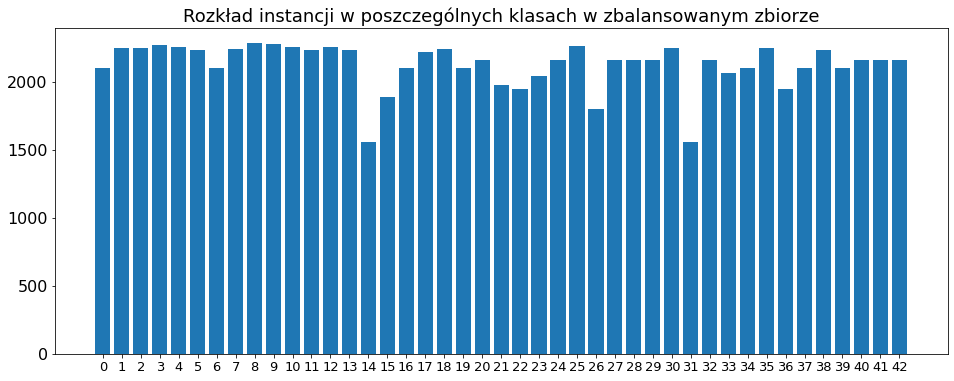

In [217]:
plt.figure(figsize=(16, 6))
plt.bar([k for k in trains_a.keys()], [v for v in trains_a.values()])
plt.title('Rozkład instancji w poszczególnych klasach w zbalansowanym zbiorze')
plt.savefig('balanced_dataset')

In [199]:
random.random()

0.2991673074752542

# Balansowanie zbioru testowego

In [5]:
test_dir = os.path.join(DS_PATH, 'TestR')

In [6]:
tests = {name: len([f_name for f_name in os.listdir(test_dir + '/' + name) if os.path.isfile(test_dir + '/' + name + '/' + f_name)]) for name in os.listdir(test_dir)}

In [8]:
tests = {k: v for k, v in sorted(tests.items(), key=lambda item: int(item[0]))}

In [9]:
test_max = max(tests.values())

In [12]:
times = {}
for cls, items in tests.items():
    times[cls] = test_max / items - 1

In [16]:
import shutil

In [19]:
base_path = './dataset/TestR1/'
random.seed = 42

for cls, time in times.items():
    if time:
        prob = time if time < 1.0 else 1.0
        for img_file in os.listdir(base_path + cls):
            i=0
            rand = random.random()
            if rand < prob:
                image = base_path + cls+ '/' + img_file
                augmented = [image,] * (int(time) if time > 1.0 else 1)
                for idx, to_save in enumerate(augmented):
                    name = img_file.split('.')[0] + '_' + str(idx) + '.png'
                    print(name)
                    shutil.copy(to_save, base_path + cls+ '/' + name)
#                     imageio.imsave(base_path + cls+ '/' + name, to_save)

02930_0.png
02930_1.png
02930_2.png
02930_3.png
02930_4.png
02930_5.png
02930_6.png
02930_7.png
02930_8.png
02930_9.png
02930_10.png
03776_0.png
03776_1.png
03776_2.png
03776_3.png
03776_4.png
03776_5.png
03776_6.png
03776_7.png
03776_8.png
03776_9.png
03776_10.png
11718_0.png
11718_1.png
11718_2.png
11718_3.png
11718_4.png
11718_5.png
11718_6.png
11718_7.png
11718_8.png
11718_9.png
11718_10.png
03009_0.png
03009_1.png
03009_2.png
03009_3.png
03009_4.png
03009_5.png
03009_6.png
03009_7.png
03009_8.png
03009_9.png
03009_10.png
00990_0.png
00990_1.png
00990_2.png
00990_3.png
00990_4.png
00990_5.png
00990_6.png
00990_7.png
00990_8.png
00990_9.png
00990_10.png
07712_0.png
07712_1.png
07712_2.png
07712_3.png
07712_4.png
07712_5.png
07712_6.png
07712_7.png
07712_8.png
07712_9.png
07712_10.png
01853_0.png
01853_1.png
01853_2.png
01853_3.png
01853_4.png
01853_5.png
01853_6.png
01853_7.png
01853_8.png
01853_9.png
01853_10.png
06639_0.png
06639_1.png
06639_2.png
06639_3.png
06639_4.png
06639_5.p

09258_0.png
06829_0.png
09099_0.png
10915_0.png
11938_0.png
06613_0.png
02520_0.png
07501_0.png
06195_0.png
02321_0.png
10994_0.png
01777_0.png
11255_0.png
07319_0.png
12526_0.png
05322_0.png
03967_0.png
00604_0.png
10058_0.png
10555_0.png
08028_0.png
11122_0.png
07468_0.png
08823_0.png
05231_0.png
07968_0.png
06525_0.png
11753_0.png
05764_0.png
07905_0.png
07154_0.png
11204_0.png
02522_0.png
09649_0.png
09708_0.png
12413_0.png
10066_0.png
03350_0.png
00793_0.png
06703_0.png
05744_0.png
06866_0.png
00526_0.png
12089_0.png
02053_0.png
10607_0.png
09870_0.png
07145_0.png
02592_0.png
09022_0.png
11952_0.png
00090_0.png
09933_0.png
00570_0.png
00372_0.png
05243_0.png
01553_0.png
10195_0.png
09853_0.png
11112_0.png
05170_0.png
02254_0.png
07040_0.png
08468_0.png
03156_0.png
10523_0.png
09011_0.png
00516_0.png
11417_0.png
06124_0.png
00332_0.png
07613_0.png
07729_0.png
05014_0.png
04851_0.png
01151_0.png
08095_0.png
00509_0.png
04721_0.png
07532_0.png
10838_0.png
09883_0.png
06914_0.png
0747

10013_2.png
10013_3.png
12627_0.png
12627_1.png
12627_2.png
12627_3.png
12408_0.png
12408_1.png
12408_2.png
12408_3.png
03523_0.png
03523_1.png
03523_2.png
03523_3.png
10210_0.png
10210_1.png
10210_2.png
10210_3.png
05027_0.png
05027_1.png
05027_2.png
05027_3.png
09415_0.png
09415_1.png
09415_2.png
09415_3.png
02987_0.png
02987_1.png
02987_2.png
02987_3.png
08208_0.png
08208_1.png
08208_2.png
08208_3.png
07500_0.png
07500_1.png
07500_2.png
07500_3.png
08486_0.png
08486_1.png
08486_2.png
08486_3.png
11937_0.png
11937_1.png
11937_2.png
11937_3.png
02105_0.png
02105_1.png
02105_2.png
02105_3.png
07175_0.png
07175_1.png
07175_2.png
07175_3.png
06219_0.png
06219_1.png
06219_2.png
06219_3.png
07506_0.png
07506_1.png
07506_2.png
07506_3.png
09295_0.png
09295_1.png
09295_2.png
09295_3.png
08189_0.png
08189_1.png
08189_2.png
08189_3.png
08487_0.png
08487_1.png
08487_2.png
08487_3.png
04662_0.png
04662_1.png
04662_2.png
04662_3.png
00483_0.png
00483_1.png
00483_2.png
00483_3.png
04410_0.png
0441

10321_0.png
05446_0.png
10092_0.png
09491_0.png
08950_0.png
03201_0.png
10345_0.png
03328_0.png
10773_0.png
03755_0.png
06245_0.png
05982_0.png
04729_0.png
10531_0.png
08033_0.png
03034_0.png
06107_0.png
03669_0.png
01146_0.png
05025_0.png
00065_0.png
04847_0.png
09662_0.png
11856_0.png
07641_0.png
04328_0.png
10452_0.png
05216_0.png
12387_0.png
04955_0.png
04041_0.png
08916_0.png
07718_0.png
06809_0.png
05616_0.png
07112_0.png
09942_0.png
04865_0.png
11181_0.png
00342_0.png
05530_0.png
01647_0.png
12495_0.png
05339_0.png
00063_0.png
05709_0.png
10384_0.png
10867_0.png
01197_0.png
12306_0.png
06565_0.png
03934_0.png
09827_0.png
07131_0.png
10262_0.png
01543_0.png
02092_0.png
05384_0.png
03011_0.png
05009_0.png
03098_0.png
05399_0.png
00053_0.png
06207_0.png
09777_0.png
11844_0.png
03393_0.png
08066_0.png
11365_0.png
02554_0.png
05861_0.png
11199_0.png
00326_0.png
05848_0.png
09529_0.png
02467_0.png
08087_0.png
02081_0.png
04346_0.png
02990_0.png
08192_0.png
08251_0.png
09949_0.png
0042

04790_0.png
04790_1.png
06584_0.png
06584_1.png
06281_0.png
06281_1.png
06412_0.png
06412_1.png
06071_0.png
06071_1.png
05075_0.png
05075_1.png
12527_0.png
12527_1.png
04401_0.png
04401_1.png
04265_0.png
04265_1.png
04375_0.png
04375_1.png
11735_0.png
11735_1.png
02068_0.png
02068_1.png
06999_0.png
06999_1.png
00670_0.png
00670_1.png
06701_0.png
06701_1.png
06362_0.png
06362_1.png
12162_0.png
12162_1.png
10202_0.png
10202_1.png
00064_0.png
00064_1.png
08936_0.png
08936_1.png
04166_0.png
04166_1.png
05423_0.png
05423_1.png
08812_0.png
08812_1.png
12448_0.png
12448_1.png
07462_0.png
07462_1.png
04100_0.png
04100_1.png
02082_0.png
02082_1.png
10896_0.png
10896_1.png
04083_0.png
04083_1.png
10914_0.png
10914_1.png
04013_0.png
04013_1.png
02910_0.png
02910_1.png
10222_0.png
10222_1.png
01143_0.png
01143_1.png
04146_0.png
04146_1.png
04876_0.png
04876_1.png
05377_0.png
05377_1.png
03311_0.png
03311_1.png
06473_0.png
06473_1.png
05117_0.png
05117_1.png
00052_0.png
00052_1.png
01737_0.png
0173

11367_0.png
06138_0.png
10996_0.png
02483_0.png
04064_0.png
05694_0.png
12035_0.png
04916_0.png
06714_0.png
08572_0.png
03029_0.png
01295_0.png
08419_0.png
00144_0.png
02183_0.png
01693_0.png
11195_0.png
07126_0.png
12179_0.png
05584_0.png
07177_0.png
02377_0.png
10159_0.png
03652_0.png
11237_0.png
11521_0.png
10903_0.png
04212_0.png
02875_0.png
01522_0.png
01895_0.png
05615_0.png
06848_0.png
07409_0.png
11824_0.png
04416_0.png
07313_0.png
01000_0.png
05682_0.png
10391_0.png
02963_0.png
08666_0.png
07789_0.png
11686_0.png
00031_0.png
00808_0.png
04911_0.png
09180_0.png
00638_0.png
04252_0.png
10024_0.png
05327_0.png
02390_0.png
06646_0.png
08052_0.png
03770_0.png
02996_0.png
10947_0.png
11530_0.png
00136_0.png
08284_0.png
07235_0.png
10065_0.png
12181_0.png
04892_0.png
09579_0.png
02855_0.png
00833_0.png
06982_0.png
06550_0.png
09275_0.png
11089_0.png
12096_0.png
09628_0.png
04372_0.png
05026_0.png
00371_0.png
11529_0.png
05152_0.png
05411_0.png
00914_0.png
05574_0.png
02087_0.png
1077

04122_4.png
04122_5.png
04122_6.png
05712_0.png
05712_1.png
05712_2.png
05712_3.png
05712_4.png
05712_5.png
05712_6.png
01469_0.png
01469_1.png
01469_2.png
01469_3.png
01469_4.png
01469_5.png
01469_6.png
03143_0.png
03143_1.png
03143_2.png
03143_3.png
03143_4.png
03143_5.png
03143_6.png
00242_0.png
00242_1.png
00242_2.png
00242_3.png
00242_4.png
00242_5.png
00242_6.png
01169_0.png
01169_1.png
01169_2.png
01169_3.png
01169_4.png
01169_5.png
01169_6.png
04437_0.png
04437_1.png
04437_2.png
04437_3.png
04437_4.png
04437_5.png
04437_6.png
01103_0.png
01103_1.png
01103_2.png
01103_3.png
01103_4.png
01103_5.png
01103_6.png
12087_0.png
12087_1.png
12087_2.png
12087_3.png
12087_4.png
12087_5.png
12087_6.png
02995_0.png
02995_1.png
02995_2.png
02995_3.png
02995_4.png
02995_5.png
02995_6.png
08006_0.png
08006_1.png
08006_2.png
08006_3.png
08006_4.png
08006_5.png
08006_6.png
09056_0.png
09056_1.png
09056_2.png
09056_3.png
09056_4.png
09056_5.png
09056_6.png
08375_0.png
08375_1.png
08375_2.png
0837

03958_1.png
03958_2.png
03958_3.png
03958_4.png
09926_0.png
09926_1.png
09926_2.png
09926_3.png
09926_4.png
03358_0.png
03358_1.png
03358_2.png
03358_3.png
03358_4.png
09637_0.png
09637_1.png
09637_2.png
09637_3.png
09637_4.png
03062_0.png
03062_1.png
03062_2.png
03062_3.png
03062_4.png
05470_0.png
05470_1.png
05470_2.png
05470_3.png
05470_4.png
02962_0.png
02962_1.png
02962_2.png
02962_3.png
02962_4.png
07367_0.png
07367_1.png
07367_2.png
07367_3.png
07367_4.png
10175_0.png
10175_1.png
10175_2.png
10175_3.png
10175_4.png
06805_0.png
06805_1.png
06805_2.png
06805_3.png
06805_4.png
06611_0.png
06611_1.png
06611_2.png
06611_3.png
06611_4.png
03896_0.png
03896_1.png
03896_2.png
03896_3.png
03896_4.png
01921_0.png
01921_1.png
01921_2.png
01921_3.png
01921_4.png
12294_0.png
12294_1.png
12294_2.png
12294_3.png
12294_4.png
10572_0.png
10572_1.png
10572_2.png
10572_3.png
10572_4.png
07181_0.png
07181_1.png
07181_2.png
07181_3.png
07181_4.png
01241_0.png
01241_1.png
01241_2.png
01241_3.png
0124

06169_0.png
06169_1.png
06169_2.png
06169_3.png
06169_4.png
06169_5.png
06169_6.png
09987_0.png
09987_1.png
09987_2.png
09987_3.png
09987_4.png
09987_5.png
09987_6.png
08746_0.png
08746_1.png
08746_2.png
08746_3.png
08746_4.png
08746_5.png
08746_6.png
10624_0.png
10624_1.png
10624_2.png
10624_3.png
10624_4.png
10624_5.png
10624_6.png
00885_0.png
00885_1.png
00885_2.png
00885_3.png
00885_4.png
00885_5.png
00885_6.png
04587_0.png
04587_1.png
04587_2.png
04587_3.png
04587_4.png
04587_5.png
04587_6.png
09147_0.png
09147_1.png
09147_2.png
09147_3.png
09147_4.png
09147_5.png
09147_6.png
00478_0.png
00478_1.png
00478_2.png
00478_3.png
00478_4.png
00478_5.png
00478_6.png
12602_0.png
12602_1.png
12602_2.png
12602_3.png
12602_4.png
12602_5.png
12602_6.png
00854_0.png
00854_1.png
00854_2.png
00854_3.png
00854_4.png
00854_5.png
00854_6.png
09443_0.png
09443_1.png
09443_2.png
09443_3.png
09443_4.png
09443_5.png
09443_6.png
02751_0.png
02751_1.png
02751_2.png
02751_3.png
02751_4.png
02751_5.png
0275

10742_0.png
10742_1.png
10742_2.png
09177_0.png
09177_1.png
09177_2.png
07282_0.png
07282_1.png
07282_2.png
04299_0.png
04299_1.png
04299_2.png
01695_0.png
01695_1.png
01695_2.png
03727_0.png
03727_1.png
03727_2.png
11825_0.png
11825_1.png
11825_2.png
06788_0.png
06788_1.png
06788_2.png
11912_0.png
11912_1.png
11912_2.png
12427_0.png
12427_1.png
12427_2.png
07142_0.png
07142_1.png
07142_2.png
08587_0.png
08587_1.png
08587_2.png
10121_0.png
10121_1.png
10121_2.png
06212_0.png
06212_1.png
06212_2.png
04114_0.png
04114_1.png
04114_2.png
02966_0.png
02966_1.png
02966_2.png
10062_0.png
10062_1.png
10062_2.png
00057_0.png
00057_1.png
00057_2.png
04043_0.png
04043_1.png
04043_2.png
04995_0.png
04995_1.png
04995_2.png
09630_0.png
09630_1.png
09630_2.png
00599_0.png
00599_1.png
00599_2.png
06651_0.png
06651_1.png
06651_2.png
03965_0.png
03965_1.png
03965_2.png
09596_0.png
09596_1.png
09596_2.png
10674_0.png
10674_1.png
10674_2.png
09401_0.png
09401_1.png
09401_2.png
09927_0.png
09927_1.png
0992

09627_2.png
09627_3.png
10633_0.png
10633_1.png
10633_2.png
10633_3.png
01246_0.png
01246_1.png
01246_2.png
01246_3.png
05444_0.png
05444_1.png
05444_2.png
05444_3.png
06974_0.png
06974_1.png
06974_2.png
06974_3.png
00069_0.png
00069_1.png
00069_2.png
00069_3.png
07586_0.png
07586_1.png
07586_2.png
07586_3.png
11233_0.png
11233_1.png
11233_2.png
11233_3.png
04298_0.png
04298_1.png
04298_2.png
04298_3.png
02738_0.png
02738_1.png
02738_2.png
02738_3.png
07430_0.png
07430_1.png
07430_2.png
07430_3.png
05519_0.png
05519_1.png
05519_2.png
05519_3.png
03851_0.png
03851_1.png
03851_2.png
03851_3.png
00392_0.png
00392_1.png
00392_2.png
00392_3.png
00626_0.png
00626_1.png
00626_2.png
00626_3.png
03746_0.png
03746_1.png
03746_2.png
03746_3.png
01851_0.png
01851_1.png
01851_2.png
01851_3.png
07414_0.png
07414_1.png
07414_2.png
07414_3.png
06569_0.png
06569_1.png
06569_2.png
06569_3.png
09732_0.png
09732_1.png
09732_2.png
09732_3.png
05020_0.png
05020_1.png
05020_2.png
05020_3.png
02086_0.png
0208

05779_2.png
05779_3.png
00496_0.png
00496_1.png
00496_2.png
00496_3.png
01514_0.png
01514_1.png
01514_2.png
01514_3.png
03387_0.png
03387_1.png
03387_2.png
03387_3.png
06090_0.png
06090_1.png
06090_2.png
06090_3.png
12252_0.png
12252_1.png
12252_2.png
12252_3.png
02864_0.png
02864_1.png
02864_2.png
02864_3.png
01713_0.png
01713_1.png
01713_2.png
01713_3.png
04509_0.png
04509_1.png
04509_2.png
04509_3.png
00287_0.png
00287_1.png
00287_2.png
00287_3.png
07559_0.png
07559_1.png
07559_2.png
07559_3.png
10584_0.png
10584_1.png
10584_2.png
10584_3.png
02993_0.png
02993_1.png
02993_2.png
02993_3.png
02072_0.png
02072_1.png
02072_2.png
02072_3.png
07700_0.png
07700_1.png
07700_2.png
07700_3.png
01976_0.png
01976_1.png
01976_2.png
01976_3.png
02655_0.png
02655_1.png
02655_2.png
02655_3.png
10016_0.png
10016_1.png
10016_2.png
10016_3.png
08063_0.png
08063_1.png
08063_2.png
08063_3.png
06458_0.png
06458_1.png
06458_2.png
06458_3.png
10223_0.png
10223_1.png
10223_2.png
10223_3.png
08824_0.png
0882

03501_0.png
03501_1.png
03501_2.png
03501_3.png
03501_4.png
03501_5.png
03501_6.png
03501_7.png
03501_8.png
03501_9.png
03501_10.png
05527_0.png
05527_1.png
05527_2.png
05527_3.png
05527_4.png
05527_5.png
05527_6.png
05527_7.png
05527_8.png
05527_9.png
05527_10.png
04977_0.png
04977_1.png
04977_2.png
04977_3.png
04977_4.png
04977_5.png
04977_6.png
04977_7.png
04977_8.png
04977_9.png
04977_10.png
02500_0.png
02500_1.png
02500_2.png
02500_3.png
02500_4.png
02500_5.png
02500_6.png
02500_7.png
02500_8.png
02500_9.png
02500_10.png
09855_0.png
09855_1.png
09855_2.png
09855_3.png
09855_4.png
09855_5.png
09855_6.png
09855_7.png
09855_8.png
09855_9.png
09855_10.png
12454_0.png
12454_1.png
12454_2.png
12454_3.png
12454_4.png
12454_5.png
12454_6.png
12454_7.png
12454_8.png
12454_9.png
12454_10.png
08000_0.png
08000_1.png
08000_2.png
08000_3.png
08000_4.png
08000_5.png
08000_6.png
08000_7.png
08000_8.png
08000_9.png
08000_10.png
01617_0.png
01617_1.png
01617_2.png
01617_3.png
01617_4.png
01617_5.p

10888_0.png
08566_0.png
09488_0.png
00293_0.png
04302_0.png
00471_0.png
12258_0.png
10981_0.png
11398_0.png
05044_0.png
01208_0.png
03456_0.png
06951_0.png
12623_0.png
06478_0.png
12084_0.png
08617_0.png
06647_0.png
00742_0.png
09368_0.png
02035_0.png
10069_0.png
03700_0.png
01996_0.png
08532_0.png
06500_0.png
02444_0.png
04329_0.png
06977_0.png
09204_0.png
03148_0.png
05708_0.png
03913_0.png
12231_0.png
11776_0.png
12483_0.png
09437_0.png
04144_0.png
00085_0.png
04828_0.png
11136_0.png
05633_0.png
03488_0.png
08790_0.png
08867_0.png
02451_0.png
02135_0.png
05953_0.png
04607_0.png
08305_0.png
09965_0.png
10167_0.png
05450_0.png
08999_0.png
07391_0.png
04981_0.png
04264_0.png
09534_0.png
10418_0.png
02920_0.png
00298_0.png
10797_0.png
04094_0.png
09653_0.png
09984_0.png
00356_0.png
09212_0.png
10063_0.png
10774_0.png
06900_0.png
09571_0.png
11715_0.png
07008_0.png
02212_0.png
01587_0.png
01315_0.png
03563_0.png
09906_0.png
02725_0.png
00260_0.png
02350_0.png
09525_0.png
03347_0.png
0551

02906_4.png
02906_5.png
02906_6.png
02906_7.png
02906_8.png
02906_9.png
02906_10.png
03605_0.png
03605_1.png
03605_2.png
03605_3.png
03605_4.png
03605_5.png
03605_6.png
03605_7.png
03605_8.png
03605_9.png
03605_10.png
03616_0.png
03616_1.png
03616_2.png
03616_3.png
03616_4.png
03616_5.png
03616_6.png
03616_7.png
03616_8.png
03616_9.png
03616_10.png
11115_0.png
11115_1.png
11115_2.png
11115_3.png
11115_4.png
11115_5.png
11115_6.png
11115_7.png
11115_8.png
11115_9.png
11115_10.png
07498_0.png
07498_1.png
07498_2.png
07498_3.png
07498_4.png
07498_5.png
07498_6.png
07498_7.png
07498_8.png
07498_9.png
07498_10.png
01254_0.png
01254_1.png
01254_2.png
01254_3.png
01254_4.png
01254_5.png
01254_6.png
01254_7.png
01254_8.png
01254_9.png
01254_10.png
08168_0.png
08168_1.png
08168_2.png
08168_3.png
08168_4.png
08168_5.png
08168_6.png
08168_7.png
08168_8.png
08168_9.png
08168_10.png
12060_0.png
12060_1.png
12060_2.png
12060_3.png
12060_4.png
12060_5.png
12060_6.png
12060_7.png
12060_8.png
12060_9.p

02184_6.png
11738_0.png
11738_1.png
11738_2.png
11738_3.png
11738_4.png
11738_5.png
11738_6.png
06062_0.png
06062_1.png
06062_2.png
06062_3.png
06062_4.png
06062_5.png
06062_6.png
07848_0.png
07848_1.png
07848_2.png
07848_3.png
07848_4.png
07848_5.png
07848_6.png
09274_0.png
09274_1.png
09274_2.png
09274_3.png
09274_4.png
09274_5.png
09274_6.png
01958_0.png
01958_1.png
01958_2.png
01958_3.png
01958_4.png
01958_5.png
01958_6.png
04898_0.png
04898_1.png
04898_2.png
04898_3.png
04898_4.png
04898_5.png
04898_6.png
04709_0.png
04709_1.png
04709_2.png
04709_3.png
04709_4.png
04709_5.png
04709_6.png
05608_0.png
05608_1.png
05608_2.png
05608_3.png
05608_4.png
05608_5.png
05608_6.png
06267_0.png
06267_1.png
06267_2.png
06267_3.png
06267_4.png
06267_5.png
06267_6.png
07146_0.png
07146_1.png
07146_2.png
07146_3.png
07146_4.png
07146_5.png
07146_6.png
07267_0.png
07267_1.png
07267_2.png
07267_3.png
07267_4.png
07267_5.png
07267_6.png
08019_0.png
08019_1.png
08019_2.png
08019_3.png
08019_4.png
0801

10735_4.png
10735_5.png
10735_6.png
05022_0.png
05022_1.png
05022_2.png
05022_3.png
05022_4.png
05022_5.png
05022_6.png
07575_0.png
07575_1.png
07575_2.png
07575_3.png
07575_4.png
07575_5.png
07575_6.png
06668_0.png
06668_1.png
06668_2.png
06668_3.png
06668_4.png
06668_5.png
06668_6.png
01612_0.png
01612_1.png
01612_2.png
01612_3.png
01612_4.png
01612_5.png
01612_6.png
00795_0.png
00795_1.png
00795_2.png
00795_3.png
00795_4.png
00795_5.png
00795_6.png
00870_0.png
00870_1.png
00870_2.png
00870_3.png
00870_4.png
00870_5.png
00870_6.png
12502_0.png
12502_1.png
12502_2.png
12502_3.png
12502_4.png
12502_5.png
12502_6.png
11842_0.png
11842_1.png
11842_2.png
11842_3.png
11842_4.png
11842_5.png
11842_6.png
01462_0.png
01462_1.png
01462_2.png
01462_3.png
01462_4.png
01462_5.png
01462_6.png
03991_0.png
03991_1.png
03991_2.png
03991_3.png
03991_4.png
03991_5.png
03991_6.png
00956_0.png
00956_1.png
00956_2.png
00956_3.png
00956_4.png
00956_5.png
00956_6.png
02332_0.png
02332_1.png
02332_2.png
0233

In [20]:
tests_a = {name: len([f_name for f_name in os.listdir(base_path + '/' + name) if os.path.isfile(base_path + '/' + name + '/' + f_name)]) for name in os.listdir(base_path)}

In [22]:
tests_a = {k: v for k, v in sorted(tests_a.items(), key=lambda item: int(item[0]))}

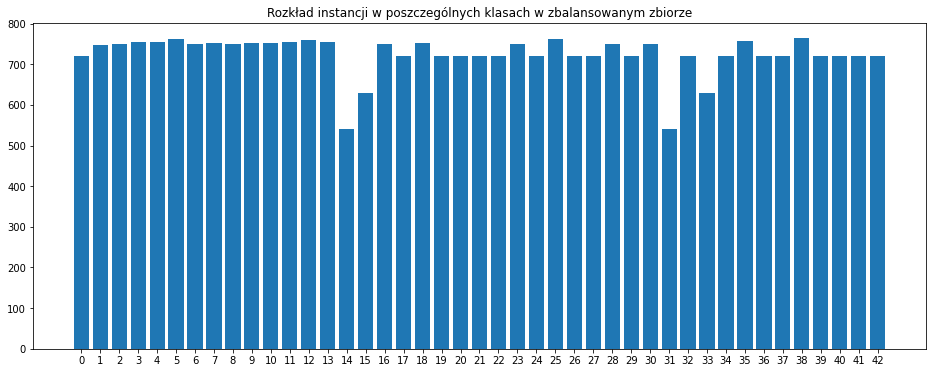

In [24]:
plt.figure(figsize=(16, 6))
plt.bar([k for k in tests_a.keys()], [v for v in tests_a.values()])
plt.title('Rozkład instancji w poszczególnych klasach w zbalansowanym zbiorze')
plt.savefig('balanced_dataset')

# Mergowanie

In [48]:
classes = {'ograniczenie_predkosci': [0,1,2,3,4,5,7,8], 
           'koniec_ograniczenia': [6, 32, 41, 42], 
           'znaki_zakazu':[9, 10, 15, 16, 17], 
           'okreslenie_pierwszenstwa': [11, 12, 13, 14], 
           'znaki_ostrzegawcze': [18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31], 
           'znaki_nakazu': [33, 34, 35, 36, 37, 38, 39, 40]}

In [49]:
trains = {name: len([f_name for f_name in os.listdir(train_dir + '/' + name) if os.path.isfile(train_dir + '/' + name + '/' + f_name)]) for name in os.listdir(train_dir)}

In [50]:
trains = {k: v for k, v in sorted(trains.items(), key=lambda item: int(item[0]))}

In [51]:
trains

{'0': 210,
 '1': 2220,
 '2': 2250,
 '3': 1410,
 '4': 1980,
 '5': 1860,
 '6': 420,
 '7': 1440,
 '8': 1410,
 '9': 1470,
 '10': 2010,
 '11': 1320,
 '12': 2100,
 '13': 2160,
 '14': 780,
 '15': 630,
 '16': 420,
 '17': 1110,
 '18': 1200,
 '19': 210,
 '20': 360,
 '21': 330,
 '22': 390,
 '23': 510,
 '24': 270,
 '25': 1500,
 '26': 600,
 '27': 240,
 '28': 540,
 '29': 270,
 '30': 450,
 '31': 780,
 '32': 240,
 '33': 689,
 '34': 420,
 '35': 1200,
 '36': 390,
 '37': 210,
 '38': 2070,
 '39': 300,
 '40': 360,
 '41': 240,
 '42': 240}

In [52]:
merged = {k: sum([trains[str(cls)] for cls in v]) for k, v in classes.items()}

In [53]:
merged

{'ograniczenie_predkosci': 12780,
 'koniec_ograniczenia': 1140,
 'znaki_zakazu': 5640,
 'okreslenie_pierwszenstwa': 6360,
 'znaki_ostrzegawcze': 7650,
 'znaki_nakazu': 5459}

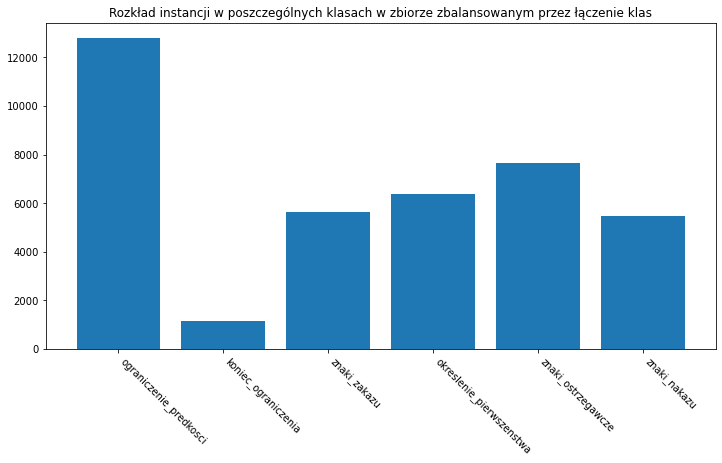

In [57]:
plt.figure(figsize=(12, 6))
plt.xticks(rotation=-45, ha='left')
plt.bar([k for k in merged.keys()], [v for v in merged.values()])
plt.title('Rozkład instancji w poszczególnych klasach w zbiorze zbalansowanym przez łączenie klas')
plt.savefig('balanced_dataset_merged', bbox_inches="tight")